In [3]:
import pandas as pd
import numpy as np

from scipy.fft import fft, fftfreq, ifft, fft2, ifft2, ifftshift
from scipy.signal import blackman
import matplotlib.pyplot as plt
from scipy.fftpack import fft, fftshift
from scipy.signal import butter
from scipy import signal
from scipy.signal import convolve2d as conv2

from skimage import color, data, restoration
from scipy.ndimage import gaussian_filter as gf

from xrdc import featurization as feat
from xrdc import fourier
from xrdc import peak_fitting as pf

#pd.options.plotting.backend = "matplotlib"
pd.options.plotting.backend = "plotly"

workflows/alanConfig


In [4]:
from xrdc import source_separation as sep
from xrdc import featurization as feat
from xrdc.datasets import d3d

In [476]:
df = pd.read_csv("YijinXRD.dat", sep = '\t')
qq = df.iloc[:, 0]

patterns = df.iloc[:, 2:]
patterns = (patterns.values.T)[:, 1:]

for i in range(len(patterns)):
    patterns[i] = patterns[i] - i * 1000
    
#patterns = np.vstack((patterns[0][None, :], patterns))

In [477]:
slow_q, fast_q, slow_T, fast_T = sep.separate_signal(patterns, cutoff = .25,  threshold = 50, smooth_q = 1.7,
                                                    background_after_filter = False)

(0, 0)


In [298]:
from importlib import reload
reload(feat)

<module 'xrdc.featurization' from '/Users/ollie/anaconda3/lib/python3.7/site-packages/xrdc-1.0-py3.7.egg/xrdc/featurization.py'>

In [538]:
%matplotlib inline

Peak at 69, start iteration with error = 0.5843662692684708
Peak at 69, iteration 0: error = 367.6538222992807
Peak at 68, start iteration with error = 0.6139111896350452
Peak at 68, iteration 0: error = 303.7628728600483
Peak at 276, start iteration with error = 0.5769673507626526
Peak at 276, iteration 0: error = 286.17957585414604
Peak at 276, start iteration with error = 0.5866388269521806
Peak at 276, iteration 0: error = 393.17776933369424
Peak at 210, start iteration with error = 0.6271401962805294
Peak at 210, iteration 0: error = 378.5556236286393
Peak at 207, start iteration with error = 0.5598542157613888
Peak at 207, iteration 0: error = 386.627801960552
25
13.857176311094678


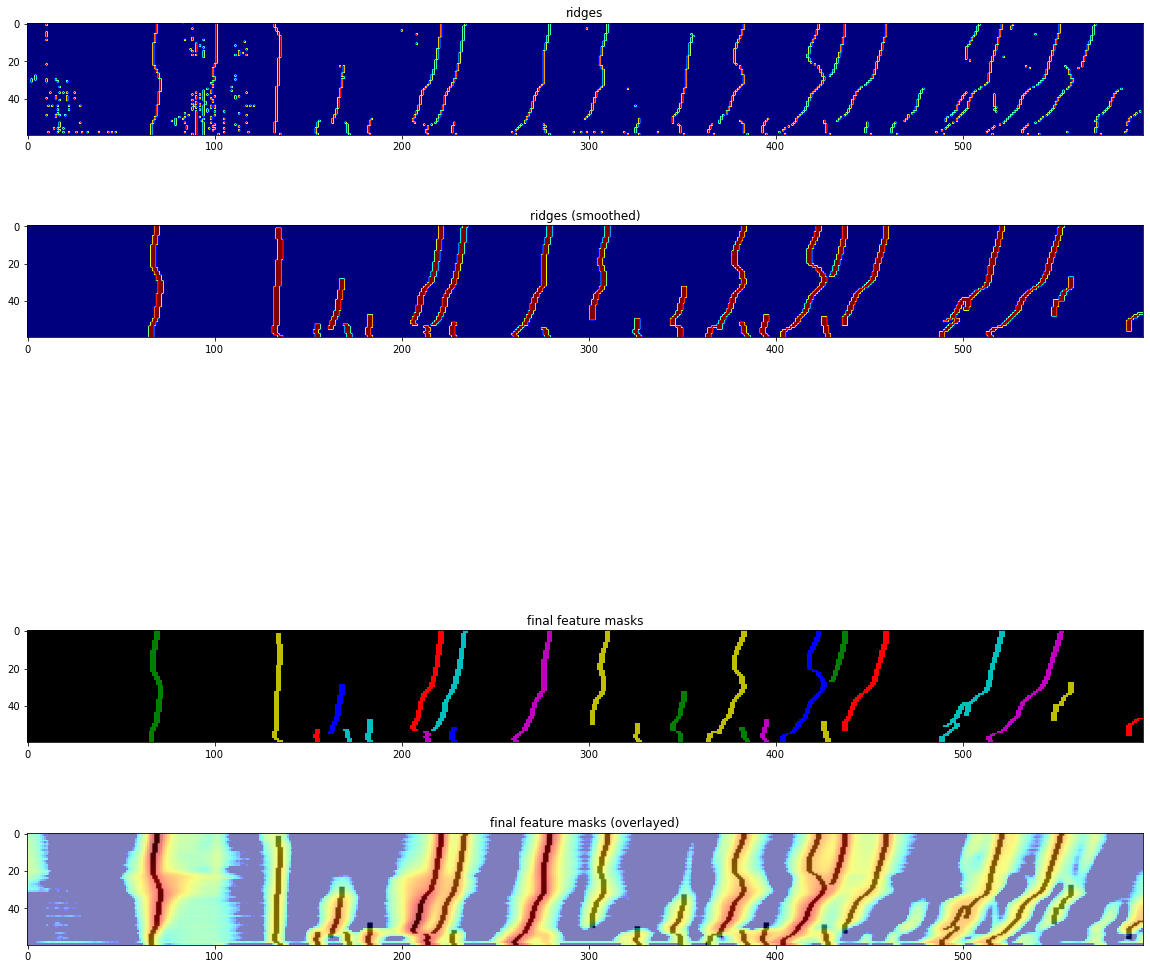

In [539]:
def default_featurize(patterns_pp):
    #patterns_pp = gf(patterns, (1, 1.7))
    labeled, feature_masks, activations, norm_, activations_n1 = feat.get_ridge_features(
        patterns_pp,
       smooth_ax1 = 'FWHM', smooth_ax0 = 1, threshold_percentile = 75, thicken = True, size_thresh = 5, bgsub=False,
        log_scale_features = False, fwhm_finder=feat.fwhm_finder, do_flood_thicken = False, max_size_flood = 20,
        thicken_ax0 = 0, thicken_ax1 = 1, flood_threshold=.95, smooth_factor_ax1 = .125)
    return labeled, feature_masks, activations, norm_, activations_n1


patterns_pp = fast_q * (fast_q > 0)
labeled, feature_masks, activations, _norm, activations_n1 = default_featurize(patterns_pp);

In [37]:
activations.shape, activations_n1.shape, uncertainty.shape

((26, 60), (26, 60), (26, 60))

In [56]:
a, b = 2, 3
#plt.rcParams["figure.figsize"]=(20, 15)
# plt.rcParams["figure.figsize"]=(12,8)
plt.rcParams["figure.figsize"]=(8,8)

/Users/ollie/anaconda3/lib/python3.7/site-packages/xrdc-1.0-py3.7.egg/xrdc/featurization.py:200: RuntimeWarning: invalid value encountered in true_divide
  similarity = np.dot(composition, composition.T) / np.outer(norm, norm)
/Users/ollie/anaconda3/lib/python3.7/site-packages/xrdc-1.0-py3.7.egg/xrdc/featurization.py:208: RuntimeWarning: invalid value encountered in subtract
  dist_l2 = np.sqrt(np.einsum("ijk, ijk->ij", a - b, a - b))


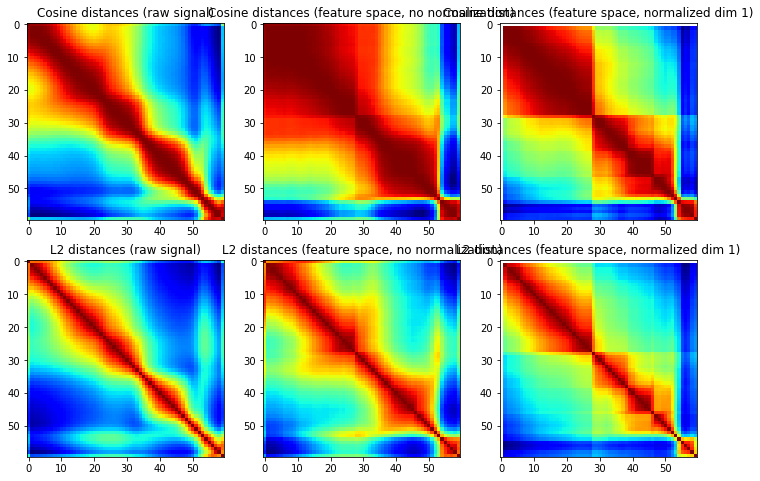

In [141]:
feat.similarity_plot_row(feat.csim_pairs, 'Cosine', patterns_pp, activations_bgsubbed, activations_n1_bgsubbed,
                        a = a, b = b)
feat.similarity_plot_row(lambda arr: -feat.l2_pairs(arr), 'L2', patterns_pp, activations_bgsubbed, activations_n1_bgsubbed, offset = 3,
                        a = a, b = b)

In [306]:
reload(feat)

<module 'xrdc.featurization' from '/Users/ollie/anaconda3/lib/python3.7/site-packages/xrdc-1.0-py3.7.egg/xrdc/featurization.py'>

In [130]:
fsub_stop_2d = pf.curvefit_2d((patterns - 0), stdratio_threshold = 2, noise_estimate = fast_T,
                   background = slow_q, bg_shift_pos = False)



numBlocks: 357, dataPts/Block: 1.6722689075630253
[  0.  34. 126. 182. 229. 262. 296. 341. 407. 429. 447. 500. 511. 538.
 566. 596.]
False
Experimental Info used: 

{'blockBounds': array([  0.,  34., 126., 182., 229., 262., 296., 341., 407., 429., 447.,
       500., 511., 538., 566., 596.])}
Peak at 1, start iteration with error = 0.3504480471016032
Peak at 1, iteration 0: error = 0.5848669327667578
0.01913215337701901
    ----Saving data for block between 1.00 - 33.00
[-0.6, -0.5734261245527356, 2602.3990897967824, 6.033455380077503, 7.917458632036792e-15]
Peak at 70, start iteration with error = 0.5741359455738658
Peak at 70, iteration 0: error = 28.39907360799533
0.15544232743701203
    ----Saving data for block between 34.00 - 125.00
[70.3059123084697, 14.918062749251655, 189324.52209005345, 2.0364561262986123, 0.5017302064923256]
Peak at 133, start iteration with error = 0.26570340709426826
Peak at 133, iteration 0: error = 2.0857681098974004
0.04537752158609095
    ----Saving dat

Peak at 384, iteration 0: error = 7.443446693853487
3.7390432776564766
Peak at 384, iteration 1: error = 8.398122562290636
3.0973406523086187
Peak at 384, iteration 2: error = 9.41868175634352
    ----Saving data for block between 355.00 - 406.00
[383.7362295695763, 174.8661138209059, 15361.723386611746, 2.3955103514157345, 0.2442412513614555, 375.8067440939822, -1075.5281833239096, 1374.6642913441779, 2.5272804342501414, 1.041755877894226e-27, 384.87646591490926, 886.3863724548679, 15746.184816218092, 3.732316443432978, 0.7740787859232727]
Peak at 424, start iteration with error = 0.810496568759
Peak at 424, iteration 0: error = 2.6629928130277154
5.305509093451512
Peak at 424, iteration 1: error = 3.836199233637981
2.992168478257043
Peak at 424, iteration 2: error = 6.993694593474376
    ----Saving data for block between 407.00 - 428.00
[423.9706745708966, -1116.5829006278686, 27177.321096549567, 2.466768693608961, 0.5602403001887337, 428.14792689787083, 758.8456099301721, 6221.32570

Peak at 384, start iteration with error = 0.39395442214282334
Peak at 384, iteration 0: error = 12.139609251260318
3.230062061065756
Peak at 384, iteration 1: error = 12.774269153978437
2.818670821507919
Peak at 384, iteration 2: error = 13.563387037886725
    ----Saving data for block between 339.00 - 406.00
[383.4938170570715, -178.82499260404313, 20665.60320952422, 2.7067861924342, 6.655550295029457e-05, 376.5242600947265, -88.71639002715332, 2239.2734842642376, 3.0703390961437247, 9.435230828080265e-23, 386.55429147304716, 263.3526612481955, 8147.652645925344, 3.3468943601043466, 0.6991039000831155]
Peak at 424, start iteration with error = 0.8130438098953654
Peak at 424, iteration 0: error = 1.0786147861886743
5.271927433108608
Peak at 424, iteration 1: error = 5.203272935651389
3.3885217223578605
Peak at 424, iteration 2: error = 8.575404810868454
    ----Saving data for block between 407.00 - 429.00
[424.6860927119358, -638.8220254668053, 30354.563081575638, 2.9633124704902474, 

Peak at 384, start iteration with error = 0.5687359989631704
Peak at 384, iteration 0: error = 7.267283161662501
6.6756400823826585
Peak at 384, iteration 1: error = 8.052060674943661
5.586885947446759
Optimal parameters not found: The maximum number of function evaluations is exceeded.
Peak at 384, iteration 2: error = 8.043750841790882
    ----Saving data for block between 354.00 - 405.00
[383.33781121291815, 574.40117116552, 21805.554003097965, 2.730692852837666, 0.0003186679225731102, 376.2965201239206, -185.37179812892495, 2381.159227290847, 3.240256905685565, 6.712427981146607e-27, 387.0498190740846, -400.53356011764333, 7395.534393011068, 2.4263253560063656, 1.6634547369343142]
Peak at 424, start iteration with error = 0.8214111416618085
Peak at 424, iteration 0: error = 0.9842652195450318
8.746186965900657
Peak at 424, iteration 1: error = 4.078984564340636
6.457920830595177
Peak at 424, iteration 2: error = 8.151625351403307
    ----Saving data for block between 406.00 - 429.0

Peak at 383, start iteration with error = 0.4370829898570645
Peak at 383, iteration 0: error = 10.31338763340607
5.637099239641954
Peak at 383, iteration 1: error = 11.000047140520035
4.828522013936335
Peak at 383, iteration 2: error = 11.729779141538794
    ----Saving data for block between 339.00 - 405.00
[383.10699765038026, 1744.172579312121, 14206.637007610807, 2.5765357122063404, 2.3499248332905017e-13, 375.13106788660417, -742.0149707618264, 1451.583257539485, 2.7153617491414077, 6.89143712497956e-29, 384.3140869632606, -1007.6703521890564, 14959.829741942865, 3.9945074252423582, 0.5941374762757871]
Peak at 423, start iteration with error = 0.8151496907322541
Peak at 423, iteration 0: error = 0.8551247919427303
20.07939373192189
Peak at 423, iteration 1: error = 18.62486082410408
11.729691691111785
Peak at 423, iteration 2: error = 25.171750975061048
    ----Saving data for block between 406.00 - 428.00
[423.1585641935395, -744.1232797560738, 25428.09677549187, 2.513261949075596

/Users/ollie/anaconda3/lib/python3.7/site-packages/scipy/optimize/minpack.py:829: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


    ----Saving data for block between 499.00 - 509.00
[508.6530671266642, 76.23267702560432, 4490.179456413838, 2.4999999999999996, 1.6634634291363495, 506.4899190669242, -71.72164737926732, 10.826029009091851, 0.3049716988082705, 4.274950700731283e-20, 499.00521303725503, -99.5478790642963, 348.3768037086702, 2.4999999999999996, 7.274582358058647e-31]
Peak at 521, start iteration with error = 0.8715983743950088
Peak at 521, iteration 0: error = 2.066159916387645
48.410562332800254
Peak at 521, iteration 1: error = 0.33096675261339686
24.004146333984483
Peak at 521, iteration 2: error = 0.6134901210711532
    ----Saving data for block between 510.00 - 542.00
[521.2867790771105, -625.2878024748669, 17359.16535369978, 1.8615564324221139, 1.3500302705627358, 527.7430025939516, 477.33741455322155, 6412.711552120729, 1.354236298662263, 2.062238451057269, 508.8048850070738, 106.7043694903608, 2624.9213038178113, 3.428894831341471, 3.3505727489868396e-20]
Peak at 553, start iteration with err

    ----Saving data for block between 446.00 - 498.00
[459.7500410567763, -1072.8413966979233, 10602.238751407645, 4.01877565183416, 1.131632193099201, 443.4000327033433, -396.6784064109556, 8234.588820945648, 8.061025954438673, 6.970679550143998e-05, 459.9794831434441, 1462.9217263577964, 18225.92876575889, 2.299814956889578, 0.0014531806816697249]
Peak at 508, start iteration with error = 0.594629871536904
Peak at 508, iteration 0: error = 3.0565177721043346
3.477311327042932
Peak at 508, iteration 1: error = 1.51889140168415
3.009324421574775
Peak at 508, iteration 2: error = 1.8133465691405495


/Users/ollie/anaconda3/lib/python3.7/site-packages/scipy/optimize/minpack.py:829: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


    ----Saving data for block between 499.00 - 508.00
[508.44999999999993, -96.19149707531, 2736.183548813735, 2.2499999999999996, 0.8137271405841341, 499.34141399130226, 57.602639172936556, 249.06945752576084, 2.2499999999999996, 1.9068605191678e-26, 505.3835234629936, -22.36978207231162, 453.9254816072031, 2.1949964416214307, 6.075556473622922e-35]
Peak at 521, start iteration with error = 0.8156136926432029
Peak at 521, iteration 0: error = 0.3998660550552008
87.3153718402022
Peak at 521, iteration 1: error = 0.24001304015522767
44.841466526209715
Peak at 521, iteration 2: error = 0.13936737554609796
    ----Saving data for block between 509.00 - 536.00
[521.0953183491473, -442.01141128650414, 16691.630058437488, 1.9668830928420524, 1.1981614879901874, 527.4996294159986, 1037.1751260392552, 6329.5679000869495, 1.5453920722437884, 1.9035217893487957, 508.0234095531958, -625.6929397351593, 2854.5901642269823, 3.7189570100383222, 8.100456751721131e-13]
Peak at 553, start iteration with

    ----Saving data for block between 446.00 - 497.00
[459.2680127955882, 1394.8146898914295, 8094.765509177048, 4.9085626410860685, 0.519112579125982, 443.4500203777584, -292.6192748904058, 7516.10795766954, 7.1302481170574765, 0.0017599899490429395, 459.76409482598245, -1106.4913907667817, 20205.167572808008, 2.283393475056534, 0.1697475326822]
Peak at 508, start iteration with error = 0.6233524624631765
Peak at 508, iteration 0: error = 3.370401848298155
6.238215367458365
Peak at 508, iteration 1: error = 4.157194070753689
5.06908069250548
Peak at 508, iteration 2: error = 0.7745275457764532


/Users/ollie/anaconda3/lib/python3.7/site-packages/scipy/optimize/minpack.py:829: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


    ----Saving data for block between 498.00 - 508.00
[507.8714474455861, -35.503981453651, 2285.914730352716, 2.4999999999999996, 0.20329053269575542, 504.76095730560553, -19.086945675234894, 381.9580898787475, 1.922398469225892, 3.647124416979285e-32, 498.72777566541805, 0.12218189962166792, 466.4716493147447, 2.4999999999999916, 1.514292725817199]
Peak at 521, start iteration with error = 0.8657609217442871
Peak at 521, iteration 0: error = 1.0248620494958043
66.50808769053093
Peak at 521, iteration 1: error = 0.2795335367672854
43.05650850938944
Peak at 521, iteration 2: error = 0.4373420257670195
    ----Saving data for block between 509.00 - 541.00
[521.4933004409357, -431.1367043616067, 17031.759671121785, 0.5875045662496226, 2.4542021614282423, 527.4485994364338, -436.6981033083208, 2984.4529165160443, 2.411828779765663, 4.017447979750275e-31, 519.5527386237702, 891.0339323598406, 2326.678085103486, 1.6358517492261222, 1.907224233094325e-28]
Peak at 552, start iteration with er

[459.5342739440465, 597.0321678343222, 28731.573981967376, 2.043264912765121, 0.9511321178201387, 448.30000000000007, -478.5284377168541, 3790.114882058391, 5.584994825224069, 4.7129355320458073e-36, 455.04149742355816, -147.277552768376, 169.7227885965885, 1.7113783841964045, 1.5680314588991335e-33]
Peak at 507, start iteration with error = 0.28906913361602754
Peak at 507, iteration 0: error = 1.595006305490293
0.9528665443900733
    ----Saving data for block between 485.00 - 508.00
[507.0348298449533, -1.4171122271767091, 2165.065094869972, 2.8505239963553946, 2.021710716590728e-15]
Peak at 521, start iteration with error = 0.9407010071032631
Peak at 521, iteration 0: error = 2.7136578559681026
26.033485339480052
Peak at 521, iteration 1: error = 0.9353810930845909
16.643275632866967
Peak at 521, iteration 2: error = 2.0718720837779574
    ----Saving data for block between 509.00 - 541.00
[521.3137946844868, -330.7454774243982, 17085.743575246932, 0.40156303519697756, 2.6129221836365

Peak at 459, start iteration with error = 0.7680739382908203
Peak at 459, iteration 0: error = 15.292768056748342
15.870249089812026
Peak at 459, iteration 1: error = 4.047215908351788
4.379353861258471
Peak at 459, iteration 2: error = 5.774388893127674
    ----Saving data for block between 446.00 - 484.00
[459.2228123074791, 1108.169500974822, 25286.851548475173, 2.127073994692677, 1.1500860591269757, 444.1000000000001, -77.88724758728716, 7812.183983731542, 7.961558116945724, 2.4512080482628233e-27, 459.4048180032359, -1055.6076696538996, 3172.0693436235742, 1.9759165332389663, 2.7764010983535276e-05]
Peak at 506, start iteration with error = 0.30140270345439907
Peak at 506, iteration 0: error = 1.3475044940138186
0.5525355070378896
    ----Saving data for block between 485.00 - 507.00
[506.2646717392823, -1.2811134872047063, 2175.3650700666117, 2.900005461707506, 1.2061026701094953e-22]
Peak at 520, start iteration with error = 0.7583690530184812
Peak at 520, iteration 0: error = 0

[505.7879792204621, -4.882112072808059, 1857.0032072086744, 2.7499999999999996, 8.289531737917503e-16]
Peak at 520, start iteration with error = 0.8913427589872793
Peak at 520, iteration 0: error = 4.852719533039831
21.76362002295594
Peak at 520, iteration 1: error = 3.573013734624378
11.450439098334003
Peak at 520, iteration 2: error = 4.841791644485409
    ----Saving data for block between 508.00 - 540.00
[520.0694581613766, 130.05423526133046, 15622.266063050212, 2.1411560378556898, 1.0279137660184348, 526.417169635663, 391.7743245011366, 5442.704830768003, 2.0801711472635813, 1.3149882850844312, 506.40000000000003, -555.5609741644189, 2368.571031304527, 2.3640509242718495, 1.7224063387628383]
Peak at 551, start iteration with error = 0.9218175414784133
Peak at 551, iteration 0: error = 0.4256226065472176
12.353996531185915
Peak at 551, iteration 1: error = 0.4998772096501686
9.45111771075318
Peak at 551, iteration 2: error = 1.0498162026918703
    ----Saving data for block between 

    ----Saving data for block between 507.00 - 533.00
[519.8475812301916, -273.6573118849489, 12010.668716174849, 2.8062838027426262, 8.727262570886086e-34, 526.1612980124529, 681.76421677941, 3474.809082665803, 2.4015043824714777, 2.1688411138454098e-32, 519.4886731409888, -281.9249147143082, 502.1356874383649, 1.5253637963072642, 2.705531586993338e-33]
Peak at 551, start iteration with error = 0.8272657592738241
Peak at 551, iteration 0: error = 0.4969789389225398
5.2695669584048765
Peak at 551, iteration 1: error = 0.35212023186299785
4.621087346541601
Peak at 551, iteration 2: error = 0.2881816597038483
    ----Saving data for block between 534.00 - 559.00
[551.0460348618686, -420.84735673576563, 24493.886034375773, 1.6733724333335558, 2.250453330421485, 532.7562071787295, -627.2314633068625, 2885.730093655167, 6.243861128219457, 0.4182277978721986, 558.5386870093059, 822.9364635479828, 632.6718458421262, 2.345632087688078, 0.004546095052258433]
Peak at 569, start iteration with er

Optimal parameters not found: The maximum number of function evaluations is exceeded.
    ----Saving data for block between 495.00 - 509.00
[504.93117062520884, -6.578014452148905, 1574.3455898425423, 3.053506763128474, 6.230078666944917e-14, 508.86000000195884, -2.295926059788783, 36.67030099288258, 0.6075554401001283, 8.313742669784043e-15, 503.0576666034228, -3.4891029664551265, 52.33652196579996, 1.0331716955586479, 3.696786946800214e-17]
Peak at 520, start iteration with error = 0.9121261044864987
Peak at 520, iteration 0: error = 0.6375560166228725
40.83414745603582
Peak at 520, iteration 1: error = 1.5639865772888764
26.12288986711319
Peak at 520, iteration 2: error = 2.099287942074058
    ----Saving data for block between 510.00 - 539.00
[519.5451974497564, 763.4245995547327, 6599.533281648881, 7.558228847616622e-08, 3.5339698146952223, 525.8318130839691, -298.2485520144455, 4699.758125157742, 2.2626676272211377, 0.9579373654960366, 519.4356617902116, -490.2070836561237, 8791.7

Peak at 504, start iteration with error = 0.4890280330715915
Peak at 504, iteration 0: error = 1.7487745368604943
2.534899538384406
Peak at 504, iteration 1: error = 2.494834643261712
1.9273531177520198
    ----Saving data for block between 495.00 - 504.00
[503.7083524612915, -48.37809647930663, 572.063135383878, 1.3486228866616485, 1.2919141330551365e-33, 501.60234403577465, 48.29593442888285, 161.02309680234904, 0.9407933009623142, 9.90998723633118e-34]


/Users/ollie/anaconda3/lib/python3.7/site-packages/scipy/optimize/minpack.py:829: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


Peak at 519, start iteration with error = 0.899391146316226
Peak at 519, iteration 0: error = 3.2956000644061767
37.36688264582396
Peak at 519, iteration 1: error = 4.332593098490034
19.958800660779843
Peak at 519, iteration 2: error = 5.594114456080695
    ----Saving data for block between 505.00 - 539.00
[519.1103429599086, 307.08474052631885, 14040.038610085569, 2.260115180660242, 0.8588216173556615, 525.5671502802434, 199.64875842101983, 5011.406468851602, 2.012688050417278, 1.317503139944782, 504.23360289154834, -535.4903607903229, 1173.2273304874548, 2.995004314135861, 3.8353298068864873e-19]
Peak at 550, start iteration with error = 0.9273402012278847
Peak at 550, iteration 0: error = 0.3753858565281052
8.173218481920614
Peak at 550, iteration 1: error = 0.18329215850923494
6.4991728350949405
Peak at 550, iteration 2: error = 0.24382487024687297
    ----Saving data for block between 540.00 - 559.00
[550.2230941145905, -575.2960024787533, 15974.420515318603, 2.7595804641351327, 1

Peak at 503, start iteration with error = 0.4469103483284878
Peak at 503, iteration 0: error = 1.2138333767116343
1.8529123345799465
    ----Saving data for block between 494.00 - 504.00
[503.28964624503027, -1.9844942455519998, 758.7304786811471, 2.0433939713555502, 2.737053212675181e-21]
Peak at 519, start iteration with error = 0.7296407201714713
Peak at 519, iteration 0: error = 0.6479810454159836
34.65749484991322
Peak at 519, iteration 1: error = 0.4840928120663433
20.417188340619642
Peak at 519, iteration 2: error = 0.473827774925978
    ----Saving data for block between 505.00 - 532.00
[518.8334612475212, 220.70158244430027, 11120.134436680664, 2.816459791850535, 1.5849195577145585e-15, 525.2596592658093, -238.76264856114446, 3692.2453298522864, 2.583151198228544, 9.139081500377844e-32, 518.9409079716984, 83.4286525740746, 527.9259407588273, 1.5658066874720495, 1.659647243720289e-34]
Peak at 550, start iteration with error = 0.8051427232983521
Peak at 550, iteration 0: error = 

Peak at 503, start iteration with error = 0.4492685511305986
Peak at 503, iteration 0: error = 2.1358748378223855
6.716181909896543
Peak at 503, iteration 1: error = 2.3157574696062597
5.799849782852114
Peak at 503, iteration 2: error = 2.4425107569304907


/Users/ollie/anaconda3/lib/python3.7/site-packages/scipy/optimize/minpack.py:829: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


    ----Saving data for block between 494.00 - 504.00
[502.65029799023023, -36.86589761959972, 462.4975851156752, 1.3910933994500556, 2.1563221958464042e-18, 500.56497345475043, -23.655883592896284, 61.46100575455173, 0.5164432193692371, 3.360517552593285e-35, 503.9999594976985, 60.297482869869626, 1.8727381592291188, 0.014243208466149612, 2.888735763053233e-08]
Peak at 519, start iteration with error = 0.8686516711425516
Peak at 519, iteration 0: error = 1.9846143630953914
43.32092496102743
Peak at 519, iteration 1: error = 5.0971001054114495
28.482772052307386
Optimal parameters not found: The maximum number of function evaluations is exceeded.
Peak at 519, iteration 2: error = 4.970083016119952
    ----Saving data for block between 505.00 - 538.00
[518.4973094808014, -494.33801066176426, 12933.33738696341, 2.424296783242632, 0.6372788878084824, 524.8333676630865, 973.4058632511664, 3349.159507023157, 2.437981639369703, 1.334640093813373e-32, 528.2071923394831, -462.05144298810956, 3

Peak at 457, start iteration with error = 0.5518184114412225
Peak at 457, iteration 0: error = 15.12960099732789
32.47458161873476
Peak at 457, iteration 1: error = 11.293669335541495
12.395284477044402
Peak at 457, iteration 2: error = 13.678307328258931
    ----Saving data for block between 445.00 - 492.00
[457.1123268306983, -78.87226883500858, 19414.918800695723, 1.9425456712947895, 1.189879243688047, 442.887953674806, 82.01156441272428, 9747.908042941344, 8.48912634898006, 3.308194289695168e-33, 458.0773345726086, -21.254731864427242, 2181.6559576167624, 2.200057619739833, 0.6397326253389991]
Peak at 518, start iteration with error = 0.7630081373524998
Peak at 518, iteration 0: error = 4.9986681914267015
43.44192382612004
Peak at 518, iteration 1: error = 5.086372835978537
26.010472085495795
Peak at 518, iteration 2: error = 5.086372807727752
    ----Saving data for block between 493.00 - 538.00
[518.1129513937242, -284.8247277487819, 13138.869228860021, 2.248750156435605, 0.94657

Peak at 457, start iteration with error = 0.5464666236802657
Peak at 457, iteration 0: error = 6.074874661219197
9.973470782148842
Peak at 457, iteration 1: error = 11.465825884750991
5.190791520400691
Peak at 457, iteration 2: error = 11.465849553216692
    ----Saving data for block between 448.00 - 492.00
[456.91464287285896, 1335.5675091332344, 20299.412487404137, 1.9703023759747236, 1.1566654316951577, 445.80054749612344, -647.5361079522901, 13227.094984394244, 2.22214310086483, 7.599432059080538, 489.54072655223314, -775.0584575732383, 1989.075935273137, 10.99956245081313, 3.6133796381205556]
Peak at 518, start iteration with error = 0.8433191062933553
Peak at 518, iteration 0: error = 3.0190819666174127
16.31579855713424
Peak at 518, iteration 1: error = 3.417101085884667
10.927589779099048
Peak at 518, iteration 2: error = 5.495768230470822
    ----Saving data for block between 493.00 - 532.00
[503.0474685926691, -474.068915226127, 793.086816657474, 2.8740453213003914, 6.3133768

Peak at 518, start iteration with error = 0.8358740876064673
Peak at 518, iteration 0: error = 1.6074659348937246
22.37707188856325
Peak at 518, iteration 1: error = 4.947572714816329
15.215187781494663
Peak at 518, iteration 2: error = 5.724700897580307
    ----Saving data for block between 493.00 - 531.00
[517.5139517186417, -445.67322054519286, 12506.547137359694, 2.258748579243209, 1.0058977146408636, 524.0001929048918, 447.0149986263295, 4038.6857065074496, 2.1743667984326907, 0.8351317184518253, 503.17843589638136, -15.089470892132816, 631.9199765394599, 2.772988987999607, 7.150514570580265e-05]
Peak at 549, start iteration with error = 0.4876079992309135
Peak at 549, iteration 0: error = 6.812629591850744
7.0430528142834
Peak at 549, iteration 1: error = 4.415559075426977
4.3653822953504475
Peak at 549, iteration 2: error = 5.313053238234205
    ----Saving data for block between 532.00 - 595.00
[548.6529446201981, -496.68624576694964, 13614.829419338055, 2.4799640835238894, 0.71

Peak at 517, iteration 0: error = 3.956697026028121
31.005250688615288
Peak at 517, iteration 1: error = 5.20238722247722
16.310351302073016
Peak at 517, iteration 2: error = 6.671846260077285
    ----Saving data for block between 492.00 - 531.00
[517.2264494328095, -437.81894699943285, 12628.524385203653, 2.1654001355821877, 1.1968396758890536, 523.688551843584, 822.7596029305553, 3827.1987669579003, 2.1562808043327695, 0.7889249818102164, 503.10907565500105, -398.96910074768294, 665.5940229427636, 2.9631701044057777, 3.533785154841252e-07]
Peak at 548, start iteration with error = 0.5066532464060792
Peak at 548, iteration 0: error = 5.745184109278695
10.753921723530954
Peak at 548, iteration 1: error = 3.7340370270471137
7.247286823731587
Peak at 548, iteration 2: error = 4.871480575961399
    ----Saving data for block between 532.00 - 595.00
[548.3338890559916, -484.96077759458586, 13116.50248403063, 2.482033412093084, 0.6786687265372641, 566.298992737875, 910.0498594356542, 511.253

Peak at 548, start iteration with error = 0.4996948112448762
Peak at 548, iteration 0: error = 5.608818954727057
7.3253295779088505
Peak at 548, iteration 1: error = 2.8528970345407747
5.2938293602940245
Peak at 548, iteration 2: error = 3.765521313623495
    ----Saving data for block between 538.00 - 595.00
[548.0013418421129, -255.7057192042125, 12259.045115642657, 2.546511728395155, 0.5367899665129328, 565.9700504573814, -465.75307107220453, 408.4818866034054, 1.882013116768437, 5.738976887302227e-12, 555.1196529635446, 717.0185554202734, 591.1261433134363, 2.878553248750564, 3.613545448485288e-11]
numBlocks: 391, dataPts/Block: 1.526854219948849
[  0.  31. 125. 170. 226. 259. 300. 346. 405. 424. 444. 490. 532. 596.]
False
Experimental Info used: 

{'blockBounds': array([  0.,  31., 125., 170., 226., 259., 300., 346., 405., 424., 444.,
       490., 532., 596.])}
Peak at 1, start iteration with error = 0.42802900588612913
Peak at 1, iteration 0: error = 2.6072808776420184
0.924671772

Peak at 68, start iteration with error = 0.5909360068013326
Peak at 68, iteration 0: error = 35.275200142846714
10.371319855965481
Peak at 68, iteration 1: error = 17.980360185733144
6.983299613642998
Peak at 68, iteration 2: error = 17.98036022008253
    ----Saving data for block between 31.00 - 124.00
[67.99811018719508, 1910.0318938074065, 75047.87362521385, 2.401686424418606, 0.1452859692143908, 72.65591610234976, -3203.043719879776, 39731.26437419377, 0.00014731079710700347, 6.1890493191455125, 26.397003423694592, 1249.817558324321, 1.0613763726792254e-29, 23.21097861520129, 23.225268016579967]
Peak at 135, start iteration with error = 0.2490497599727272
Peak at 135, iteration 0: error = 1.8361574579398048
2.641916310281979
Peak at 135, iteration 1: error = 2.33336911984705
1.9714442343937526
    ----Saving data for block between 125.00 - 183.00
[135.35710387635993, -327.15187157933656, 6446.094351875235, 2.2559573073640706, 0.03244863827234159, 130.18448306510678, 326.77740185995

    ----Saving data for block between 30.00 - 124.00
[68.05920333500057, 413.1427005060818, 42706.98161873922, 2.323742165455556, 0.0004618778093096876, 69.33367929932417, -3412.867311274374, 45948.61106425692, 3.7797512344409467, 0.7723854397153909, 78.05271540660475, 2923.2385115198026, 41220.556773280885, 0.004213616515479, 9.433244400210546]
Peak at 135, start iteration with error = 0.2249205173140365
Peak at 135, iteration 0: error = 1.1790230127844874
2.7381190696808755
Peak at 135, iteration 1: error = 1.6263768217322059
2.0768177271913744
Peak at 135, iteration 2: error = 1.6263768125049531
    ----Saving data for block between 125.00 - 184.00
[135.28129889196111, -324.55622490279893, 6287.739487819885, 2.2608231277381687, 0.00016605194448465784, 130.31111939978828, 343.2437354010889, 135.80981542509247, 2.184291195683583, 6.005695387169667e-11, 122.15253375578037, -19.124567746929333, 0.599140412196603, 14.749999988686428, 14.749999999698558]
Peak at 219, start iteration with 

/Users/ollie/anaconda3/lib/python3.7/site-packages/scipy/optimize/minpack.py:829: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


Peak at 595, iteration 0: error = 2.070808070852377e-05
6.591191888457242e-06
    ----Saving data for block between 592.00 - 595.00
[594.999999954226, -3.4245021134508363e-05, 0.0658936267399117, 0.07206500762829131, 0.0035666130002791827]
numBlocks: 386, dataPts/Block: 1.5466321243523315
[  0.  30. 125. 186. 224. 258. 300. 344. 406. 425. 446. 487. 532. 590.
 596.]
False
Experimental Info used: 

{'blockBounds': array([  0.,  30., 125., 186., 224., 258., 300., 344., 406., 425., 446.,
       487., 532., 590., 596.])}
Peak at 1, start iteration with error = 0.34805056348371555
Peak at 1, iteration 0: error = 0.8753885258200149
0.49388300188378054
    ----Saving data for block between 1.00 - 29.00
[-0.3999999999983915, -1.4402358824428072, 2492.750403517428, 5.636919834906175, 1.4167871923263335e-20]
Peak at 69, start iteration with error = 0.6665814540621461
Peak at 69, iteration 0: error = 68.55349047664801
17.083858227349197
Peak at 69, iteration 1: error = 27.679140793776103
11.914317

Peak at 69, start iteration with error = 0.6676524004645032
Peak at 69, iteration 0: error = 56.957379776400714
26.564106725732294
Peak at 69, iteration 1: error = 29.309837851305392
18.9738865725758
Peak at 69, iteration 2: error = 29.30983765016752
    ----Saving data for block between 29.00 - 127.00
[69.22648084011817, 1278.65053783312, 58429.4902050699, 3.1403219721402245, 9.556710892787764e-33, 73.03188775868892, -1771.7896056042669, 56875.776292639704, 6.3053349507467455, 2.242652888133843, 84.00594659929055, 442.9664679891094, 25958.201205472786, 15.845336555537418, 1.7086212683578972e-28]
Peak at 135, start iteration with error = 0.3787509084923458
Peak at 135, iteration 0: error = 2.116805713482604
2.424095846306926
Peak at 135, iteration 1: error = 2.757614597395797
1.7396540820147142
    ----Saving data for block between 128.00 - 161.00
[135.1336496514533, -326.52492201495926, 6249.751810912861, 2.251575719304494, 6.968606460760433e-06, 130.3129983000039, 325.77985551079416,

    ----Saving data for block between 15.00 - 127.00
[69.75525838782468, 3359.6856048959075, 74927.21838432005, 3.382910579982491, 0.223733597660715, 76.5375457982346, -2808.787735532765, 72821.14752441048, 1.8682010278571152e-06, 7.838006620930216, 18.82357336496726, -668.0217852613285, 1292.577029483302, 9.255494787134792, 1.4980016553944212e-36]
Peak at 135, start iteration with error = 0.375143388126168
Peak at 135, iteration 0: error = 1.3772469174716324
1.4256309531748916
    ----Saving data for block between 128.00 - 161.00
[135.05792277509613, -1.5718777435228044, 6326.299915963658, 2.1913152931806383, 0.1297957927258817]
Peak at 170, start iteration with error = 0.4323356013181379
Peak at 170, iteration 0: error = 0.8959055800189747
0.6443560448201271
    ----Saving data for block between 162.00 - 185.00
[169.31057037153903, -1.1095343788872711, 359.0103380822091, 3.244501074251066, 6.220869040904936e-25]
Peak at 218, start iteration with error = 0.7924825378608542
Peak at 218

Peak at 218, start iteration with error = 0.7873304116026322
Peak at 218, iteration 0: error = 43.10618398381066
59.54280634412682
Peak at 218, iteration 1: error = 12.808349918765817
40.797199573762896
Peak at 218, iteration 2: error = 15.869131797907857
    ----Saving data for block between 186.00 - 223.00
[218.2143887708453, -1155.8648044348092, 30245.890853784425, 2.1463370683504506, 0.8042988754506412, 214.97757186466836, 2314.205383820346, 137858.78105718078, 2.453497157786396, 9.249540302220328, 185.12266779443354, -2018.9144571572915, 5351.256540235646, 6.139186351866153, 6.376984168057712e-34]
Peak at 230, start iteration with error = 0.5261167677127915
Peak at 230, iteration 0: error = 6.735472150306024
94.27963565791387
Peak at 230, iteration 1: error = 37.40871468193757
53.073249807070425
Peak at 230, iteration 2: error = 37.408714606423075
    ----Saving data for block between 224.00 - 257.00
[230.73044099916928, -542.9135995527456, 13522.535966849655, 2.3235613348628523, 

Peak at 277, start iteration with error = 0.787947977937004
Peak at 277, iteration 0: error = 5.659539666871153
1.4024553050122153
    ----Saving data for block between 258.00 - 298.00
[277.235702993426, -187.10612557565133, 119409.0870806593, 2.0159368511592564, 1.4498446736077657]
Peak at 309, start iteration with error = 0.47557434811675464
Peak at 309, iteration 0: error = 2.574831622890196
1.1184300738665856
    ----Saving data for block between 299.00 - 339.00
[309.06108279205876, -6.41983598131738, 5753.814888733255, 2.977492716308862, 0.9807335074804494]
Peak at 383, start iteration with error = 0.5086804331149251
Peak at 383, iteration 0: error = 13.632758610258234
3.816233032870342
Peak at 383, iteration 1: error = 13.504297194347453
3.5376901069868345
Peak at 383, iteration 2: error = 13.491393649344325
    ----Saving data for block between 340.00 - 405.00
[382.9323302374249, -25.86558715460741, 25001.990909982764, 6.394584518344313, 4.109558669185402e-31, 383.38368470004775

Peak at 309, start iteration with error = 0.5219028444860553
Peak at 309, iteration 0: error = 3.200027098997316
1.6323259050068635
    ----Saving data for block between 298.00 - 340.00
[309.1108159552022, -11.92309787292989, 7252.839912060286, 2.6257435658985897, 1.7101223321888623]
Peak at 384, start iteration with error = 0.5788991589440423
Peak at 384, iteration 0: error = 15.877441965506803
7.130756274191504
Peak at 384, iteration 1: error = 15.266452144005235
6.25494824113789
Peak at 384, iteration 2: error = 15.197137716903473
    ----Saving data for block between 341.00 - 405.00
[383.72137185437094, -178.67135984326097, 45388.357674062114, 0.0006830818536507274, 4.885205614278304, 379.15757644687363, 683.0033779944363, 3329.375360760896, 4.359835383870526, 1.2641356168059426e-32, 348.4906979951097, -722.4037554263057, 4540.66581539281, 10.777629325936543, 8.183284911815854e-33]
Peak at 426, start iteration with error = 0.9077172352955425
Peak at 426, iteration 0: error = 1.1000

Peak at 309, start iteration with error = 0.49329649292804084
Peak at 309, iteration 0: error = 4.0209956706510335
3.4809090799291935
Peak at 309, iteration 1: error = 4.413186833848762
2.7505009681537587
Peak at 309, iteration 2: error = 4.595236665815624
    ----Saving data for block between 298.00 - 339.00
[309.0835875621714, -209.70138356053602, 5545.978798330097, 4.083005048259942, 4.277800764408309e-06, 316.56318201737395, -80.16256396281251, 222.53520942177332, 2.2989883011785874, 0.0004286077752896296, 309.11396350100733, 288.94214543265133, 871.8192937886766, 2.034596527408504, 7.893655021953923e-09]
Peak at 353, start iteration with error = 0.3191415198348866
Peak at 353, iteration 0: error = 0.3549894967281883
0.32750916720953394
    ----Saving data for block between 340.00 - 354.00
[352.8992882659219, -0.3666865602071483, 259.02962108042914, 1.7371379416289678, 3.2294759625901164e-20]
Peak at 384, start iteration with error = 0.6401832836537125
Peak at 384, iteration 0: err

/Users/ollie/anaconda3/lib/python3.7/site-packages/scipy/optimize/minpack.py:829: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


    ----Saving data for block between 1.00 - 3.00
[0.9999750242226707, 1.3300184580557421, 4.752852371141577, 0.16192198007690484, 0.002802573310408645, 2.9999979675066806, 40.81599215907792, 0.44909685810710503, 0.07010306887559288, 1.7567009580267924e-06]
Peak at 72, start iteration with error = 0.5541650528629816
Peak at 72, iteration 0: error = 26.187265342654417
24.321216016672906
Peak at 72, iteration 1: error = 32.275196683154185
19.169199671682463
Peak at 72, iteration 2: error = 32.27515137365813
    ----Saving data for block between 4.00 - 123.00
[71.44906523537432, -3477.816532712521, 83034.48571605262, 2.7089079123255133, 0.9094543186607117, 74.58498432630903, -2791.507999170338, 64824.406157740676, 5.726124005156208, 2.548487615471475, 71.19000000000382, 6231.4805758671755, 1.2767487403090238e-23, 29.749999997025, 29.749999997025]
Peak at 135, start iteration with error = 0.4318758290161629
Peak at 135, iteration 0: error = 2.5214475380506856
4.352791912742866
Peak at 135,

Peak at 595, start iteration with error = 0.4238005464863442
Peak at 595, iteration 0: error = 0.38404429658133976
1.4954958099966926
    ----Saving data for block between 587.00 - 595.00
[595.2344385467742, -0.7831412371147798, 223.2394307912907, 1.9999999999999964, 0.15745653524907915]
numBlocks: 402, dataPts/Block: 1.4850746268656716
[  0. 124. 158. 187. 224. 256. 297. 339. 355. 405. 440. 484. 530. 549.
 585. 596.]
False
Experimental Info used: 

{'blockBounds': array([  0., 124., 158., 187., 224., 256., 297., 339., 355., 405., 440.,
       484., 530., 549., 585., 596.])}
Peak at 72, start iteration with error = 0.5615037396458865
Peak at 72, iteration 0: error = 25.141820712430977
16.776565836801353
Peak at 72, iteration 1: error = 30.52282752828294
13.420151657080888
Peak at 72, iteration 2: error = 30.52282743748947
    ----Saving data for block between 1.00 - 123.00
[71.74901580247626, 572.507408585754, 90816.56535464256, 2.452478008036341, 1.1242957377129181, 74.53256198666438,

numBlocks: 412, dataPts/Block: 1.4490291262135921
[  0. 127. 157. 188. 222. 254. 297. 339. 363. 405. 438. 481. 523. 551.
 584. 596.]
False
Experimental Info used: 

{'blockBounds': array([  0., 127., 157., 188., 222., 254., 297., 339., 363., 405., 438.,
       481., 523., 551., 584., 596.])}
Peak at 72, start iteration with error = 0.43215368772276347
Peak at 72, iteration 0: error = 31.656148953445577
7.308704940947024
Peak at 72, iteration 1: error = 40.504455779461935
5.930793656159705
Peak at 72, iteration 2: error = 40.50445610774999
    ----Saving data for block between 1.00 - 126.00
[72.04481254337553, 6713.069304781083, 81977.80716306732, 2.0838121802629335, 1.1513953187544856, 73.26954125468231, -4159.242736779122, 57528.270987049924, 5.6202646699628795, 8.97710237989656e-25, 82.046182034148, -2577.232512052802, 12680.805986365614, 12.855847090331187, 1.8522962954919189e-28]
Peak at 135, start iteration with error = 0.42609335629304257
Peak at 135, iteration 0: error = 3.48100

/Users/ollie/anaconda3/lib/python3.7/site-packages/scipy/optimize/minpack.py:829: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


    ----Saving data for block between 584.00 - 595.00
[593.9518771304204, -5.804002240914626, 143.92035912413556, 1.3263715429999625, 1.7669730513272282e-32, 594.9999702705255, 22.710709077660795, 1.7988655895687478, 0.022791915239156923, 1.8934375729558285e-08, 591.5658869495577, -16.923525644546118, 15.158969593875298, 0.46959616504379365, 1.1177128922815145e-34]
numBlocks: 414, dataPts/Block: 1.4420289855072463
[  0. 127. 150. 188. 223. 254. 297. 338. 364. 404. 437. 476. 523. 550.
 582. 596.]
False
Experimental Info used: 

{'blockBounds': array([  0., 127., 150., 188., 223., 254., 297., 338., 364., 404., 437.,
       476., 523., 550., 582., 596.])}
Peak at 72, start iteration with error = 0.42444542254693285
Peak at 72, iteration 0: error = 27.968125614654653
2.65757674224449
Peak at 72, iteration 1: error = 33.982274089063615
2.1866023077113046
Peak at 72, iteration 2: error = 33.98032418682952
    ----Saving data for block between 1.00 - 126.00
[72.22159733055251, -4385.509126710

    ----Saving data for block between 127.00 - 155.00
[134.4696519619085, -76.09044705259736, 6318.022622103433, 2.1374904804736445, 6.262089690316778e-30, 136.9370632003641, 10.046317370906522, 294.52308440885344, 1.5276989059680044, 2.0850746963552575e-33, 131.5537000309401, 65.14952256535952, 765.6280971998405, 2.686259335557373, 6.718078125153552e-28]
Peak at 169, start iteration with error = 0.5853479219003712
Peak at 169, iteration 0: error = 3.6391973220623806
1.6550915002548363
    ----Saving data for block between 156.00 - 187.00
[168.6752033135348, -9.264203054444119, 10658.795506447077, 4.277583792358571, 2.6152953484296463e-20]
Peak at 214, start iteration with error = 0.8458560209993311
Peak at 214, iteration 0: error = 13.510867601172535
5.885961197323678
Peak at 214, iteration 1: error = 40.2932920057242
3.690274657452746
Peak at 214, iteration 2: error = 4.741697075665345
    ----Saving data for block between 188.00 - 220.00
[214.12026381816983, -3892.5327445780176, 133

Peak at 213, start iteration with error = 0.8149602767180476
Peak at 213, iteration 0: error = 12.562325572479619
2.0917136323536334
Peak at 213, iteration 1: error = 18.002166992051674
1.734699754629391
    ----Saving data for block between 187.00 - 219.00
[213.17771863432844, 866.6734665733186, 154880.34203638264, 2.1213981436231535, 2.3962189651037877, 210.74441128107927, -1121.998936104337, 32651.474666243743, 3.693214679518637, 0.4221389882393838]
Peak at 226, start iteration with error = 0.49859417233832043
Peak at 226, iteration 0: error = 9.05754567078751
16.26903027733387
Peak at 226, iteration 1: error = 45.29729030720211
8.583484315430422
Peak at 226, iteration 2: error = 51.54957674721182
    ----Saving data for block between 220.00 - 252.00
[226.26105987087917, 13.96604250815248, 27714.758067149258, 2.8142706187630875, 0.3090820577211967, 220.96953828567055, -45.00665479313777, 6947.978247183951, 2.186933476749135, 1.689928321957258e-27, 220.24489126306062, 19.572021161540

    ----Saving data for block between 252.00 - 288.00
[274.1630624256531, 3497.479156343868, 77583.08078457713, 2.460431424739035, 0.635715168905796, 271.9135290232047, -3622.9327356101417, 32275.02036886751, 2.3917380733719242, 1.4963025618356833]
Peak at 306, start iteration with error = 0.4671966339156047
Peak at 306, iteration 0: error = 1.89416935619056
0.4356434186199555
    ----Saving data for block between 289.00 - 322.00
[306.0815845861895, -2.3154191945601728, 7475.87146112703, 3.455613235578996, 1.0026333752937675e-21]
Peak at 352, start iteration with error = 0.3223944886860447
Peak at 352, iteration 0: error = 2.815405056048978
0.6814448367854546
    ----Saving data for block between 323.00 - 362.00
[352.06495092557367, -2.667589319740598, 3574.1712322423627, 3.339906426060372, 6.282603480932463e-20]
Peak at 380, start iteration with error = 0.7323415858838566
Peak at 380, iteration 0: error = 10.275567939875563
3.297656358700879
Peak at 380, iteration 1: error = 13.437938

Peak at 421, start iteration with error = 0.9007095922304169
Peak at 421, iteration 0: error = 1.8575530587977003
4.275664035661399
Peak at 421, iteration 1: error = 13.37119579127745
3.013186494388347
Peak at 421, iteration 2: error = 14.436766333068768
    ----Saving data for block between 400.00 - 433.00
[421.6762251022018, -71.68893288600796, 72810.20460967312, 2.459161578268094, 0.8990706246815091, 417.21422016165985, -65.83885519157005, 24442.252422851077, 3.5280488801866636, 0.7263123474390178, 418.90227318919625, 71.42845290579032, 13873.818180237586, 2.3129061565966045, 0.1891098229677732]
Peak at 444, start iteration with error = 0.6653065597049804
Peak at 444, iteration 0: error = 6.0640816514449245
4.268016321286426
Peak at 444, iteration 1: error = 7.4876488152951195
2.8147968791853226
Peak at 444, iteration 2: error = 8.695237006493235
    ----Saving data for block between 434.00 - 467.00
[443.8927548438215, 472.05371534249366, 11885.705317314738, 4.8588647659131405, 3.17

Peak at 379, start iteration with error = 0.7090703830943743
Peak at 379, iteration 0: error = 7.477104560373711
4.407576394394844
Peak at 379, iteration 1: error = 10.23943959278498
3.3174957199480692
Peak at 379, iteration 2: error = 12.726099573594817
    ----Saving data for block between 358.00 - 399.00
[378.1315616134971, -1619.226890222508, 49423.24906653661, 4.563735493613701, 0.5361420525044635, 368.51598894230193, 3518.4787093256364, 120.2219067236498, 1.670062994239508, 7.449977873426134e-14, 379.08009236195414, -1929.871546834083, 21109.63550969142, 3.005064395923389, 2.3356585961011544e-19]
Peak at 420, start iteration with error = 0.8934997524570628
Peak at 420, iteration 0: error = 1.6327491159117116
4.206455478998298
Peak at 420, iteration 1: error = 7.758860425066201
3.3545156585316076
Peak at 420, iteration 2: error = 11.908387249412169
    ----Saving data for block between 400.00 - 432.00
[419.76803952382227, 1749.508924166026, 91839.04211486744, 2.727316675923128, 1.

Peak at 305, start iteration with error = 0.4001940424587682
Peak at 305, iteration 0: error = 0.8789869406627696
1.9193947429197982
    ----Saving data for block between 288.00 - 326.00
[304.48435030151796, -0.9894454996828015, 6040.564676543006, 3.167974740011634, 4.9807671078696626e-18]
Peak at 351, start iteration with error = 0.4536996813732267
Peak at 351, iteration 0: error = 2.545624388489879
3.1797784329467977
Peak at 351, iteration 1: error = 3.175445482575024
2.7046451336212023
Peak at 351, iteration 2: error = 3.7379588826887846
    ----Saving data for block between 327.00 - 361.00
[351.48498748977926, -122.01516499279722, 5124.981024703281, 2.8300859383381543, 2.303690934893535e-34, 347.6913085200956, 264.310553791428, 1431.247577241432, 2.59368881303662, 1.8938783581488365e-35, 355.0315042210596, -143.61461290565333, 399.53297428957467, 1.9509135136198916, 5.669499624840659e-37]
Peak at 378, start iteration with error = 0.7524014796859914
Peak at 378, iteration 0: error =

/Users/ollie/anaconda3/lib/python3.7/site-packages/scipy/optimize/minpack.py:829: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


    ----Saving data for block between 571.00 - 582.00
[581.7618125688996, -1.7603473304024009, 369.41312534649217, 1.789168770608389, 1.2017928816137515e-20, 579.370224783976, -1.250712199055803, 97.65800124016963, 1.2298864484633032, 1.8731594207814032e-28, 572.9718387556873, -2.2656390639821242, 69.48878341770477, 2.7499999999999996, 2.7499999999999996]
Peak at 595, start iteration with error = 0.6792722666141381
Peak at 595, iteration 0: error = 8.495556738948903
34.93387474324614
Peak at 595, iteration 1: error = 5.386489072326806
27.833346493161624
Peak at 595, iteration 2: error = 3.491919130108265
Optimal parameters not found: The maximum number of function evaluations is exceeded.
    ----Saving data for block between 583.00 - 595.00
[594.9999999999999, 10.7711640123058, 3516.764478826388, 1.49456628727471, 0.6697288257447747, 583.1199999978555, -9.651555773270838, 159.46034438103905, 0.980721017433052, 3.5027443507736996e-16, 594.8800000000001, -9.674141664396407, 236.86961815

Peak at 533, iteration 0: error = 5.167037276308633
9.00663900104673
Peak at 533, iteration 1: error = 6.61785462898026
3.694559345198427
Peak at 533, iteration 2: error = 3.0518392041978024
    ----Saving data for block between 522.00 - 542.00
[532.9408818661257, -326.5946564329349, 26212.024348045055, 3.185647645408007, 2.183889226049152, 521.0000000000158, -302.8653039482739, 18131.454169248136, 4.999999999999999, 4.999999957980703, 542.7303952763838, -369.0733188155897, 4527.230182799272, 3.1978223847244394, 1.5984309563193767e-08]
Peak at 552, start iteration with error = 0.46070089065429876
Peak at 552, iteration 0: error = 4.4669520452120395
5.0560740212385
Peak at 552, iteration 1: error = 4.46696173667725
5.056074194941875
Peak at 552, iteration 2: error = 4.466962704669719
    ----Saving data for block between 543.00 - 570.00
[552.1341919118944, -145.29864316012208, 4296.952573761664, 3.361913872229514, 9.022339943870938e-11, 554.3601554088069, 70.77410621415933, 0.0002024981

/Users/ollie/anaconda3/lib/python3.7/site-packages/scipy/optimize/minpack.py:829: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


    ----Saving data for block between 587.00 - 595.00
[594.9546495361068, 202.6138473400861, 3474.029831429693, 1.999998914178216, 0.060781012475024744, 591.6431954819025, 13.830078746442835, 140.97633001355138, 0.9421238566959554, 6.631401527185433e-33, 594.9981314050045, -219.69564713527183, 40.67938224256848, 0.09930424759375546, 2.697787503509341e-06]
numBlocks: 414, dataPts/Block: 1.4420289855072463
[  0. 124. 155. 187. 218. 253. 294. 329. 361. 398. 429. 467. 482. 518.
 542. 571. 584. 596.]
False
Experimental Info used: 

{'blockBounds': array([  0., 124., 155., 187., 218., 253., 294., 329., 361., 398., 429.,
       467., 482., 518., 542., 571., 584., 596.])}
Peak at 71, start iteration with error = 0.46316281778227153
Peak at 71, iteration 0: error = 11.020618425429644
23.55627508480031
Peak at 71, iteration 1: error = 10.33554361730411
21.763179800106332
Peak at 71, iteration 2: error = 13.456850792056189
    ----Saving data for block between 1.00 - 123.00
[70.70098711817677, -3

/Users/ollie/anaconda3/lib/python3.7/site-packages/scipy/optimize/minpack.py:829: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


    ----Saving data for block between 467.00 - 481.00
[475.08882997391464, -44.41436023721815, 226.10370338758744, 1.8213246126678522, 4.1557246540023464e-22, 477.99073680496315, 49.90125791818906, 1269.510814147103, 2.841371545408108, 1.0403515524024213e-25, 468.3479402195264, -46.669632068585926, 482.1085143777702, 3.4999999999999996, 1.75328900005831]
Peak at 500, start iteration with error = 0.7700040412613993
Peak at 500, iteration 0: error = 15.032368955694235
100.80823510801578
Peak at 500, iteration 1: error = 39.83826387142032
52.28057670054147
Peak at 500, iteration 2: error = 18.0959010889535
    ----Saving data for block between 482.00 - 517.00
[499.33456787584555, 307.77686115710725, 21616.923199666257, 4.31497959860206, 0.036447035798220694, 506.20505340096787, -127.40529346873278, 12954.625317979822, 3.1307610508439994, 0.13005822423058327, 480.2500000001303, -191.10212358855227, 135.28092814148224, 2.9422998424126456, 3.817061165677344e-19]
Peak at 532, start iteration 

/Users/ollie/anaconda3/lib/python3.7/site-packages/scipy/optimize/minpack.py:829: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


    ----Saving data for block between 571.00 - 583.00
[581.4289436745394, 56.221778370727016, 594.7909429745708, 2.069434543737274, 2.0768348272226378e-33, 577.5288660291857, -36.10503420984064, 53.887275271342205, 0.33341890374642535, 2.337540753622333e-36, 579.144373294118, -20.463659554587778, 164.60745874145837, 1.2680322862838151, 4.268778399543519e-35]
Peak at 595, start iteration with error = 0.5766143932143251
Peak at 595, iteration 0: error = 7.6895389857233445
16.71771763696211
Peak at 595, iteration 1: error = 5.273371109616994
13.850088247153385
Peak at 595, iteration 2: error = 5.732015224795371
Optimal parameters not found: The maximum number of function evaluations is exceeded.
    ----Saving data for block between 584.00 - 595.00
[594.9999999999999, -49.625143923695745, 6481.907505951818, 1.3453781877299879e-10, 1.751279836877254, 584.0000000000001, -8.806967008644744, 143.3191577680159, 0.5590145547308827, 0.3746630428351784, 592.8900000000001, -8.02348388404391, 96.15

    ----Saving data for block between 429.00 - 466.00
[441.20309344406326, 545.8662372363774, 6897.121521462777, 4.430582983876483, 1.824934669124579e-30, 427.15000000000003, -206.69970600594644, 2799.912378821936, 1.640127847355943e-05, 4.052606864626911, 441.9867216711736, -343.5908186350864, 7254.506681132668, 3.0481053560842497, 2.88221968250469e-28]
Peak at 477, start iteration with error = 0.5939588547582554
Peak at 477, iteration 0: error = 2.436768742620097
6.788571077442102
Peak at 477, iteration 1: error = 2.564866976286507
6.251103293585556
Peak at 477, iteration 2: error = 2.6597462353787185


/Users/ollie/anaconda3/lib/python3.7/site-packages/scipy/optimize/minpack.py:829: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


    ----Saving data for block between 467.00 - 481.00
[475.94714017939435, -2.2154336882855072, 458.8935387587968, 1.6119868154992112, 1.655802440605695e-37, 473.99356169999083, 1.6135976564888486, 104.50206484439249, 1.0722242234386399, 3.0722730782245493e-39, 478.4564021320821, -0.2541843719261003, 678.4751323811452, 1.980692565257249, 5.25666995662398e-27]
Peak at 499, start iteration with error = 0.7436626794338876
Peak at 499, iteration 0: error = 25.05525548801949
111.77722110982828
Peak at 499, iteration 1: error = 58.99796525937648
57.90017754038166
Peak at 499, iteration 2: error = 23.878084317582754
    ----Saving data for block between 482.00 - 517.00
[498.81681834036794, -621.0805500134214, 21097.979326528366, 4.06059437221943, 0.0882399595363776, 505.7079279861265, 225.8704399427895, 13835.972003847008, 3.10684138806167, 0.16271203357633296, 482.99454643061307, 382.2722953497909, 40.525131250071155, 1.9344600726687255, 3.2812975889285023e-13]
Peak at 532, start iteration w

/Users/ollie/anaconda3/lib/python3.7/site-packages/scipy/optimize/minpack.py:829: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


    ----Saving data for block between 570.00 - 583.00
[578.320614837818, -41.15846791911934, 170.94474476538971, 1.4335095819870083, 2.6167063440946418e-34, 580.9169527217167, -37.87264101744186, 895.81739987795, 2.390198242557848, 1.6024255714116452e-32, 571.769078418074, 62.25165810985279, 138.1452842554425, 3.2499999999999996, 0.2766458774385535]
Peak at 595, start iteration with error = 0.5774093974183648
Peak at 595, iteration 0: error = 8.983878286349173
31.48249129760803
Peak at 595, iteration 1: error = 6.543017674415204
27.0466270625611
Peak at 595, iteration 2: error = 5.817380973763634


/Users/ollie/anaconda3/lib/python3.7/site-packages/scipy/optimize/minpack.py:829: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


    ----Saving data for block between 584.00 - 595.00
[595.549999999995, -332.1023697168368, 2563.1630077156515, 1.2232870081413554, 2.7870266397759596e-06, 583.4500468824547, 302.9397352662446, 135.3616307570923, 3.437574997214597e-05, 0.3313848239993569, 593.8063078807761, 24.80132881765408, 2577.5255409590054, 1.9658878173569412, 4.215193280205071e-30]
numBlocks: 405, dataPts/Block: 1.474074074074074
[  0.  86. 124. 155. 187. 217. 253. 294. 326. 357. 398. 428. 467. 486.
 513. 542. 570. 583. 596.]
False
Experimental Info used: 

{'blockBounds': array([  0.,  86., 124., 155., 187., 217., 253., 294., 326., 357., 398.,
       428., 467., 486., 513., 542., 570., 583., 596.])}
Peak at 71, start iteration with error = 0.3158972109499337
Peak at 71, iteration 0: error = 15.452551586992534
5.990974452315866
Peak at 71, iteration 1: error = 17.064680431554535
5.3529495413316575
Peak at 71, iteration 2: error = 18.079765558719465
    ----Saving data for block between 1.00 - 85.00
[70.520334093

    ----Saving data for block between 542.00 - 569.00
[550.74507520129, -152.60627740385033, 4620.828778651649, 3.3922173853044377, 3.1834894565766686e-34, 566.8944597848612, -113.25886295849642, 259.8442836678008, 4.637417888394228, 6.079125814187795e-25, 561.0161154552778, 241.26123939876592, 63.519089148277025, 1.801771554200756, 2.60205578741896e-27]
Peak at 580, start iteration with error = 0.528289368584301
Peak at 580, iteration 0: error = 1.6018371117068415
0.9884935587255334
    ----Saving data for block between 570.00 - 582.00
[580.1003791687425, -3.1454832918497053, 1040.5402378400272, 2.4753246145610253, 1.3909652950509713e-18]
Peak at 595, start iteration with error = 0.6059847941579416
Peak at 595, iteration 0: error = 10.82488234282104
5.543207060195747
Peak at 595, iteration 1: error = 8.36299285763092
4.289366590391563
Peak at 595, iteration 2: error = 8.295099844583659
Optimal parameters not found: The maximum number of function evaluations is exceeded.
    ----Saving

Peak at 531, start iteration with error = 0.8829896240805658
Peak at 531, iteration 0: error = 1.2919416523527474
3.5683325512586643
Peak at 531, iteration 1: error = 1.3299220391380184
3.2194834061202102
Peak at 531, iteration 2: error = 1.483766380298261
    ----Saving data for block between 521.00 - 540.00
[531.6692467147782, -362.4216551583416, 6330.409101511147, 2.5692484264736524, 3.315436741497283e-37, 534.3113777405613, 448.47477734541934, 755.2216300784024, 1.981897097671379, 3.3404445314598754e-35, 528.7907745653761, -101.14513341032027, 4141.413363277133, 2.4755752526352888, 0.5772262140537462]
Peak at 550, start iteration with error = 0.47688376903646756
Peak at 550, iteration 0: error = 2.740788710420407
1.5570914885763767
    ----Saving data for block between 541.00 - 569.00
[550.3093806115531, -4.871166586924585, 4429.490705430896, 3.2796556154336014, 1.1282897647360997e-23]
Peak at 580, start iteration with error = 0.5078611948716134
Peak at 580, iteration 0: error = 4.

/Users/ollie/anaconda3/lib/python3.7/site-packages/scipy/optimize/minpack.py:829: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


    ----Saving data for block between 586.00 - 595.00
[595.4499999999999, -142.92267729715542, 6755.178476763577, 1.3229139736854082e-07, 1.618508472021398, 594.266591928966, -27.196774627241673, 5114.781755458694, 2.2499944560965393, 1.0139553086221222, 586.1792803035476, -26.859906300056686, 519.6174213943991, 1.880863037779812, 1.034035755164038e-30]
numBlocks: 410, dataPts/Block: 1.4560975609756097
[  0.  84. 123. 155. 187. 217. 252. 294. 326. 361. 397. 428. 466. 485.
 512. 541. 569. 583. 596.]
False
Experimental Info used: 

{'blockBounds': array([  0.,  84., 123., 155., 187., 217., 252., 294., 326., 361., 397.,
       428., 466., 485., 512., 541., 569., 583., 596.])}
Peak at 70, start iteration with error = 0.28811885106009505
Peak at 70, iteration 0: error = 14.408072420057952
2.0831518342470705
Peak at 70, iteration 1: error = 15.5895751344515
1.9253400964208929
    ----Saving data for block between 1.00 - 83.00
[70.31750634956242, -3627.917931782164, 87214.42449719801, 2.25146

/Users/ollie/anaconda3/lib/python3.7/site-packages/scipy/optimize/minpack.py:829: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


[594.8545311099286, 930.9020826751749, 7404.11020364963, 2.077773000721208, 3.064715145665803e-08, 594.9977229182299, -491.0037340407459, 8.596964752869491, 0.011498735811400259, 0.001844328790171611, 591.4319605228745, -438.00731000301215, 637.6642962531423, 1.3300768839927035, 2.2541690093304766e-17]
numBlocks: 409, dataPts/Block: 1.4596577017114913
[  0.  83. 123. 155. 188. 217. 251. 287. 325. 360. 396. 427. 465. 480.
 516. 540. 568. 585. 596.]
False
Experimental Info used: 

{'blockBounds': array([  0.,  83., 123., 155., 188., 217., 251., 287., 325., 360., 396.,
       427., 465., 480., 516., 540., 568., 585., 596.])}
Peak at 70, start iteration with error = 0.298790297979939
Peak at 70, iteration 0: error = 11.845535806025861
1.293283552942248
    ----Saving data for block between 1.00 - 82.00
[70.17657620994119, -19.783029259770675, 82512.70163386047, 2.2115071276307723, 0.5497462008538633]
Peak at 83, start iteration with error = 0.7549224255607513
Peak at 83, iteration 0: error

Peak at 595, start iteration with error = 0.6347314798708239
Peak at 595, iteration 0: error = 13.716930607357256
3.197951622856407
Peak at 595, iteration 1: error = 13.709671397744735
2.7810798045357523
Peak at 595, iteration 2: error = 15.801189095172356


/Users/ollie/anaconda3/lib/python3.7/site-packages/scipy/optimize/minpack.py:829: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


    ----Saving data for block between 585.00 - 595.00
[594.9291058548351, 841.1656316563549, 9832.005210126385, 2.315200024734761, 7.691405535803886e-35, 594.9681642942777, -540.882437758052, 81.78844299098687, 0.07863710437475008, 0.07661939013052342, 591.3255722391217, -305.20947734621706, 1119.1024008313727, 1.6284898814378044, 3.0032764886833157e-36]
numBlocks: 409, dataPts/Block: 1.4596577017114913
[  0.  82. 123. 149. 188. 216. 251. 287. 327. 360. 395. 427. 464. 480.
 511. 540. 567. 582. 596.]
False
Experimental Info used: 

{'blockBounds': array([  0.,  82., 123., 149., 188., 216., 251., 287., 327., 360., 395.,
       427., 464., 480., 511., 540., 567., 582., 596.])}
Peak at 70, start iteration with error = 0.27036080636392246
Peak at 70, iteration 0: error = 10.863145204580352
1.305371380511906
    ----Saving data for block between 1.00 - 81.00
[69.99111891026634, -16.30618966105763, 73703.6025169629, 2.2188395098111746, 0.497289575865702]
Peak at 82, start iteration with error

    ----Saving data for block between 81.00 - 122.00
[95.85982889246395, 24.875753073826985, 1749.6098023798547, 8.167712167069455, 5.093360522598027e-34, 79.18539063542289, 0.11257784704237375, 2407.4579652667817, 10.249999999999998, 5.102299624408946e-21, 105.57317199152493, -26.613118922900604, 304.41371740997323, 4.154517914698217, 1.5171327942351666e-33]
Peak at 134, start iteration with error = 0.46233559358075166
Peak at 134, iteration 0: error = 1.253790995355946
3.8937372528714835
Peak at 134, iteration 1: error = 1.8536488162186304
2.6123814503568425
Peak at 134, iteration 2: error = 1.9880586122292074
    ----Saving data for block between 123.00 - 148.00
[133.74534698263113, 194.35151215187278, 6321.9544570625785, 2.2973512515826178, 2.531236753664818e-35, 129.27864439984015, -207.9488671528547, 77.28181752897095, 1.268704295810963, 6.270309934353006e-26, 123.91678308918142, 11.835875646372484, 6.001975523546669, 1.3053300199317617, 1.7229219681511604e-08]
Peak at 166, start

[133.68395251042966, -200.48196815358583, 6379.983755733893, 2.3134362911183386, 0.020906262890379588, 128.94588314708145, 199.27457004828355, 68.77780880702623, 1.1809086306284513, 4.7699936934314134e-17]
Peak at 165, start iteration with error = 0.46778874351129657
Peak at 165, iteration 0: error = 4.577903697905307
0.5324096259860331
    ----Saving data for block between 148.00 - 186.00
[165.06521217792826, -17.81042483553099, 39212.25292327813, 2.6423524781455288, 0.24771190038071966]
Peak at 208, start iteration with error = 0.7809671494169886
Peak at 208, iteration 0: error = 3.6545111132413823
0.7261183151438801
    ----Saving data for block between 187.00 - 214.00
[208.1238650268508, -93.87167589562793, 187383.87624368074, 2.6437398567255674, 0.519482234876332]
Peak at 221, start iteration with error = 0.510880595940316
Peak at 221, iteration 0: error = 16.834141454971718
7.631770339663266
Peak at 221, iteration 1: error = 26.342860274638184
4.2009009575677245
Peak at 221, iter

[268.1172948814296, -80.90207620890018, 97653.29350184792, 2.6615444546299454, 0.8422660200296449]
Peak at 300, start iteration with error = 0.28583981806608977
Peak at 300, iteration 0: error = 1.0684091074629112
0.38479551217949554
    ----Saving data for block between 294.00 - 317.00
[300.0042066886663, -0.9207435251030242, 548.2508378354911, 1.956854022969891, 1.5942045150581364e-19]
Peak at 346, start iteration with error = 0.4302257312045336
Peak at 346, iteration 0: error = 1.3320906514677302
0.2962404636022349
    ----Saving data for block between 318.00 - 356.00
[346.1188131920437, -2.105354933568454, 13059.439171741795, 3.19479429869054, 5.747625829848243e-17]
Peak at 372, start iteration with error = 0.7406415122234313
Peak at 372, iteration 0: error = 3.305636649801217
0.8209326152335011
    ----Saving data for block between 357.00 - 388.00
[372.411792955727, -69.25587852429543, 62424.41966789989, 3.076785630126922, 0.5849948586360094]
Peak at 413, start iteration with erro

/Users/ollie/anaconda3/lib/python3.7/site-packages/scipy/optimize/minpack.py:829: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


    ----Saving data for block between 564.00 - 577.00
[572.1252300079958, -77.02569344662608, 1642.3691044913014, 2.2263728853980593, 2.832478520651819e-05, 575.517975907768, -12.072738177405986, 1384.2819742489044, 2.210068955189139, 1.036767788383746e-05, 565.050184555593, -79.14607734106075, 2480.850122974448, 3.249546107249944, 3.2496721263228676]
Peak at 591, start iteration with error = 0.6538277799604995
Peak at 591, iteration 0: error = 10.083600721114385
0.9349577560518678
    ----Saving data for block between 578.00 - 595.00
[591.2773566619703, -31.92168182812367, 15710.089849200684, 3.653591176805291, 4.2397713417994355e-20]
numBlocks: 410, dataPts/Block: 1.4560975609756097
[  0.  78. 123. 149. 177. 189. 214. 249. 294. 314. 353. 385. 427. 459.
 480. 494. 508. 533. 557. 577. 596.]
False
Experimental Info used: 

{'blockBounds': array([  0.,  78., 123., 149., 177., 189., 214., 249., 294., 314., 353.,
       385., 427., 459., 480., 494., 508., 533., 557., 577., 596.])}
Peak at 

numBlocks: 417, dataPts/Block: 1.4316546762589928
[  0.  77. 123. 147. 174. 191. 214. 248. 312. 332. 353. 385. 398. 451.
 474. 508. 563. 580. 596.]
False
Experimental Info used: 

{'blockBounds': array([  0.,  77., 123., 147., 174., 191., 214., 248., 312., 332., 353.,
       385., 398., 451., 474., 508., 563., 580., 596.])}
Peak at 68, start iteration with error = 0.20966023098112563
Peak at 68, iteration 0: error = 4.361366899859254
1.09724983265985
    ----Saving data for block between 1.00 - 76.00
[68.14048946983874, -4.645931578266284, 21684.03748628885, 2.307033219395566, 0.4027154943210654]
Peak at 91, start iteration with error = 0.7702277791351967
Peak at 91, iteration 0: error = 1.6914075833837032
1.4280594834977383
    ----Saving data for block between 77.00 - 122.00
[91.1396441931911, -30.588694491828416, 6549.259295847266, 11.249999999995321, 8.237121054983868]
Peak at 134, start iteration with error = 0.4535016338344553
Peak at 134, iteration 0: error = 2.3528283454207846


Peak at 590, start iteration with error = 0.7461283346521044
Peak at 590, iteration 0: error = 1.6297811613342494
2.1010518486595506
Peak at 590, iteration 1: error = 10.392802509036612
0.9954687663543915
    ----Saving data for block between 580.00 - 595.00
[589.6683292251944, 272.6633166609743, 6418.916646971556, 2.625303004614628, 2.661749372093659e-16, 586.3252442902251, -282.0778475967879, 456.05431057324984, 1.7848378203376685, 1.128075968080055e-11]
numBlocks: 413, dataPts/Block: 1.4455205811138014
[  0.  76. 123. 142. 159. 174. 195. 214. 248. 311. 334. 358. 375. 386.
 399. 420. 446. 458. 477. 507. 557. 581. 596.]
False
Experimental Info used: 

{'blockBounds': array([  0.,  76., 123., 142., 159., 174., 195., 214., 248., 311., 334.,
       358., 375., 386., 399., 420., 446., 458., 477., 507., 557., 581.,
       596.])}
Peak at 68, start iteration with error = 0.2852907651782745
Peak at 68, iteration 0: error = 2.827120175252692
0.9260313448377127
    ----Saving data for block be

/Users/ollie/anaconda3/lib/python3.7/site-packages/scipy/optimize/minpack.py:829: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


    ----Saving data for block between 159.00 - 173.00
[164.19889130519866, -584.0943247226544, 12259.922601052163, 2.0776297828351202, 0.685578376833579, 158.3008709463626, -584.0780723230143, 15985.449636213292, 0.2973022671062855, 3.498753098134889, 171.5362302174425, 1025.3259470588944, 4183.605462605813, 2.6885834900583347, 0.00010427049756140691]
Peak at 184, start iteration with error = 0.8198336881108725
Peak at 184, iteration 0: error = 0.6736790251529221
3.836153802681119
Peak at 184, iteration 1: error = 0.3217645261973875
1.977545060728913
    ----Saving data for block between 174.00 - 194.00
[183.7161724765264, 225.15012762332893, 14137.768410644376, 2.642859850968123, 6.75829419724018e-32, 188.07657921854803, -182.77782317611147, 12602.703026653286, 0.00031077344165785826, 4.071488773911811]
Peak at 208, start iteration with error = 0.6643823238717377
Peak at 208, iteration 0: error = 0.43293738170401674
6.6034403271535975
Peak at 208, iteration 1: error = 0.36693211157209

/Users/ollie/anaconda3/lib/python3.7/site-packages/scipy/optimize/minpack.py:829: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


    ----Saving data for block between 386.00 - 398.00
[394.63167202137265, 798.1069203582762, 11551.376803005382, 2.8583424400368234, 8.858279924256123e-06, 398.59999999999997, 146.39754242171398, 4350.961184709797, 2.491998396338294, 7.028360523555963e-16, 385.40000000000003, -334.80622089776887, 2525.3027638166113, 1.2525418875727647, 0.9198075433070375]
Peak at 411, start iteration with error = 0.5737599388650282
Peak at 411, iteration 0: error = 0.40969476222418766
21.397721716830986
Peak at 411, iteration 1: error = 0.06462098321136162
3.569233048227583
Peak at 411, iteration 2: error = 0.05239106455283216
    ----Saving data for block between 399.00 - 419.00
[410.91391496260735, -270.8621719706389, 53342.98116367972, 3.8554844206263033, 0.6663145018975276, 398.0000092261872, -2066.8032381963226, 16846.79661963843, 0.015593887842327285, 3.934813014072959, 411.9595176416606, 2796.8803473981643, 13824.117804217107, 2.6993614967825135, 0.0269370618263265]
Peak at 427, start iteration

Peak at 349, start iteration with error = 0.7874704272414252
Peak at 349, iteration 0: error = 1.6593316374018137
1.0103972923698725
    ----Saving data for block between 340.00 - 354.00
[349.1916016180756, -7.717116281000666, 4281.772308454393, 2.827721166377305, 1.994547488261362e-21]
Peak at 367, start iteration with error = 0.4986411304101245
Peak at 367, iteration 0: error = 11.283215630619384
0.6921618482017219
    ----Saving data for block between 355.00 - 370.00
[367.38564503627583, -15.669544988722441, 4754.3879300027465, 3.1331554876314778, 6.211746688018004e-22]
Peak at 384, start iteration with error = 0.520433354233526
Peak at 384, iteration 0: error = 0.4671625860667423
2.752178799499887
Peak at 384, iteration 1: error = 0.03733616223899141
0.2227512610743048
    ----Saving data for block between 371.00 - 386.00
[383.85784821091056, -462.9128344847217, 26917.286773929976, 1.7673698772597, 3.7499999999999996, 370.25000000000006, 367.6177857503634, 1844.5014670995456, 2.421

Peak at 228, start iteration with error = 0.5437339847297797
Peak at 228, iteration 0: error = 7.034194917050163
3.5232070573777095
Peak at 228, iteration 1: error = 9.641601335739056
2.4592306454017727
Peak at 228, iteration 2: error = 12.827065198403865
    ----Saving data for block between 224.00 - 245.00
[227.89342027557367, -119.35400063100096, 7814.987408158139, 3.7875893517432018, 1.086132663200387e-34, 224.0151859377615, 193.56826031066606, 107.490587669611, 0.0007872539160858127, 0.11149594735360871, 229.45861092850882, -80.98489907634533, 714.9844716731725, 1.9597983672163344, 3.0103722449892425e-37]
Peak at 264, start iteration with error = 0.590459507200159
Peak at 264, iteration 0: error = 64.98242533011262
4.609228859031032
Peak at 264, iteration 1: error = 46.55537779600736
2.2622347928350086
Peak at 264, iteration 2: error = 54.498878712499526
    ----Saving data for block between 246.00 - 309.00
[264.9791795300164, -3310.4477938373707, 91113.5793240053, 3.8367528395413

/Users/ollie/anaconda3/lib/python3.7/site-packages/scipy/optimize/minpack.py:829: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


    ----Saving data for block between 386.00 - 398.00
[393.9587963575472, 2834.508335101015, 15929.704067353483, 2.496558629078696, 2.3378244267661703e-38, 386.2779692061322, -1095.285785093655, 1220.5666456405336, 0.4219966839374964, 0.36541349504912624, 397.08666438057554, -504.00826326119693, 3419.80267792568, 2.056800849247934, 2.1129809569338757e-38]
Peak at 408, start iteration with error = 0.7080279198950645
Peak at 408, iteration 0: error = 0.2570768903211227
4.900592345634148
Peak at 408, iteration 1: error = 0.058482428910469696
0.9569188491028146
    ----Saving data for block between 399.00 - 419.00
[408.18157410795357, -1745.283720203574, 63282.19709883281, 4.461901074618301, 0.000525217350471285, 398.3252463461976, 2172.1040321762, 4746.775816332813, 1.6105754086835837, 0.1174979940474076]
Peak at 428, start iteration with error = 0.7360999271464853
Peak at 428, iteration 0: error = 10.897928308664984
6.53791311382725
Peak at 428, iteration 1: error = 13.944232112808384
2.

Peak at 326, start iteration with error = 0.7957042499069719
Peak at 326, iteration 0: error = 5.051698937287973
6.152347977811308
Peak at 326, iteration 1: error = 5.001965465229853
3.589717342519324
Peak at 326, iteration 2: error = 7.835700008379066
    ----Saving data for block between 310.00 - 334.00
[326.32374336920515, -220.54771018300207, 9899.348650661768, 2.9762403554455834, 6.426233630887048e-17, 319.59294664143175, -33.650217502385004, 2504.676490101904, 2.421822222082338, 1.158811625671813e-34, 330.8589777979196, 250.09088215540382, 615.7354759804836, 2.1614222861017875, 5.378929687945619e-35]
Peak at 350, start iteration with error = 0.5442594204153617
Peak at 350, iteration 0: error = 1.0400559973269075
3.532002702029117
Peak at 350, iteration 1: error = 3.998992419844589
2.1905281474628024
Peak at 350, iteration 2: error = 1.3739174674205104
    ----Saving data for block between 335.00 - 354.00
[349.7733196271446, 244.8680693466491, 4480.4724741902655, 2.598863499042259

/Users/ollie/anaconda3/lib/python3.7/site-packages/scipy/optimize/minpack.py:829: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


Peak at 406, start iteration with error = 0.7462574625083419
Peak at 406, iteration 0: error = 0.1610591049374657
4.237011674825333
Peak at 406, iteration 1: error = 0.12292480067711327
1.6056721564911796
    ----Saving data for block between 397.00 - 417.00
[406.4227142337169, 2298.1706021324803, 70054.26677845298, 4.300018383163178, 1.421540759329567e-07, 396.30762014130084, -1954.9246188655102, 8751.5795868694, 1.7993025520807535, 1.5627209516152368e-13]
Peak at 428, start iteration with error = 0.7525665425724094
Peak at 428, iteration 0: error = 18.89807760836352
7.581171811288076
Peak at 428, iteration 1: error = 4.9188200158025355
2.682347337072712
Peak at 428, iteration 2: error = 5.011472009128505
Optimal parameters not found: The maximum number of function evaluations is exceeded.
    ----Saving data for block between 418.00 - 442.00
[427.76000000000005, 6.762791783739073, 14241.999127569054, 1.5079626924009095, 1.922315481801292, 418.00000000000404, -71.48686093094206, 3468.

/Users/ollie/anaconda3/lib/python3.7/site-packages/scipy/optimize/minpack.py:829: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


Peak at 463, start iteration with error = 0.37208424001648444
Peak at 463, iteration 0: error = 2.0318938543461704
1.812687705478394
    ----Saving data for block between 453.00 - 473.00
[463.43343221041886, -2.8233302686359774, 1166.2682994767924, 2.0335159857517526, 3.5560925155441573e-26]
Peak at 492, start iteration with error = 0.7783606982341689
Peak at 492, iteration 0: error = 4.174086732567947
1.161120765571319
    ----Saving data for block between 474.00 - 503.00
[491.58012261614914, -24.23705668898307, 30241.986414931413, 4.615090646602926, 6.588792372945663e-20]
Peak at 517, start iteration with error = 0.8301266222691659
Peak at 517, iteration 0: error = 6.3313367886904475
1.056911346595541
    ----Saving data for block between 504.00 - 527.00
[516.7741817771257, -30.455144503978918, 21812.92396919462, 4.4244543716933515, 1.9028426914116203e-16]
Peak at 534, start iteration with error = 0.4390237076907487
Peak at 534, iteration 0: error = 4.087440062688567
3.98194766255629

/Users/ollie/anaconda3/lib/python3.7/site-packages/scipy/optimize/minpack.py:829: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


    ----Saving data for block between 358.00 - 368.00
[365.4155758538611, 132.73319800399616, 4356.584326628861, 1.8676276816884476, 0.8767952156725222, 367.80098958367284, -15.9380626758215, 158.86067694178402, 1.3666880275299478, 3.0851617048955496e-07, 358.4596097585781, -167.95713601452954, 74.68999452632482, 0.31523590401118945, 1.8555231644692087e-05]
Peak at 384, start iteration with error = 0.8112761535401162
Peak at 384, iteration 0: error = 0.620984247974136
5.9160096328112495
Peak at 384, iteration 1: error = 0.5596392680795338
3.6372913486892413
Peak at 384, iteration 2: error = 0.39721051048747824
Optimal parameters not found: The maximum number of function evaluations is exceeded.
    ----Saving data for block between 369.00 - 385.00
[384.1294420352976, 37.2497332500477, 15180.472141709715, 3.258131377628491, 0.21261385638475852, 369.1599999999822, 0.16002613715793249, 149.71024258918666, 0.5271725249044519, 1.4933444360856912e-29, 377.84000000000003, -9.364366334939096, 

Peak at 326, start iteration with error = 0.42106738600935484
Peak at 326, iteration 0: error = 0.5468266476258598
1.1256594498107797
    ----Saving data for block between 296.00 - 339.00
[325.5241050265649, 27.957312431685853, 14042.149477181436, 8.769964372840834e-05, 3.0200902437300345]
Peak at 350, start iteration with error = 0.5670747700197902
Peak at 350, iteration 0: error = 0.41984699616941623
0.8519019712771921
    ----Saving data for block between 340.00 - 357.00
[349.6080488023701, 44.49382954498932, 4862.013488376347, 2.0791651786102547, 0.9076057824134162]
Peak at 365, start iteration with error = 0.5809610160618197
Peak at 365, iteration 0: error = 0.4020431342673797
0.9700867222208381
    ----Saving data for block between 358.00 - 368.00
[365.4563108907131, 59.741534480390776, 3472.113341771744, 2.0804417277490614, 0.48018566853666017]
Peak at 384, start iteration with error = 0.5489651654693489
Peak at 384, iteration 0: error = 0.4022487717700458
0.8462591083923773
   

Peak at 396, start iteration with error = 0.4691989054948866
Peak at 396, iteration 0: error = 0.5069829013634889
1.3282458661705203
    ----Saving data for block between 389.00 - 396.00
[395.7319441623485, 656.5133036548306, 16052.610069560027, 1.749999999999963, 0.3693654304295996]
Peak at 406, start iteration with error = 0.8761096941913485
Peak at 406, iteration 0: error = 0.9800255054120125
0.4984081715384221
    ----Saving data for block between 397.00 - 419.00
[405.95252963340323, -705.6817248389663, 150483.04889158707, 2.0120118641822975, 3.1788549957371446]
Peak at 430, start iteration with error = 0.41643297109508587
Peak at 430, iteration 0: error = 3.540546366154305
0.015156219768070493
    ----Saving data for block between 420.00 - 445.00
[430.23131575774147, -5.185592888068899, 7181.513757970547, 2.158647212647618, 4.725709709960658e-18]
Peak at 452, start iteration with error = 0.1459647837938018
Peak at 452, iteration 0: error = 0.49438426891305565
0.004280645721503108


In [129]:
tmp = fsub_stop_2d

In [124]:
# fsub_stop_2d = pf.curvefit_2d((patterns - slow_q), stdratio_threshold = 2, noise_estimate = fast_T,
#                    background = None, bg_shift_pos = False)



numBlocks: 393, dataPts/Block: 1.5190839694656488
[  0.  37.  98. 113. 147. 180. 228. 255. 296. 335. 406. 430. 450. 488.
 512. 538. 565. 596.]
False
Experimental Info used: 

{'blockBounds': array([  0.,  37.,  98., 113., 147., 180., 228., 255., 296., 335., 406.,
       430., 450., 488., 512., 538., 565., 596.])}
downsample: 10
Peak at 5, start iteration with error = 0.8678835357511733
Peak at 5, iteration 0: error = 0.3143800656280572
0.14208656879249387
    ----Saving data for block between 1.00 - 36.00
[6.1014332003635525, 253.77277335102443, 393.3225967207379, 2.211800342393318, 1.6820930624241254e-32]
Peak at 70, start iteration with error = 0.48439228069948964
Peak at 70, iteration 0: error = 0.4239933785522492
0.20485182674544616
    ----Saving data for block between 37.00 - 97.00
[70.30588640189445, 285.04503428125037, 191184.98471030564, 2.0117654125433537, 0.5435523284235892]
Peak at 102, start iteration with error = 0.2502726665036023
Peak at 102, iteration 0: error = 0.7465

Peak at 171, start iteration with error = 0.01500486872292059
Peak at 171, iteration 0: error = 0.9832272164513883
65.04538392317363
Peak at 171, iteration 1: error = 0.0027908173809960517
0.22664354054820332
    ----Saving data for block between 171.00 - 187.00
[170.20000000000002, -84.52550429799042, 457.6527305175963, 2.510121278101242, 3.9999999999999996, 185.80362946929097, 642.9325281060555, 14.490318689626765, 0.9688846413940448, 6.444824176965183e-23]
Peak at 222, start iteration with error = 0.31027262183999094
Peak at 222, iteration 0: error = 0.6883356925295849
21.812072953561866
Peak at 222, iteration 1: error = 0.01658611877903386
0.814859460739412
    ----Saving data for block between 188.00 - 228.00
[222.04984187374725, 4270.484021003741, 77577.69980292942, 1.9080714253815592, 0.5897862871666573, 226.31696750305628, -3753.516997373417, 1220.5042742713888, 3.503551606045196, 7.328072523917442e-11]
Peak at 235, start iteration with error = 0.4385438543531273
Peak at 235, i

    ----Saving data for block between 47.00 - 93.00
[69.9959862853389, -8857.740881419852, 156160.1362587447, 2.1877491443067987, 0.042201257766493694, 73.16915738565228, 18003.266867916245, 34498.698583107405, 0.027648597446355963, 3.211470750638809, 69.45999999999783, -8427.059185343429, 2.3581917949195096e-17, 11.49999999885, 11.49999999885]
Peak at 102, start iteration with error = 0.03214787422090071
Peak at 102, iteration 0: error = 0.9669837235241331
519.6949220315227
Peak at 102, iteration 1: error = 0.005352548651910019
3.4203756016559463
Peak at 102, iteration 2: error = 0.0035041779562862705
    ----Saving data for block between 94.00 - 119.00
[102.47381196387559, 711.28045181107, 871.2969183704229, 2.4846537675512903, 0.46052140253594986, 118.49586582968983, -330.5511852464024, 73.81127937501084, 1.1732263168464114, 7.956430199593302e-31, 94.24079308135879, 812.4587734852106, 118.5413327191206, 2.283145132766444, 1.3353696230685883e-30]
Peak at 133, start iteration with err

Peak at 572, iteration 0: error = 0.8248308674477144
376.10492520053515
Peak at 572, iteration 1: error = 0.024902996630142768
14.471135953998683
Peak at 572, iteration 2: error = 0.020122039446204963
    ----Saving data for block between 563.00 - 595.00
[572.3828702401246, -116.7660719623526, 1326.1339396590151, 2.370649864302952, 1.4306683812973332e-21, 596.5999999999999, -169.02702495022947, 2045.6166692266113, 7.826254658183789, 8.020232999486236e-34, 570.5600489030053, 715.7936287588531, 728.884788394509, 1.9542530425026003, 1.8211598371385352e-30]
numBlocks: 390, dataPts/Block: 1.5307692307692307
[  0.  49.  94. 119. 156. 188. 228. 259. 300. 338. 406. 430. 448. 484.
 511. 541. 563. 596.]
False
Experimental Info used: 

{'blockBounds': array([  0.,  49.,  94., 119., 156., 188., 228., 259., 300., 338., 406.,
       430., 448., 484., 511., 541., 563., 596.])}
downsample: 10
Peak at 1, start iteration with error = 0.4250898669631839
Peak at 1, iteration 0: error = 0.5618264433417268


[460.0245721467351, -1020.8062863546721, 27579.266717936676, 1.7903577739335041, 1.3136289918062785, 446.25000000000006, -1212.9981034398368, 5338.50382836859, 6.533143219434325, 2.2239157961708879e-07, 461.09638037215274, 2260.986659057743, 4365.904506683306, 2.1082634531294504, 0.0503662511536977]
Peak at 509, start iteration with error = 0.359901890833865
Peak at 509, iteration 0: error = 0.6157796679930446
4.340728645012247
Peak at 509, iteration 1: error = 0.029645065568767677
0.26234971854926364
    ----Saving data for block between 484.00 - 510.00
[509.08259871023756, -73.44174430421268, 3225.4944578114682, 3.1981095108053643, 0.1542810473717856, 482.70000000000005, 105.0007718549757, 277.6759695619063, 7.723535296386864e-08, 6.499999999999983]
Peak at 522, start iteration with error = 0.7336909639283568
Peak at 522, iteration 0: error = 0.21209655002132285
49.57377565465487
Peak at 522, iteration 1: error = 0.1497014197811511
26.730298196981874
Peak at 522, iteration 2: error =

/Users/ollie/anaconda3/lib/python3.7/site-packages/scipy/optimize/minpack.py:829: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


    ----Saving data for block between 351.00 - 359.00
[356.6685185221319, -12.53370942152638, 78.63919401452692, 8.142907745126953e-05, 1.6578404542084457, 358.52361921381, 50.743861996367144, 20.62864936902382, 0.33232192904301266, 2.7434722088739043e-34]
Peak at 383, start iteration with error = 0.9545654094482663
Peak at 383, iteration 0: error = 0.6335920968967489
5.578415251825967
Peak at 383, iteration 1: error = 0.27651078862700323
4.427392682977456
Peak at 383, iteration 2: error = 0.2874816105921072
    ----Saving data for block between 360.00 - 405.00
[383.97140519060594, 1632.015677292199, 21082.86400031141, 3.260344757489838, 1.2774463981319244, 374.80686537533677, -1013.9627036544177, 1309.8969786598707, 2.4737683420073244, 0.3247024102995586, 383.0268458495032, -620.4505951213263, 10147.394762497526, 2.4030843254832237, 0.00026335641859427954]
Peak at 423, start iteration with error = 0.8752778439070291
Peak at 423, iteration 0: error = 0.2143260863873186
20.0914046894102

Peak at 234, start iteration with error = 0.9512260149195061
Peak at 234, iteration 0: error = 0.9167216102944435
12.307916073940675
Peak at 234, iteration 1: error = 0.2281803432842155
6.062188071305945
Peak at 234, iteration 2: error = 0.5484833391477172
    ----Saving data for block between 228.00 - 258.00
[232.6969606479827, -164.55209749971212, 10331.865482286114, 0.4712773946821754, 7.499999129144756, 226.50035820299937, 255.9502438909365, 3542.5537665780853, 0.9219944367115648, 1.4701427235958877, 234.27204444140364, -118.83685640397864, 12934.3150282472, 2.0455716644653825, 0.3028202710490486]
Peak at 280, start iteration with error = 0.9635459286402285
Peak at 280, iteration 0: error = 0.1466993932870479
3.4907314330778267
Peak at 280, iteration 1: error = 0.5616353874006899
2.835200710246501
Peak at 280, iteration 2: error = 0.5616353670930867
    ----Saving data for block between 259.00 - 295.00
[279.92521336511123, -91.41852437949255, 127742.55050302314, 2.116002502083287, 

Peak at 102, start iteration with error = 0.5986457825574077
Peak at 102, iteration 0: error = 0.3007549606988689
13.327105358264774
Peak at 102, iteration 1: error = 0.13430780538308376
4.442811614675704
Peak at 102, iteration 2: error = 0.1405997514017577
    ----Saving data for block between 92.00 - 120.00
[98.91558660681439, -17.721422648329437, 2658.7821184757295, 6.99999999549091, 3.3969795418281263, 90.60000000355892, 104.30858781658496, 1668.330742209062, 2.2944133618556262e-05, 3.679700168200431, 102.41780548342028, -59.675529138228235, 799.8479972653458, 2.500380382643175, 6.798963079229633e-13]
Peak at 135, start iteration with error = 0.6831936454086189
Peak at 135, iteration 0: error = 0.35463982630521973
6.102573684464775
Peak at 135, iteration 1: error = 0.2562261534632902
4.024416611041917
Optimal parameters not found: The maximum number of function evaluations is exceeded.
Peak at 135, iteration 2: error = 0.2766733891142616
    ----Saving data for block between 121.00

Peak at 571, start iteration with error = 0.5016837516970796
Peak at 571, iteration 0: error = 0.40486784149988264
26.475571771877025
Peak at 571, iteration 1: error = 0.10429633462002559
5.645739313739588
Peak at 571, iteration 2: error = 0.10771437267103445
    ----Saving data for block between 562.00 - 595.00
[570.7121178911812, 39.958703264237926, 1430.4202076823913, 2.366583758399433, 4.294549376745432e-32, 560.3500000000001, -59.16759121945147, 1237.7057214153872, 1.8895424106531433, 1.17455908647377, 569.935684750285, 59.17549554372313, 1855.02638161902, 4.901613064128464, 1.252876759936776]
numBlocks: 389, dataPts/Block: 1.5347043701799485
[  0.  38.  96. 113. 157. 185. 227. 254. 295. 335. 365. 399. 429. 447.
 484. 510. 540. 564. 596.]
False
Experimental Info used: 

{'blockBounds': array([  0.,  38.,  96., 113., 157., 185., 227., 254., 295., 335., 365.,
       399., 429., 447., 484., 510., 540., 564., 596.])}
downsample: 10
Peak at 10, start iteration with error = 0.9117346775

Peak at 438, iteration 1: error = 0.0277146423874032
15.227424985190291
Peak at 438, iteration 2: error = 0.014497124276721932
    ----Saving data for block between 429.00 - 446.00
[437.6432272097414, 7364.260147738122, 44969.26737497417, 1.944036188393055, 0.7168772622749255, 433.45694707273867, -2848.4552155283313, 719.5414928601768, 3.0704356098744796, 0.08726234947258715, 428.1510325168468, -870.197636121263, 2202.1295188861454, 1.735691433099811, 0.3986150418471931]
Peak at 460, start iteration with error = 0.14788484923421552
Peak at 460, iteration 0: error = 0.8509807026056712
483.3028801194858
Peak at 460, iteration 1: error = 0.009056949118088315
7.5495026286697
Peak at 460, iteration 2: error = 0.00870835320808136
Optimal parameters not found: The maximum number of function evaluations is exceeded.
    ----Saving data for block between 447.00 - 483.00
[459.64000000000004, 45.13120732712759, 30793.536664105184, 1.708219393521316, 1.41047133146357, 447.0000000000001, 3287.60517

Peak at 279, start iteration with error = 0.4899362924344492
Peak at 279, iteration 0: error = 0.46044350836760833
40.368138407027054
Peak at 279, iteration 1: error = 0.025150445768763165
4.906313552829948
Peak at 279, iteration 2: error = 0.030370222894672234
    ----Saving data for block between 254.00 - 294.00
[279.41629457866065, -2524.410149292471, 116451.18291249566, 2.0949399371753152, 1.1582871376225128, 295.9419136431571, -2279.7931770952364, 39125.44492588453, 5.158990942704497, 9.140439089221612, 278.6828576707903, 5539.326891970244, 18197.25870775285, 2.0873074194166525, 4.445060892855487e-05]
Peak at 310, start iteration with error = 0.3377889661761373
Peak at 310, iteration 0: error = 0.6230971606914503
361.88738984136523
Peak at 310, iteration 1: error = 0.05804938058647183
36.32366507721797
Peak at 310, iteration 2: error = 0.037550695840267795
    ----Saving data for block between 295.00 - 332.00
[313.2118485840974, -1108.8271012427406, 11819.886659189051, 9.104410171

Peak at 69, start iteration with error = 0.3286245994367351
Peak at 69, iteration 0: error = 0.6644726001585883
31.62665372047311
Peak at 69, iteration 1: error = 0.07051170604250202
6.441571630875665
Peak at 69, iteration 2: error = 0.07051170603432351
    ----Saving data for block between 47.00 - 91.00
[68.80605376499526, 1816.3500713787016, 148015.96908492516, 2.062116742573874, 0.29795059420473435, 71.95935885809621, -5631.220449694255, 16221.478131472053, 1.0739596637226143, 1.7904250930377468, 85.97898679413757, 4575.133375703469, 503.5970521881926, 10.164237154992872, 1.412037927176806e-17]
Peak at 102, start iteration with error = 0.24968605487009046
Peak at 102, iteration 0: error = 0.7355523060223038
74.05111150536669
Peak at 102, iteration 1: error = 0.028616072029957428
3.2937271510603403
Peak at 102, iteration 2: error = 0.012111456227520488
    ----Saving data for block between 92.00 - 112.00
[101.36816315502021, -212.4487168429337, 1774.8738508181593, 0.00029020700001965

    ----Saving data for block between 509.00 - 538.00
[520.6726361745914, 981.2774371027945, 15301.793063594125, 1.19113458809051, 2.097615200919591, 526.5879014530013, -420.756080131731, 3235.2885067761426, 2.5837376925247266, 1.39608847605654e-32, 518.7455447692591, -360.6768380637149, 2489.7312188731194, 1.842315766100914, 1.003850608261241e-33]
Peak at 551, start iteration with error = 0.5528332790445679
Peak at 551, iteration 0: error = 0.4299167728473683
27.76791304286115
Peak at 551, iteration 1: error = 0.10045986496952657
8.145688940152867
Peak at 551, iteration 2: error = 0.05912410696276111
    ----Saving data for block between 539.00 - 562.00
[551.0977515503026, -220.6084634798237, 10552.614454815659, 3.4032121250230403, 0.5246668214699892, 551.5260456373749, 145.8497382165427, 6596.521632326189, 2.3211070446850885, 6.967462773052172e-05, 556.9022355422115, 251.89122382233475, 1702.1198914968315, 2.2244767784124404, 1.8510073126417783]
Peak at 570, start iteration with erro

/Users/ollie/anaconda3/lib/python3.7/site-packages/scipy/optimize/minpack.py:829: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


    ----Saving data for block between 586.00 - 595.00
[589.6821754016008, 167.76138003799358, 40.843159190817545, 0.7446439776330815, 1.7620255654924324, 586.4462879956815, -33.65566541628955, 8.44793555735642, 0.3135118893760454, 6.022376828890945e-34]
numBlocks: 398, dataPts/Block: 1.5
[  0.  33.  95. 115. 158. 227. 258. 295. 349. 359. 403. 428. 447. 487.
 510. 534. 563. 586. 596.]
False
Experimental Info used: 

{'blockBounds': array([  0.,  33.,  95., 115., 158., 227., 258., 295., 349., 359., 403.,
       428., 447., 487., 510., 534., 563., 586., 596.])}
downsample: 10
Peak at 3, start iteration with error = 0.62022586062653
Peak at 3, iteration 0: error = 0.3516965854888023
3.7321670573923953
Peak at 3, iteration 1: error = 0.10803687783140785
1.7963921763854243
    ----Saving data for block between 1.00 - 32.00
[4.485090461569083, 1.3462716602160347, 4503.648573503471, 2.8180270985993588e-05, 6.322027898653446, 2.046047770791409, 31.984768234665516, 11.038812953414793, 0.04073487

/Users/ollie/anaconda3/lib/python3.7/site-packages/scipy/optimize/minpack.py:829: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


Peak at 381, start iteration with error = 0.4743797283908218
Peak at 381, iteration 0: error = 0.5137610443262303
19.414612875994795
Peak at 381, iteration 1: error = 0.06967506761640427
3.9072671240924537
Peak at 381, iteration 2: error = 0.06967497325300727
    ----Saving data for block between 359.00 - 402.00
[379.6885842147543, -848.3720396516562, 2867.7824998557467, 1.9073613117456987, 0.018800392052795975, 381.3142502766831, 1828.1005968998625, 27620.223978236405, 1.5961063607818426, 2.6738205077548134, 401.6835738673735, -843.1258480651671, 370.63831427234385, 3.953180868261377, 1.962649949434868e-20]
Peak at 421, start iteration with error = 0.5744591418957914
Peak at 421, iteration 0: error = 0.4151402983159479
20.421042891242774
Peak at 421, iteration 1: error = 0.08134113452259432
7.643219879505454
Peak at 421, iteration 2: error = 0.10759884486644754
    ----Saving data for block between 403.00 - 427.00
[421.3155708081021, 2043.22729551322, 27975.309343682587, 2.80501722208

Peak at 221, start iteration with error = 0.39489035612515994
Peak at 221, iteration 0: error = 0.5981126965088511
25.865660898600854
Peak at 221, iteration 1: error = 0.017994115272814092
1.6122096551253786
    ----Saving data for block between 183.00 - 226.00
[220.97970172487427, -3041.728877711957, 70313.65157164619, 1.826345705594585, 0.8871453252299436, 205.2873780388259, 3258.1764534290355, 571.8260828772826, 1.7511059581869974, 3.466223888842059]
Peak at 233, start iteration with error = 0.5277365285301125
Peak at 233, iteration 0: error = 0.4442361203883038
61.186262723091204
Peak at 233, iteration 1: error = 0.059432321441846216
14.87112967816793
Peak at 233, iteration 2: error = 0.07029151163488037
    ----Saving data for block between 227.00 - 257.00
[232.83064106188212, 1807.9209293251295, 20769.39789634548, 0.5021759724734886, 2.3311554166301245, 226.4610452780615, -836.4762527803676, 1401.6387795826602, 1.3074830853659487, 1.142198784740045e-06, 234.43658176447227, -797.1

/Users/ollie/anaconda3/lib/python3.7/site-packages/scipy/optimize/minpack.py:829: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


    ----Saving data for block between 495.00 - 509.00
[504.4664567368789, -61.852909444491104, 2011.871935453542, 3.199008549897297, 2.735565130876849e-35, 509.69999999999993, 154.35332141925068, 612.2231738477471, 1.6060169458427205, 1.3068982623386844, 502.9670436620741, -41.41725900144271, 19.662205226322282, 1.406458190579586, 1.1381240613801594e-35]
Peak at 520, start iteration with error = 0.608605927384126
Peak at 520, iteration 0: error = 0.3583639215576417
53.33166106861398
Peak at 520, iteration 1: error = 0.1844105638594511
25.97635019380042
Peak at 520, iteration 2: error = 0.20142089396585058
    ----Saving data for block between 510.00 - 537.00
[519.5475819187984, 1237.8993798624967, 6558.606535346686, 0.00300985534165833, 3.5188736474161444, 525.8313179856101, -562.7067911823262, 4701.297207752985, 2.2593318477977293, 0.9617709366983827, 519.4351257097635, -574.1379080355, 8796.976866745115, 2.5878256499936945, 3.1770934383994624e-17]
Peak at 551, start iteration with er

/Users/ollie/anaconda3/lib/python3.7/site-packages/scipy/optimize/minpack.py:829: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


    ----Saving data for block between 588.00 - 595.00
[594.6186934291991, 134.52917120816284, 47.94301588456672, 9.818177032557188e-09, 0.8178769900062907, 591.4440660217542, -30.460457003986903, 78.34106064992473, 1.7499999999999998, 1.5271077760818157]
numBlocks: 402, dataPts/Block: 1.4850746268656716
[  0.  37.  89. 118. 148. 183. 227. 258. 295. 332. 359. 402. 427. 446.
 489. 509. 534. 562. 585. 596.]
False
Experimental Info used: 

{'blockBounds': array([  0.,  37.,  89., 118., 148., 183., 227., 258., 295., 332., 359.,
       402., 427., 446., 489., 509., 534., 562., 585., 596.])}
downsample: 10
Peak at 6, start iteration with error = 0.9714808652730008
Peak at 6, iteration 0: error = 34.87117156413791
45.07110280246246
Peak at 6, iteration 1: error = 33.077576534972806
41.511987255056326
Peak at 6, iteration 2: error = 26.67967594470077
    ----Saving data for block between 1.00 - 36.00
[4.3979021067161685, -373.1857462687209, 10235.701888340012, 2.7017239710124294, 1.256632564809

Peak at 458, start iteration with error = 0.4543752602053606
Peak at 458, iteration 0: error = 0.48247263779467087
45.826408833763566
Peak at 458, iteration 1: error = 0.04642407127178374
7.403288145508595
Peak at 458, iteration 2: error = 0.052350426735398296
    ----Saving data for block between 446.00 - 488.00
[457.8832805869733, -1006.7840573122664, 20551.707462764673, 1.7600887803285619, 1.5074430473238356, 443.90000000000003, -979.1720032353021, 13887.44426815665, 0.0014091020121954265, 8.20533166392804, 458.8170051246709, 2196.5561445299063, 4480.943603720334, 2.3272343445359236, 7.157466932270731e-38]
Peak at 504, start iteration with error = 0.2546908471749507
Peak at 504, iteration 0: error = 0.7401847197819009
94.36290923944277
Peak at 504, iteration 1: error = 0.024104970879111603
3.5926163666414905
Peak at 504, iteration 2: error = 0.0134509628527617
    ----Saving data for block between 489.00 - 508.00
[503.2017849050897, -13.356048569973705, 2135.3338741038365, 1.7955756

/Users/ollie/anaconda3/lib/python3.7/site-packages/dataproc/operations/hitp.py:574: IntegrationWarning: The algorithm does not converge.  Roundoff error is detected
  in the extrapolation table.  It is assumed that the requested tolerance
  cannot be achieved, and that the returned result (if full_output = 1) is 
  the best which can be obtained.
  area, err = quad(func, x[0], x[-1], tuple(popt[L:R]))


    ----Saving data for block between 158.00 - 181.00
[166.00168263194723, -23.221580193962897, 6.087180907956861, 0.0003642468227217233, 6.500166867304192e-06, 171.17138508486977, 104.50831710513872, 295.790092207036, 5.727347703539976, 5.748921394891664]
Peak at 221, start iteration with error = 0.5358735927130506
Peak at 221, iteration 0: error = 0.42055563945550395
9.143641274551321
Peak at 221, iteration 1: error = 0.07849195647410585
2.4474027746558424
Peak at 221, iteration 2: error = 0.0319470442712712
    ----Saving data for block between 182.00 - 225.00
[220.88317866702644, -2720.820700187988, 51419.595711144524, 1.6568081675501611, 1.0807089930652238, 219.9530117415508, 4708.463977209661, 15273.156408519506, 1.928247563692803, 0.6808081076559734, 206.9950996282954, -1927.0812013110335, 664.9948982871659, 5.6336343970633065, 1.0198369595275814e-33]
Peak at 233, start iteration with error = 0.797565047286599
Peak at 233, iteration 0: error = 0.1417136855081846
26.3876493568472

numBlocks: 398, dataPts/Block: 1.5
[  0.  39.  94. 124. 160. 183. 226. 258. 295. 332. 363. 402. 426. 446.
 488. 506. 533. 562. 584. 596.]
False
Experimental Info used: 

{'blockBounds': array([  0.,  39.,  94., 124., 160., 183., 226., 258., 295., 332., 363.,
       402., 426., 446., 488., 506., 533., 562., 584., 596.])}
downsample: 10
Peak at 3, start iteration with error = 0.9345922978583858
Peak at 3, iteration 0: error = 3.2497146316763437
1.9597652572006974
    ----Saving data for block between 1.00 - 38.00
[5.080527745967342, 21.137680186959035, 935.9148325575876, 3.4568397000026305, 7.869676672202471e-12]
Peak at 68, start iteration with error = 0.7855791624978492
Peak at 68, iteration 0: error = 0.5034537910502374
9.392932341618454
Peak at 68, iteration 1: error = 0.49091282281343723
8.009959596327413
Peak at 68, iteration 2: error = 0.4909128228456779
    ----Saving data for block between 39.00 - 93.00
[67.94879502564834, -3377.627476145173, 119958.97635187433, 2.06311055160839

Optimal parameters not found: The maximum number of function evaluations is exceeded.
    ----Saving data for block between 488.00 - 505.00
[503.16999999999996, 7.316451110666337, 1612.6495743737669, 3.1336014190598904, 1.4866143643957214e-14, 504.99999999999994, 27.606347652573508, 4.720693046691756, 0.16826835529486767, 3.803704141656464e-11, 488.16999999999996, -2.8201484488351003, 81.80522015512557, 2.593121441705258, 2.6578344051684855e-23]
Peak at 519, start iteration with error = 0.538705356299717
Peak at 519, iteration 0: error = 0.3741890939545869
65.07114442411843
Peak at 519, iteration 1: error = 0.19504640164024034
29.04467175412263
Peak at 519, iteration 2: error = 0.1918964410823478
    ----Saving data for block between 506.00 - 532.00
[518.473187215616, -147.6636577346378, 10776.907901228738, 2.6072317760184873, 1.0966994515714723e-10, 524.7474268760325, 548.9046958021313, 4108.6625911044375, 2.7517653481951676, 2.3648962641438324e-30, 514.3471729329859, -223.69878761538

Peak at 355, start iteration with error = 0.1351191445192759
Peak at 355, iteration 0: error = 0.8574938954873084
35.88395179325734
Peak at 355, iteration 1: error = 0.009733849319608094
0.5206992348729736
    ----Saving data for block between 332.00 - 357.00
[354.97928676006126, 36.600022973042705, 890.3889837135566, 0.5623981730690398, 2.6360234069304993, 341.50781672778146, 82.22639408687536, 16.10699502016156, 1.7913853609168517, 1.4677098398894922e-21]
Peak at 379, start iteration with error = 0.5200721162458677
Peak at 379, iteration 0: error = 0.4486094331714103
33.97097189969632
Peak at 379, iteration 1: error = 0.149195749313389
12.982408630489711
Peak at 379, iteration 2: error = 0.1491957493190909
Optimal parameters not found: The maximum number of function evaluations is exceeded.
    ----Saving data for block between 358.00 - 401.00
[379.362331427255, -7.460649086257763, 22826.398592840244, 1.9916034636372655, 2.3887630708822707, 378.42999999999995, 140.81079683004216, 3.9

/Users/ollie/anaconda3/lib/python3.7/site-packages/scipy/optimize/minpack.py:829: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


    ----Saving data for block between 494.00 - 507.00
[501.8471016432774, -59.61021480978991, 926.317637965794, 2.7885071793607934, 9.550935331638207e-33, 506.36021277118783, 203.16857926347342, 1441.2131896292879, 3.2499999999999996, 1.3944720836108375, 496.57512672268075, 56.261391338556926, 5.132696691715766, 0.7712567620948312, 2.8929487855552972e-33]
Peak at 518, start iteration with error = 0.5231809322456897
Peak at 518, iteration 0: error = 0.4026589390956209
83.75826499710143
Peak at 518, iteration 1: error = 0.0808968392052363
17.131924252520044
Peak at 518, iteration 2: error = 0.08347829737666296
    ----Saving data for block between 508.00 - 536.00
[514.9457429342491, 39.47177153027213, 4402.193532575587, 0.001711082899644615, 6.999999999999999, 524.5011541278757, 132.37516380887007, 5616.351704786198, 1.9225219878639546, 1.5200000095288926, 518.1357800829823, 36.632388979706136, 9957.731011358777, 2.638123307874151, 2.6605188482852112e-21]
Peak at 549, start iteration wit

Peak at 355, start iteration with error = 0.44326680787599665
Peak at 355, iteration 0: error = 0.5141362569515182
3.2261501278726534
Peak at 355, iteration 1: error = 0.0679807752861686
0.49379569892172914
    ----Saving data for block between 332.00 - 361.00
[354.7548765015262, 40.82871463008091, 685.3285301312789, 1.4802834720594742, 1.5709313457678067, 334.727748561543, -29.15501620186406, 977.232852266502, 7.249999999994827, 7.249999999999999]
Peak at 379, start iteration with error = 0.7721716620253879
Peak at 379, iteration 0: error = 0.25831674181996106
7.600841228324962
Peak at 379, iteration 1: error = 0.20092230718571438
5.724131369305431
Peak at 379, iteration 2: error = 0.205553007908469
    ----Saving data for block between 362.00 - 401.00
[380.25189695010954, -477.6114468884353, 19023.34221618495, 0.7576956320473892, 4.103730014284976, 402.94999999999993, 393.3320630294565, 807.1548076438263, 4.301937274550993e-08, 8.361043182189624, 378.00627329383445, 37.96740171183791

Peak at 232, start iteration with error = 0.6475637676017101
Peak at 232, iteration 0: error = 0.3179634700019077
43.47015683427149
Peak at 232, iteration 1: error = 0.08965208964256138
19.157110248682386
Peak at 232, iteration 2: error = 0.11882845569164285
Optimal parameters not found: The maximum number of function evaluations is exceeded.
    ----Saving data for block between 226.00 - 257.00
[232.10143827679295, -11.642534513060625, 27297.03760145353, 0.4620644357604953, 2.470139786522854, 226.00000000000003, 50.372925198775896, 1000.7236284358374, 0.9963266482437327, 3.7664288108594387e-11, 233.69000000000003, -8.730044424196977, 279.48408678268305, 0.7128388613988969, 7.491045656621289e-39]
Peak at 277, start iteration with error = 0.7713801322651523
Peak at 277, iteration 0: error = 0.2092470008090531
28.63949872869251
Peak at 277, iteration 1: error = 0.1323398681278718
20.512848986715728
Peak at 277, iteration 2: error = 0.13233997852685153
    ----Saving data for block betwee

Optimal parameters not found: The maximum number of function evaluations is exceeded.
    ----Saving data for block between 1.00 - 27.00
[4.259999999999999, -2.795662868959697, 4487.662029921854, 8.596232256279745e-05, 5.6331251776699665, 11.259999999999998, 63.72683142562199, 453.5124030976943, 6.49999999999836, 2.322167263902018e-09, 3.259999999998287, 4.5750388423766184e-08, 3.8821075072216184e-17, 4.873061793198019e-06, 0.46857921921434675]
Peak at 68, start iteration with error = 0.6137749857670499
Peak at 68, iteration 0: error = 0.25657317868280016
19.61981017843004
Peak at 68, iteration 1: error = 0.29633973210744613
16.123946545555235
Peak at 68, iteration 2: error = 0.2963418483669846
    ----Saving data for block between 28.00 - 94.00
[67.71346166549625, 8004.208053587886, 93962.79339635101, 2.0651697208089157, 0.43498924311074216, 70.74802382355863, -3345.3081932361324, 16302.464322285221, 5.7578409460050985e-06, 2.679143846787634, 79.51662536303078, -4611.237322269971, 874

Peak at 517, start iteration with error = 0.6253633862659786
Peak at 517, iteration 0: error = 0.3251171767773257
47.49627025881888
Peak at 517, iteration 1: error = 0.14938537842913827
15.066747094920764
Peak at 517, iteration 2: error = 0.08287748081566648
    ----Saving data for block between 504.00 - 531.00
[517.2136948630482, -457.99816202951274, 13017.725973484145, 2.102861964919545, 1.326610848205536, 523.6997009324244, 626.4470441957466, 4325.995090945335, 1.842296365211314, 1.3335954665835936, 503.044921467553, -121.38340079597455, 995.5528897226336, 3.9089258718441533, 1.425707415522175e-11]
Peak at 548, start iteration with error = 0.5873653128270837
Peak at 548, iteration 0: error = 0.3593812867916878
19.257640531536655
Peak at 548, iteration 1: error = 0.10864918220850885
4.8429727119977075
Peak at 548, iteration 2: error = 0.054704616301244346
    ----Saving data for block between 532.00 - 560.00
[548.344720522569, 909.359278426041, 16447.34758311877, 1.86520799151696, 1.

Peak at 379, start iteration with error = 0.8884649862627699
Peak at 379, iteration 0: error = 0.3935999334677402
6.164865621008968
Peak at 379, iteration 1: error = 0.3929423868834512
5.574442369801991
Peak at 379, iteration 2: error = 0.23692995438244172
    ----Saving data for block between 363.00 - 396.00
[379.6549989028393, 823.887049338434, 14596.161484297132, 1.902535475112231, 3.044675363706451, 377.6273748872211, -456.1497464287719, 3118.3743799076615, 2.296462921624857, 6.085212267347076e-08, 383.4229089793035, -438.39602302243816, 5291.545855604635, 0.5412700025519542, 8.249978886980243]
Peak at 419, start iteration with error = 0.907338751428072
Peak at 419, iteration 0: error = 1.472341748824829
5.91584937237326
Peak at 419, iteration 1: error = 0.9039602495049672
5.030513974925598
Peak at 419, iteration 2: error = 0.6523837094948888
    ----Saving data for block between 397.00 - 423.00
[419.46554990220324, 131.55824624053952, 26499.322675080624, 4.3128866561851895, 0.4928

/Users/ollie/anaconda3/lib/python3.7/site-packages/scipy/optimize/minpack.py:829: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


    ----Saving data for block between 581.00 - 595.00
[595.4817061353099, -90.78041666125606, 1218.445951408985, 2.0141957630659393, 3.4999999999999996, 588.6574175994939, 303.6852003147394, 659.4266335681393, 3.4999999999999996, 3.4999999999999996, 595.4837751779634, 80.98380935514112, 49.55233907660036, 0.2729306164016771, 2.7584252661222117e-33]
numBlocks: 410, dataPts/Block: 1.4560975609756097
[  0.  42.  92. 122. 159. 190. 226. 256. 295. 347. 358. 398. 424. 444.
 487. 536. 561. 574. 596.]
False
Experimental Info used: 

{'blockBounds': array([  0.,  42.,  92., 122., 159., 190., 226., 256., 295., 347., 358.,
       398., 424., 444., 487., 536., 561., 574., 596.])}
downsample: 10
Peak at 2, start iteration with error = 0.6249447790477058
Peak at 2, iteration 0: error = 0.33537081572974015
2.9016747394148776
Optimal parameters not found: The maximum number of function evaluations is exceeded.
Peak at 2, iteration 1: error = 0.09539146614753911
0.8586377217932012
    ----Saving data f

Peak at 517, start iteration with error = 0.419826534157356
Peak at 517, iteration 0: error = 0.552089233875929
71.31917703847508
Peak at 517, iteration 1: error = 0.10483221270617277
18.37708133161591
Peak at 517, iteration 2: error = 0.10483221271115231
    ----Saving data for block between 487.00 - 535.00
[516.7034210703652, -475.4524004940742, 14810.539369770691, 1.335865084738561, 2.429500079538718, 523.0920648921245, 584.2862797509113, 2216.4058227589408, 2.3769495719004463, 4.21988412314933e-31, 503.0011845003753, 155.44734744261135, 70.1122852734352, 0.00010550138016326092, 0.23553635921930086]
Peak at 548, start iteration with error = 0.4793699124511566
Peak at 548, iteration 0: error = 0.51442773080508
51.836315196661815
Peak at 548, iteration 1: error = 0.022361494779952064
2.9378045989863364
Peak at 548, iteration 2: error = 0.01780794523161868
    ----Saving data for block between 536.00 - 560.00
[548.0850837508141, -33.05580154618413, 12394.005818766394, 1.596777759339032

/Users/ollie/anaconda3/lib/python3.7/site-packages/scipy/optimize/minpack.py:829: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


    ----Saving data for block between 561.00 - 573.00
[565.7104854328652, -27.872166387125795, 978.1512929577148, 2.8894173822966924, 2.354386383888223e-28, 560.4000000000001, 98.22068436024256, 620.1774044455832, 1.1263933906265102e-05, 2.3527370295271477, 570.8884857724249, 20.60499145800756, 12.222465962579884, 1.0962909131156908, 1.869386737602995e-30]
Peak at 574, start iteration with error = 0.1740128950435413
Peak at 574, iteration 0: error = 0.8074618498745637
24.46009549492685
Peak at 574, iteration 1: error = 0.030145365826685918
1.1656875402370774
    ----Saving data for block between 574.00 - 595.00
[572.9500000000002, -25.40992521085266, 577.7532288272307, 0.00015395838424582696, 3.084144529617902, 579.3355693302034, 71.60043157803518, 104.50514612075291, 1.2435881770202604e-06, 4.673968767026595]
numBlocks: 412, dataPts/Block: 1.4490291262135921
[  0.  42.  93. 121. 150. 190. 225. 256. 298. 347. 363. 398. 424. 444.
 494. 536. 561. 581. 596.]
False
Experimental Info used: 

Optimal parameters not found: The maximum number of function evaluations is exceeded.
Peak at 420, iteration 2: error = 0.6621098310240888
    ----Saving data for block between 398.00 - 423.00
[420.55630102291127, 2820.119642990519, 35275.78194560581, 3.7266468679503086, 2.0278293699548446, 423.1467480154686, -956.6786836868743, 787.3794575562439, 1.66757016278761e-05, 1.089613542590102, 417.1822889728118, -973.6994049711952, 2440.0916289974703, 1.7608238331623511, 1.2400314003649575]
Peak at 434, start iteration with error = 0.4181188990004288
Peak at 434, iteration 0: error = 0.5550048830675828
50.34830768420448
Peak at 434, iteration 1: error = 0.03433245240102246
3.2477537799590426
Peak at 434, iteration 2: error = 0.021574243890344996
    ----Saving data for block between 424.00 - 443.00
[432.4617191914812, 767.438650539934, 19585.7907421684, 2.7152078465189327, 2.1304948434972197, 423.05000000000007, 1360.2077195443865, 15922.63092086287, 0.00024069621838939575, 3.423894855798755

    ----Saving data for block between 225.00 - 254.00
[227.879712398789, -308.94829209195154, 23041.40576272226, 0.007337567553034298, 6.85176677431533, 223.55030247996476, 1177.2920704989474, 7675.827215987072, 0.020652126400091276, 2.38446087591141, 231.41063003751105, -847.6046102612263, 12366.016873623334, 2.1255374008127776, 0.26327976904127226]
Peak at 277, start iteration with error = 0.7208491994052688
Peak at 277, iteration 0: error = 0.2021111109410182
3.9368669408237262
Peak at 277, iteration 1: error = 0.1318268708078304
2.4386810689043648
Peak at 277, iteration 2: error = 0.11989596502097905
    ----Saving data for block between 255.00 - 297.00
[276.7222057535518, 1656.7688889761557, 107410.15633740454, 2.1164452954290636, 1.1390409147765352, 280.1041858136625, -1681.4464698597226, 7847.490941123722, 1.584453440917774, 2.824439358222972, 294.7114872090703, -14.226319489581417, 5755.07789729213, 10.499999850283997, 4.785655973986183]
Peak at 308, start iteration with error 

/Users/ollie/anaconda3/lib/python3.7/site-packages/scipy/optimize/minpack.py:829: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


    ----Saving data for block between 582.00 - 595.00
[584.2582714981866, -5.815854358860598, 5119.831079755628, 3.2499999999999996, 3.2499999999999996, 591.162754958783, -58.918613616002204, 2146.702591422066, 3.2499999999999996, 3.2499999999999996, 581.3500000000001, -31.971159767580524, 2016.6848801839083, 7.180424292241118e-11, 2.387720755544007]
numBlocks: 416, dataPts/Block: 1.4350961538461537
[  0.  33. 124. 156. 189. 225. 255. 298. 344. 363. 404. 425. 442. 494.
 527. 581. 596.]
False
Experimental Info used: 

{'blockBounds': array([  0.,  33., 124., 156., 189., 225., 255., 298., 344., 363., 404.,
       425., 442., 494., 527., 581., 596.])}
downsample: 10
Peak at 6, start iteration with error = 0.9481225771973878
Peak at 6, iteration 0: error = 1.4044442273883162
12.898390823869173
Peak at 6, iteration 1: error = 1.3310975108235323
11.70996778511965
Peak at 6, iteration 2: error = 1.0358734132287475
    ----Saving data for block between 1.00 - 32.00
[4.141847107340546, -334.989

Peak at 547, start iteration with error = 0.7202627564898249
Peak at 547, iteration 0: error = 0.26933182010318507
10.122127264970787
Peak at 547, iteration 1: error = 0.24502029684531798
5.9109891206574305
Peak at 547, iteration 2: error = 0.20200976390187794
    ----Saving data for block between 527.00 - 580.00
[546.687792852364, 174.59674907728336, 13255.706273084306, 1.5074728707206435, 2.4415999157445167, 557.193686093916, 285.7726142957354, 660.5397265172659, 2.335575907931236, 8.939588282434668e-08, 564.4271199786374, -375.28123882636214, 567.6310521823304, 2.849933255149624, 2.1229384180019113e-27]
Peak at 595, start iteration with error = 0.19427797359317653
Peak at 595, iteration 0: error = 0.7851270467127907
10.433545988794847
Peak at 595, iteration 1: error = 0.02843696558189775
0.43881379374133406
Optimal parameters not found: The maximum number of function evaluations is exceeded.
    ----Saving data for block between 581.00 - 595.00
[594.9999999999999, -2.704224977115405

Peak at 455, start iteration with error = 0.484630630016835
Peak at 455, iteration 0: error = 0.49687307352537424
36.43967103549482
Peak at 455, iteration 1: error = 0.3770242887229923
15.770566183915154
Peak at 455, iteration 2: error = 0.14967562956153702
    ----Saving data for block between 444.00 - 484.00
[454.724254661617, -409.9527991895469, 10392.617304461402, 2.4351608089427486, 1.067915894483901, 446.9443670824384, 94.17677261465744, 7754.3131699856385, 8.212408902162675, 0.00018248198735092443, 480.5256857429283, 335.5838437337446, 1437.5001769172193, 9.991932836566473, 3.745059737363293]
Peak at 516, start iteration with error = 0.7450821222846968
Peak at 516, iteration 0: error = 0.4458785378021248
22.49951152903842
Peak at 516, iteration 1: error = 0.32192850055618216
15.598205283790945
Peak at 516, iteration 2: error = 0.3260227413283936
    ----Saving data for block between 485.00 - 529.00
[516.0466847857582, -248.81440222014507, 13047.129508596157, 5.231812358634959, 7

/Users/ollie/anaconda3/lib/python3.7/site-packages/scipy/optimize/minpack.py:829: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


    ----Saving data for block between 582.00 - 595.00
[593.8732094536493, -28.217199777191347, 676.9609020026105, 1.73611913928805e-05, 2.907325524090284, 594.6606142837367, -32.98527225218032, 49.69566717521616, 0.40975422713412935, 2.6627162130344367e-12, 589.1406163868429, 88.2929475516676, 217.1549084734271, 2.2066906640788346e-06, 3.2499999999999996]
numBlocks: 425, dataPts/Block: 1.4047058823529412
[  0.  44. 124. 149. 186. 225. 255. 294. 339. 364. 404. 426. 443. 486.
 530. 552. 582. 596.]
False
Experimental Info used: 

{'blockBounds': array([  0.,  44., 124., 149., 186., 225., 255., 294., 339., 364., 404.,
       426., 443., 486., 530., 552., 582., 596.])}
downsample: 10
Peak at 10, start iteration with error = 0.9450486110921301
Optimal parameters not found: The maximum number of function evaluations is exceeded.
Peak at 10, iteration 0: error = 0.9403696035660682
2666.7363679617392
Peak at 10, iteration 1: error = 0.7149534419125451
442.82104017259684
Peak at 10, iteration 2:

    ----Saving data for block between 443.00 - 485.00
[454.7621982149678, 149.26500864599853, 3777.1617873777063, 2.479267033232517, 1.2880229002627496e-30, 453.44262555699027, 7085.563920820254, 7009.751855853522, 4.448887249771181, 2.7106227548478033e-31, 444.3772949127196, -1674.1361944707864, 2588.653847646033, 3.3788534752414447, 2.538166590649636]
Peak at 516, start iteration with error = 0.1678121766888914
Peak at 516, iteration 0: error = 0.8293139774030661
661.6468687171325
Peak at 516, iteration 1: error = 0.03077538093443969
32.187165955176006
Peak at 516, iteration 2: error = 0.016132754579401054
    ----Saving data for block between 486.00 - 529.00
[516.058687991176, -1306.3184877206443, 11609.010217390818, 3.388197808255747, 1.4959164123233657, 511.99184346290434, 4686.498467359959, 55257.988845624575, 10.749998824154085, 7.957692146701606, 483.85000000013173, 420.6063268255152, 66096.76822300057, 9.467447416942688, 10.749728535298285]
Peak at 546, start iteration with er

/Users/ollie/anaconda3/lib/python3.7/site-packages/scipy/optimize/minpack.py:829: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


    ----Saving data for block between 582.00 - 595.00
[583.3518032327752, -59.71150002174451, 14454.684525228473, 3.2499917874780104, 3.2499170531455563, 590.365440059884, -31.53632590199749, 6291.651560985583, 3.249985390646994, 3.2499999950225935, 581.3500687708149, -117.89483516177498, 3300.691778188056, 0.006220912803092467, 2.0405311041852126]
numBlocks: 426, dataPts/Block: 1.4014084507042253
[  0.  45. 123. 149. 186. 224. 255. 294. 338. 364. 404. 442. 485. 526.
 553. 580. 596.]
False
Experimental Info used: 

{'blockBounds': array([  0.,  45., 123., 149., 186., 224., 255., 294., 338., 364., 404.,
       442., 485., 526., 553., 580., 596.])}
downsample: 10
Peak at 44, start iteration with error = 0.5087029520318015
Peak at 44, iteration 0: error = 0.4698819480037789
26.353196923140068
Peak at 44, iteration 1: error = 0.06664158300135865
4.400862391971376
Peak at 44, iteration 2: error = 0.05570190231677112
    ----Saving data for block between 1.00 - 44.00
[46.14999999999999, -33.

    ----Saving data for block between 526.00 - 552.00
[545.6757540280037, 609.0090939525755, 13022.397953521435, 1.7148546903816488, 2.7533343744795604, 537.1617156315796, -296.2049620984048, 574.9721430348999, 2.667951234940518, 4.679370355166883e-27, 547.289897295165, -223.9874612550576, 404.25959592670665, 1.6782543158380239, 1.1181970142778684e-20]
Peak at 558, start iteration with error = 0.15606147835206788
Peak at 558, iteration 0: error = 0.8374218589383957
73.24471159873943
Peak at 558, iteration 1: error = 0.02593409483539794
3.277695105951624
Peak at 558, iteration 2: error = 0.019392071078641857
    ----Saving data for block between 553.00 - 579.00
[557.8625124292597, 557.0643894124391, 914.6209221898398, 2.393272872728738, 0.21634057962595038, 563.929534441991, -125.45516750907204, 735.9284635808043, 3.5334972586399713, 5.575089180398132e-17, 580.2999999999913, -107.63919140818034, 201.71843784909169, 3.2356095344429225, 3.7579573395929664e-15]
Peak at 595, start iteration

Peak at 515, start iteration with error = 0.4217776651883201
Peak at 515, iteration 0: error = 0.5571763104264816
26.040896740816848
Peak at 515, iteration 1: error = 0.060032995918590494
4.545836400405867
Peak at 515, iteration 2: error = 0.0651298772972977
    ----Saving data for block between 484.00 - 525.00
[515.6679668783516, 678.0959620803542, 11083.389874607126, 3.9662885403219486, 1.917414064215882e-37, 508.9702065616358, -437.74455927551395, 4695.8805988032955, 6.291295053840683, 1.768796240092655e-33, 520.7819626586567, 41.32017049021173, 448.98763336852846, 1.8274255834998516, 9.225229037036398e-34]
Peak at 546, start iteration with error = 0.4727033324413675
Peak at 546, iteration 0: error = 0.48356692614524754
18.60020776166043
Peak at 546, iteration 1: error = 0.13852647555261843
5.238562355110238
Peak at 546, iteration 2: error = 0.09499811823795475
    ----Saving data for block between 526.00 - 552.00
[545.8147089108064, 742.3355344277261, 6693.870459765924, 2.869604494

Peak at 426, start iteration with error = 0.9579989427091836
Peak at 426, iteration 0: error = 0.6324915110409716
41.74891125183084
Peak at 426, iteration 1: error = 8.195655965485123
22.921347081811543
Peak at 426, iteration 2: error = 10.968129603451999
    ----Saving data for block between 401.00 - 438.00
[425.9965986915348, -1520.557777198904, 43938.97185807746, 2.8417355991913316, 1.4788477657129806, 431.55504833222244, 2299.2316132679384, 33672.77210936396, 1.9673323929918387, 1.5532382495621442, 420.85573885098, -838.8853502362175, 16185.344960719713, 5.73528611782595, 3.220756324340887e-11]
Peak at 453, start iteration with error = 0.5509569036005925
Peak at 453, iteration 0: error = 0.4521717893222591
25.255504080410752
Peak at 453, iteration 1: error = 0.35351396357415066
11.801454431064787
Peak at 453, iteration 2: error = 0.35814930863060507
    ----Saving data for block between 439.00 - 483.00
[451.16871414077383, 861.7618400350408, 9396.911706821527, 5.643817241500751, 1.

Peak at 309, start iteration with error = 0.29621918592113866
Peak at 309, iteration 0: error = 0.6978467020275233
120.80969599482266
Peak at 309, iteration 1: error = 0.03538244869787227
8.055665294310126
Peak at 309, iteration 2: error = 0.025766975312424546
    ----Saving data for block between 297.00 - 338.00
[309.0416073850013, 386.97732160761774, 10927.09106991017, 1.1369529386755117, 3.44730836276857, 318.65041096436386, 289.8949947188985, 1821.9812581860015, 9.472413843278503, 1.0531199088090346e-32, 340.04999999999995, -338.50052329539943, 8039.870410085351, 6.0520088187699335, 10.249998650121846]
Peak at 353, start iteration with error = 0.13745368956936932
Peak at 353, iteration 0: error = 0.8604671462133157
144.64714922000874
Peak at 353, iteration 1: error = 0.009122911205290523
1.9007560537974553
    ----Saving data for block between 339.00 - 362.00
[353.1923448747705, -188.6458153132533, 3363.7606791212775, 0.0006883961117986749, 5.364373247570537, 362.0739055951145, 749

    ----Saving data for block between 179.00 - 222.00
[216.01029314025556, -136.3815717630635, 94593.61484757725, 1.7722304817009726, 5.734304989956374, 212.4721148221811, 856.8125496927986, 32371.0001478308, 6.9907421021848615, 3.1714908847581486e-27, 217.07829205835858, -75.94833464358248, 19466.799279695315, 2.3583261450499506, 2.225269088600554e-06]
Peak at 229, start iteration with error = 0.3521877955819387
Peak at 229, iteration 0: error = 0.6228787590291874
94.8526518327206
Peak at 229, iteration 1: error = 0.10573897491094321
22.445875777230878
Peak at 229, iteration 2: error = 0.11522934104473986
    ----Saving data for block between 223.00 - 253.00
[226.78606684801213, 1863.3821276262347, 30355.639261172357, 3.3634324238080824, 2.447701577347585, 221.5000921203785, -1184.776623535308, 8934.413473655759, 1.873087539831035, 0.47630060187882495, 229.9590192758641, 73.39719990766548, 10671.451304388422, 2.32903166621116, 1.8130000988767913e-05]
Peak at 277, start iteration with 

Peak at 72, start iteration with error = 0.6083305803528177
Peak at 72, iteration 0: error = 0.38611433548664487
21.628890507606187
Peak at 72, iteration 1: error = 0.24858406814606976
13.376469096301998
Peak at 72, iteration 2: error = 0.248582459541032
Optimal parameters not found: The maximum number of function evaluations is exceeded.
    ----Saving data for block between 47.00 - 111.00
[72.13186842607126, -112.63645239791487, 166819.91557517496, 1.5296278777411128, 3.0176353051797773, 79.63999999999999, 136.2376901800574, 7213.401951287811, 0.8026496646757662, 2.7175551758589966, 70.63999999999999, 0.0053891956149744085, 2.0487101992391172e-12, 15.999999999915424, 15.999999999777026]
Peak at 135, start iteration with error = 0.4958661096231526
Peak at 135, iteration 0: error = 0.43839173670129905
23.117349587756337
Peak at 135, iteration 1: error = 0.13135973552301275
6.406671937672926
Peak at 135, iteration 2: error = 0.03860618082134142
    ----Saving data for block between 112.

numBlocks: 434, dataPts/Block: 1.3755760368663594
[  0.  47. 123. 149. 184. 222. 250. 292. 332. 363. 400. 438. 489. 526.
 550. 578. 596.]
False
Experimental Info used: 

{'blockBounds': array([  0.,  47., 123., 149., 184., 222., 250., 292., 332., 363., 400.,
       438., 489., 526., 550., 578., 596.])}
downsample: 10
Peak at 1, start iteration with error = 0.9721492540813684
Peak at 1, iteration 0: error = 27.030274330896773
115.6020681546884
Peak at 1, iteration 1: error = 9.996209365399606
35.53362180866234
Peak at 1, iteration 2: error = 8.503821217264374
    ----Saving data for block between 1.00 - 46.00
[1.206560908756965, 708.562399464072, 3136.1590289659157, 0.4763371283807382, 2.9496111372560107e-25, 43.65522299200764, -759.9466501233078, 114224.93995489819, 11.249999999999998, 11.249999999999998, 2.1260175541951045, -179.43289411739582, 1460.2299667129187, 1.2252420504356076, 6.938938871124454e-32]
Peak at 72, start iteration with error = 0.5080290258980742
Peak at 72, iterati

Peak at 577, start iteration with error = 0.32929955187285637
Peak at 577, iteration 0: error = 0.6519525775607404
148.47148571943805
Peak at 577, iteration 1: error = 0.05395074718287724
14.0554514598682
Peak at 577, iteration 2: error = 0.03652022707009236
    ----Saving data for block between 550.00 - 577.00
[578.088994959865, -633.0634883518256, 8647.144216046636, 6.749999999999999, 6.749999999999999, 559.7882837080314, 1803.2114396865584, 25794.206210339788, 1.9836839180598198e-05, 6.3837134806840945, 578.3499999999999, -317.29432946963834, 36446.42532124558, 6.749999999999999, 6.749999999999999]
Peak at 595, start iteration with error = 0.16137259841887508
Peak at 595, iteration 0: error = 0.8377825912377939
2428.8386109775456
Peak at 595, iteration 1: error = 0.006694759125857366
31.755757100621352
Peak at 595, iteration 2: error = 0.0046555427427173385
    ----Saving data for block between 578.00 - 595.00
[594.0326443864592, -407.68636213544767, 18347.547824150963, 4.2499999999

Peak at 513, start iteration with error = 0.3494527142048428
Peak at 513, iteration 0: error = 0.630678110753028
54.95051771138706
Peak at 513, iteration 1: error = 0.03346462644527428
3.572515798609964
Peak at 513, iteration 2: error = 0.02739549350400079
    ----Saving data for block between 493.00 - 523.00
[514.0229051747301, 2659.800229805449, 8563.056546584125, 3.1954831964805304, 9.370298854507913e-13, 508.09916242379717, -700.1389452878944, 42825.874888948114, 2.4878899172616395, 7.49999999992248, 491.50000000000006, -885.6740093033637, 9307.696999565514, 3.259253760011306e-07, 6.547080819576737]
Peak at 540, start iteration with error = 0.2892975832679046
Peak at 540, iteration 0: error = 0.707517292053651
37.933116285952444
Peak at 540, iteration 1: error = 0.022727914020453533
1.763379689243759
    ----Saving data for block between 524.00 - 548.00
[540.4788385436639, -662.4880863309687, 36048.35615935821, 1.4243679807986125, 4.5595582910080745, 524.5987748177178, 1143.3162926

Peak at 424, start iteration with error = 0.7084891197356291
Peak at 424, iteration 0: error = 0.29066881314179305
2.3959536532764782
Peak at 424, iteration 1: error = 0.18274504794438698
2.2123224929580307
Peak at 424, iteration 2: error = 0.18274373828049686
Optimal parameters not found: The maximum number of function evaluations is exceeded.
    ----Saving data for block between 398.00 - 433.00
[423.7740415011841, -129.33420467776324, 118068.24449207401, 2.674646196205473, 1.9835308626572972, 425.6500000057658, 95.33089732047844, 0.0002561767615433243, 8.210113793902054e-08, 8.706249999999999, 425.65000000000003, -0.0008772493948086025, 4.416475888340263e-13, 8.74999999993821, 8.749999999932456]
Peak at 447, start iteration with error = 0.5985140207386002
Peak at 447, iteration 0: error = 0.3331122200886423
8.808022410153884
Peak at 447, iteration 1: error = 0.09665077368903977
2.5608732688189533
Peak at 447, iteration 2: error = 0.0953725369168457
    ----Saving data for block betw

    ----Saving data for block between 290.00 - 339.00
[320.9145972000551, 652.9010462696968, 3204.4797014115284, 10.31480088346067, 1.9565308691780394e-10, 341.44999998278854, -315.66544709730704, 5519.787436802361, 12.249999644461546, 2.3473576512729834e-06, 306.7073702008134, -274.8206776681181, 10310.512470521626, 3.3252711605517646, 0.8711678080078679]
Peak at 353, start iteration with error = 0.4213611363143807
Peak at 353, iteration 0: error = 0.573990798001486
48.583437571173455
Peak at 353, iteration 1: error = 0.014650595961827778
2.124183679128248
Peak at 353, iteration 2: error = 0.009454756600402807
    ----Saving data for block between 340.00 - 361.00
[352.76657642843264, 142.83429487182735, 6553.588361850045, 5.249999999999999, 1.344997812736668, 362.04999999999995, 17.69934900501009, 1211.522692374919, 8.952454382641183e-05, 3.041452893172604, 352.59187816871435, 103.77902508215254, 814.0821558410881, 2.644464004032452, 1.479551017671786e-41]
Peak at 381, start iteration

    ----Saving data for block between 185.00 - 219.00
[206.7996571336875, 3718.9263566385307, 67336.44565194692, 0.00021808299198862414, 6.614219096338085, 183.30000000000004, -10501.797519332995, 623379.7404916426, 6.543794956035246, 8.499999998210868, 212.32313634629855, 27677.521128991848, 120309.6073987717, 3.280964393554276, 0.0008608449435274984]
Peak at 248, start iteration with error = 0.07620972597847316
Peak at 248, iteration 0: error = 0.9216595616244722
910.781596663451
Peak at 248, iteration 1: error = 0.023017868003713086
26.16416865549619
Peak at 248, iteration 2: error = 0.01869035815194457
    ----Saving data for block between 220.00 - 248.00
[249.39999999999998, 3932.2762725837865, 115913.03378697233, 2.9645695568870933, 6.999999999999997, 225.66044594264372, 6037.309262986324, 23724.43601986969, 2.781789558235288, 3.9145986884621244e-35, 218.60000000001705, 9924.899436347854, 19609.04434601038, 3.153946196650861, 1.2233266395109511e-15]
Peak at 293, start iteration w

    ----Saving data for block between 1.00 - 51.00
[17.584329377501437, -89.36340683814882, 13150.782988302035, 12.499999999999998, 1.9132330117988336, 45.203361534492785, -89.36340683814882, 27911.016537527, 12.499999999999998, 12.499999999999998, 5.803901669650873, -89.36340683814882, 3670.7737271227907, 3.1066857536392525, 3.502480396724596]
Peak at 71, start iteration with error = 0.4727539452654069
Peak at 71, iteration 0: error = 0.5006674663835311
23.091113703128528
Peak at 71, iteration 1: error = 0.15088695566414614
7.126874850760936
Peak at 71, iteration 2: error = 0.03708775697082863
    ----Saving data for block between 52.00 - 117.00
[71.29868294830794, 7655.25496282747, 117232.55640366589, 2.2938893762168857, 1.0804866630932208, 76.81301171006844, -3563.3789206334923, 1375.241997226414, 2.450764634861573, 1.2701340508372991e-10, 97.74541902383402, -4040.5353583502488, 16284.46157208923, 16.249999997845777, 11.013035291751091]
Peak at 134, start iteration with error = 0.36

Peak at 554, start iteration with error = 0.9056147996683889
Peak at 554, iteration 0: error = 0.7816414154794745
2.5172104013818495
Peak at 554, iteration 1: error = 0.5144723852823667
2.1078498195733917
Peak at 554, iteration 2: error = 0.4159619488582091
    ----Saving data for block between 544.00 - 568.00
[553.8592858758437, -119.91321887586123, 4600.0160140143425, 4.636978620830092, 9.581597883616903e-21, 542.8000000000001, -193.36034962571955, 408.08894467426427, 6.802230506719413e-05, 1.9038732187933571, 555.0751835901774, 311.01301680786605, 2464.146344888761, 3.4915463958237742, 2.0148357234731994e-16]
Peak at 583, start iteration with error = 0.8213588286485097
Peak at 583, iteration 0: error = 0.14050757086174892
1.0252529432526762
    ----Saving data for block between 569.00 - 583.00
[582.9232951466597, -5.926653982702406, 2727.06720397378, 3.4999999999999987, 3.4999999999999996]
Peak at 595, start iteration with error = 0.3569053421292165
Peak at 595, iteration 0: error =

/Users/ollie/anaconda3/lib/python3.7/site-packages/scipy/optimize/minpack.py:829: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


    ----Saving data for block between 584.00 - 595.00
[595.5499675776005, -10.991801251389184, 1884.62932185443, 1.4472492669853256e-05, 1.580258671446175, 583.4999213819547, 87.84504470303115, 763.1263038380141, 2.7499999999976463, 0.7576897417454334, 594.4181384525359, -22.16876665303365, 1477.4875637617515, 2.7499949165907345, 0.5935962661038976]
numBlocks: 425, dataPts/Block: 1.4047058823529412
[  0.  51. 124. 150. 186. 219. 249. 288. 331. 361. 399. 432. 467. 483.
 519. 541. 568. 587. 596.]
False
Experimental Info used: 

{'blockBounds': array([  0.,  51., 124., 150., 186., 219., 249., 288., 331., 361., 399.,
       432., 467., 483., 519., 541., 568., 587., 596.])}
downsample: 10
Peak at 1, start iteration with error = 0.5533564097259905
Peak at 1, iteration 0: error = 0.3720659341075782
4.10654078788379
Peak at 1, iteration 1: error = 0.13071342154948126
1.2958006909191349
    ----Saving data for block between 1.00 - 50.00
[0.059038171947339665, 33.99206949829706, 1923.64031114635

    ----Saving data for block between 483.00 - 518.00
[508.0458643873939, 135.56227213085054, 13377.599818931918, 2.593412775781982, 1.2170509786562624, 501.18193953570557, 136.43426349515923, 21392.851465531803, 4.831207485348047, 7.55443424423892e-36, 493.1170423435762, -226.1481815155119, 449.23359959511146, 2.2876535248056147, 3.883340960346638e-36]
Peak at 534, start iteration with error = 0.6350706740054687
Peak at 534, iteration 0: error = 0.34368936981463527
9.808358170785667
Peak at 534, iteration 1: error = 0.0909523064400972
2.8771852060841594
Peak at 534, iteration 2: error = 0.056003776393546985
    ----Saving data for block between 519.00 - 540.00
[531.8527670364708, -388.06906897135025, 4364.31622989631, 2.8646794018379573, 1.2946282161531672e-34, 535.1800013629794, 896.777924579166, 6827.477130449201, 2.867209806644268, 1.075569552946149e-33, 527.6147968486197, -391.68323284572864, 342.2023308833087, 1.919726265178021, 7.52509110083295e-36]
Peak at 554, start iteration 

/Users/ollie/anaconda3/lib/python3.7/site-packages/scipy/optimize/minpack.py:829: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


    ----Saving data for block between 587.00 - 595.00
[595.2740210930491, 527.9991460052564, 2531.4855951228064, 1.9999467693942432, 7.386865989730027e-05, 592.0116875763953, -82.96553676678023, 473.43564219730797, 1.823353492576886, 2.8726219346045548e-11, 595.0153809903153, -186.18945058079169, 7.198518772895675, 0.020118351575385218, 0.007862515493427643]
numBlocks: 423, dataPts/Block: 1.4113475177304964
[  0.  44. 124. 150. 185. 218. 250. 293. 329. 361. 399. 430. 467. 483.
 519. 541. 567. 585. 596.]
False
Experimental Info used: 

{'blockBounds': array([  0.,  44., 124., 150., 185., 218., 250., 293., 329., 361., 399.,
       430., 467., 483., 519., 541., 567., 585., 596.])}
downsample: 10
Peak at 1, start iteration with error = 0.5878858449747532
Peak at 1, iteration 0: error = 0.3778847310708376
4.476993691108016
Peak at 1, iteration 1: error = 0.250041216133319
2.489210920971579
Peak at 1, iteration 2: error = 0.24322732864247776
    ----Saving data for block between 1.00 - 43.00

    ----Saving data for block between 483.00 - 518.00
[507.4480752161853, 322.92942794816224, 11767.805145543945, 2.858850764747683, 0.6390599094073912, 500.6425116361938, -621.2719930178157, 25904.495079590106, 4.6346597327591015, 0.7086624237131637, 519.7239030366999, 350.26461851764657, 2356.0574272233634, 0.000783928070730651, 3.9828548684378364]
Peak at 533, start iteration with error = 0.5306566233690666
Peak at 533, iteration 0: error = 0.46277452431475097
27.274839953891366
Peak at 533, iteration 1: error = 0.03286483655969094
2.869217524293586
Peak at 533, iteration 2: error = 0.028861036302481234
    ----Saving data for block between 519.00 - 540.00
[533.0475852762517, 125.87707179172418, 10854.988525454482, 3.5781730826421003, 8.159071452928805e-06, 527.2179690751881, -429.8253834614615, 255.10202277717315, 1.879640297801602, 1.2297703655099503e-13, 535.1672312707141, 527.5452158995975, 774.2789316843243, 2.1785126883074355, 4.089893203771497e-11]
Peak at 553, start iteratio

/Users/ollie/anaconda3/lib/python3.7/site-packages/scipy/optimize/minpack.py:829: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


    ----Saving data for block between 585.00 - 595.00
[595.4999999999999, -32.11343094411472, 2761.1144435577994, 3.269710366109256e-06, 1.4586044100716766, 584.5000000000001, -335.5758719957968, 282.1101705818364, 1.6447558913007818, 1.0917546564354194e-15, 594.632364493609, 818.1017176453454, 3080.28528829976, 2.49999998268963, 0.8949826165055589]
numBlocks: 421, dataPts/Block: 1.4180522565320666
[  0.  52. 118. 150. 185. 218. 250. 293. 337. 361. 398. 432. 460. 482.
 518. 542. 567. 585. 596.]
False
Experimental Info used: 

{'blockBounds': array([  0.,  52., 118., 150., 185., 218., 250., 293., 337., 361., 398.,
       432., 460., 482., 518., 542., 567., 585., 596.])}
downsample: 10
Peak at 10, start iteration with error = 0.42375986612165106
Peak at 10, iteration 0: error = 0.5661536093918664
396.4112181488518
Peak at 10, iteration 1: error = 0.04380432310672868
55.393537343387614
Peak at 10, iteration 2: error = 0.043804321721378665
    ----Saving data for block between 1.00 - 51.00

Peak at 501, start iteration with error = 0.4996689038475766
Peak at 501, iteration 0: error = 0.47703052314863814
80.409001296876
Peak at 501, iteration 1: error = 0.1324402379055442
20.544162901893003
Peak at 501, iteration 2: error = 0.08139326872474914
    ----Saving data for block between 482.00 - 517.00
[499.9755461270805, -359.80550368381, 23153.313012080776, 4.692150894543866, 0.01840302904066599, 506.8148459557438, 278.45036966252735, 11590.756684244654, 3.069642120518264, 0.17615480909387515, 517.6085405456477, 493.5986713752294, 115.57852309180458, 0.3287847358767584, 1.7475473441511325e-17]
Peak at 533, start iteration with error = 0.5089380300888928
Peak at 533, iteration 0: error = 0.4724192543718008
54.290926623299065
Peak at 533, iteration 1: error = 0.05899596483869792
7.467659524207914
Peak at 533, iteration 2: error = 0.024340684009223693
    ----Saving data for block between 518.00 - 541.00
[533.7738472594569, 87.10313873840383, 6913.315671485756, 2.569546315339061,

/Users/ollie/anaconda3/lib/python3.7/site-packages/scipy/optimize/minpack.py:829: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


    ----Saving data for block between 585.00 - 595.00
[595.499957705478, 195.70814249020125, 3677.3157294681914, 0.010639939826977285, 1.486636620103795, 584.5000538537597, -58.0879125321469, 1201.1904466545782, 0.4821198638346039, 1.910617947930392, 594.242895571144, -252.00191221563065, 3580.898829154869, 1.5089727157946617, 2.107356657011792]
numBlocks: 423, dataPts/Block: 1.4113475177304964
[  0.  44. 124. 150. 186. 218. 248. 293. 326. 358. 398. 431. 460. 485.
 518. 540. 567. 587. 596.]
False
Experimental Info used: 

{'blockBounds': array([  0.,  44., 124., 150., 186., 218., 248., 293., 326., 358., 398.,
       431., 460., 485., 518., 540., 567., 587., 596.])}
downsample: 10
Peak at 6, start iteration with error = 0.2762661933520316
Peak at 6, iteration 0: error = 0.718853182036632
178.74795714606452
Peak at 6, iteration 1: error = 0.013003300248277271
3.984269667644183
Peak at 6, iteration 2: error = 0.011663599764467607
    ----Saving data for block between 1.00 - 43.00
[7.06436

    ----Saving data for block between 460.00 - 484.00
[470.72982887174834, -127.35083227516371, 44.818104597716854, 1.944096139375832, 3.755438567016234e-31, 458.80000000000007, 446.5302129280478, 446.3234069275267, 5.8689924813062, 1.143604628876595e-24, 477.32518755038075, -87.89726736205762, 2271.987129885472, 3.8180290135882244, 2.3694744577504158e-32]
Peak at 500, start iteration with error = 0.5793636858512178
Peak at 500, iteration 0: error = 0.44573052533516627
125.4740607798281
Peak at 500, iteration 1: error = 0.26764340236832224
48.877518591555926
Peak at 500, iteration 2: error = 0.18347804271932208
    ----Saving data for block between 485.00 - 517.00
[499.2545712730045, 1375.064237689516, 25404.159704442227, 3.696068986541628, 1.2461143024591972, 506.11550033694465, -684.021136629831, 13509.326675597162, 3.107815445236257, 0.275471418237035, 518.5999795493411, -502.1412073594893, 578.5711658588878, 0.0002429310212028556, 1.41345478524333]
Peak at 532, start iteration with

/Users/ollie/anaconda3/lib/python3.7/site-packages/scipy/optimize/minpack.py:829: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


    ----Saving data for block between 587.00 - 595.00
[595.3574690451206, -50.36692032357965, 4834.755466141637, 1.9999914961447456, 0.16237184385478148, 591.9241741543638, 19.691246869551133, 581.6844268149299, 1.7183458870554917, 6.023101213065219e-32, 594.9972478458781, 25.094824542912786, 15.25626471452802, 0.02104506371492992, 0.027150186879004456]
numBlocks: 416, dataPts/Block: 1.4350961538461537
[  0.  52. 115. 142. 185. 218. 249. 293. 337. 358. 398. 431. 467. 485.
 519. 539. 568. 584. 596.]
False
Experimental Info used: 

{'blockBounds': array([  0.,  52., 115., 142., 185., 218., 249., 293., 337., 358., 398.,
       431., 467., 485., 519., 539., 568., 584., 596.])}
downsample: 10
Peak at 1, start iteration with error = 0.49118835630915514
Peak at 1, iteration 0: error = 0.4354408676787378
14.316071435627206
Peak at 1, iteration 1: error = 0.18060423855677007
5.388652794996284
Peak at 1, iteration 2: error = 0.1172111958148012
    ----Saving data for block between 1.00 - 51.00
[

    ----Saving data for block between 467.00 - 484.00
[477.21958820832896, -12.66072511982118, 4650.628945312165, 2.8112693658728345, 2.62927455838932, 484.52129462178914, 104.38145016239109, 258.7490508262637, 0.03260192527930173, 1.8357163652661843, 466.1500744198642, -93.3159307978977, 136.22184200760432, 3.1235355041288635, 9.01000659079007e-06]
Peak at 499, start iteration with error = 0.732470968981369
Peak at 499, iteration 0: error = 0.5244670821889248
123.745809674747
Peak at 499, iteration 1: error = 0.3873218205497367
54.2713244330764
Peak at 499, iteration 2: error = 0.2698394398601408
    ----Saving data for block between 485.00 - 518.00
[498.70964651127605, 524.9975083783472, 25529.69489201838, 3.3675585968436685, 1.458167617006222, 505.61852197387293, -42.05290947815741, 16731.369528189327, 2.8398231061611163, 0.9379081084283155, 519.6499999999999, -440.6616147182148, 4604.235090034928, 2.077172895634009e-08, 4.971421133411208]
Peak at 532, start iteration with error = 0

/Users/ollie/anaconda3/lib/python3.7/site-packages/scipy/optimize/minpack.py:829: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


    ----Saving data for block between 584.00 - 595.00
[595.5496592902169, -557.8228412052512, 8326.913655611404, 0.0001275772076537646, 1.8137108204540866, 583.4500000000002, -515.1377902992471, 1459.1157042793418, 9.967719104321165e-06, 2.1761970808750153, 593.4433735505075, 1634.528340758858, 3696.44211534526, 0.2750021607278873, 2.7499937479287526]
numBlocks: 412, dataPts/Block: 1.4490291262135921
[  0.  44. 124. 150. 185. 217. 249. 293. 337. 361. 398. 429. 467. 482.
 513. 539. 569. 586. 596.]
False
Experimental Info used: 

{'blockBounds': array([  0.,  44., 124., 150., 185., 217., 249., 293., 337., 361., 398.,
       429., 467., 482., 513., 539., 569., 586., 596.])}
downsample: 10
Peak at 1, start iteration with error = 0.21279141826281742
Peak at 1, iteration 0: error = 0.7839588047832314
109.12250198504312
Peak at 1, iteration 1: error = 0.032955751263258636
5.148501872266953
Peak at 1, iteration 2: error = 0.010793786142494153
    ----Saving data for block between 1.00 - 43.00


Peak at 532, start iteration with error = 0.46923391455171287
Peak at 532, iteration 0: error = 0.5069879926640863
29.030269475927117
Peak at 532, iteration 1: error = 0.11032439378598845
7.161065534567978
Peak at 532, iteration 2: error = 0.06114705438437572
    ----Saving data for block between 513.00 - 538.00
[531.6869112846666, 16.481163869982858, 10576.447875414779, 3.202816867281111, 0.0005724077426552607, 527.7187207530669, -412.7779214500742, 921.7536816771077, 2.4815345964944004, 0.011667821396020791, 515.9646649427517, 478.2917865997083, 2533.499519809352, 6.203975600802827, 6.249892853945559]
Peak at 551, start iteration with error = 0.7603520334510114
Peak at 551, iteration 0: error = 0.1746379210958658
5.989630585018391
Peak at 551, iteration 1: error = 0.15189239111737216
2.1144664138718348
Peak at 551, iteration 2: error = 0.12833360757238124
    ----Saving data for block between 539.00 - 568.00
[550.7194313700448, 100.57602018496266, 7098.641271887717, 3.300074292095063

/Users/ollie/anaconda3/lib/python3.7/site-packages/scipy/optimize/minpack.py:829: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


    ----Saving data for block between 586.00 - 595.00
[595.4499973746285, 388.954256164063, 6906.647942341949, 2.2499725818682945, 1.4238596753383733e-07, 594.98370923756, 56.931459726163354, 25.605434064222628, 0.03185979768739975, 0.0351575886893175, 591.644233514605, -386.04673563379646, 755.938875720184, 1.8254824893734523, 1.7325482192225706e-33]
numBlocks: 412, dataPts/Block: 1.4490291262135921
[  0.  44. 124. 150. 186. 217. 249. 293. 337. 361. 397. 431. 461. 484.
 515. 541. 569. 584. 596.]
False
Experimental Info used: 

{'blockBounds': array([  0.,  44., 124., 150., 186., 217., 249., 293., 337., 361., 397.,
       431., 461., 484., 515., 541., 569., 584., 596.])}
downsample: 10
Peak at 1, start iteration with error = 0.1615648444538888
Peak at 1, iteration 0: error = 0.8333805442350299
34.78948325856239
Peak at 1, iteration 1: error = 0.03607824671029772
1.7256349474879769
    ----Saving data for block between 1.00 - 43.00
[12.31881927861813, -134.4652416812678, 3461.5307167577

[530.4848427064351, -417.2100668811394, 9336.85712653194, 3.2508839504821556, 0.3985153725723637, 518.3129360728991, 845.0573809721456, 630.397877472539, 9.615488962073663e-05, 2.2551758681913694, 532.3160746754578, -342.3974572187741, 2709.5744729777202, 2.705929990391457, 8.047943642407964e-11]
Peak at 550, start iteration with error = 0.4972254113032673
Peak at 550, iteration 0: error = 0.48922724870482026
13.728236464771074
Peak at 550, iteration 1: error = 0.03936541735182545
1.3019285437902683
    ----Saving data for block between 541.00 - 568.00
[550.2947014033758, 275.7076783661065, 5995.893327855108, 3.452108172080064, 0.4469946546179566, 557.0673097546565, -199.50096578084427, 242.64044176410852, 2.214509231787858, 0.031855805914542984]
Peak at 580, start iteration with error = 0.5221011724153984
Peak at 580, iteration 0: error = 0.47217439124274146
22.080820586569256
Peak at 580, iteration 1: error = 0.014682421889329611
0.8980597876113192
    ----Saving data for block betwe

/Users/ollie/anaconda3/lib/python3.7/site-packages/scipy/optimize/minpack.py:829: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


    ----Saving data for block between 584.00 - 595.00
[595.5498937171539, -496.07022928842844, 12769.491391894846, 0.00024767958909066795, 2.0930508799681036, 583.5031761995609, -501.71346318584415, 1102.0620609260197, 0.6820944948552745, 1.551302339119332, 593.0780409075132, 971.9255722513159, 2539.6777379947343, 0.5981672806573648, 2.2162374909107903]
numBlocks: 414, dataPts/Block: 1.4420289855072463
[  0.  45. 116. 150. 185. 217. 249. 287. 336. 360. 397. 430. 460. 484.
 515. 540. 569. 583. 596.]
False
Experimental Info used: 

{'blockBounds': array([  0.,  45., 116., 150., 185., 217., 249., 287., 336., 360., 397.,
       430., 460., 484., 515., 540., 569., 583., 596.])}
downsample: 10
Peak at 1, start iteration with error = 0.4140649276792534
Peak at 1, iteration 0: error = 0.49714119119577604
9.763893026075005
Peak at 1, iteration 1: error = 0.09972427319354718
1.9718695003330298
Optimal parameters not found: The maximum number of function evaluations is exceeded.
    ----Saving da

    ----Saving data for block between 515.00 - 539.00
[532.2527413197263, 474.42486884213713, 1051.327268102977, 2.0919147928176645, 0.2856681187911072, 530.3426502222753, -414.673818068288, 11236.520481078667, 3.1746799440349913, 0.5277297757849301, 518.4097687810811, 92.2029952580749, 261.93817117520905, 1.7101760585641592, 4.9062964118235106e-06]
Peak at 550, start iteration with error = 0.40642706705717524
Peak at 550, iteration 0: error = 0.583365066853612
43.238737902869026
Peak at 550, iteration 1: error = 0.04074181486072497
3.553084887567891
Peak at 550, iteration 2: error = 0.029228655230880002
    ----Saving data for block between 540.00 - 568.00
[549.8206437791814, -199.33914429046183, 6042.906823492243, 3.3890014264810726, 0.5810740208667321, 557.2811491112418, 585.9985107636238, 453.54550018114816, 1.5552710281714541, 1.4701969892442763, 569.3999999647812, -224.3902013396895, 2032.7052347406238, 3.967756130750336, 6.999963853192352]
Peak at 579, start iteration with error

/Users/ollie/anaconda3/lib/python3.7/site-packages/scipy/optimize/minpack.py:829: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


    ----Saving data for block between 583.00 - 595.00
[595.5998459530767, -130.14376696492366, 16049.508781661973, 5.597596431298423e-07, 2.3134724146354717, 582.4000000845033, 311.10230627192374, 1936.686703839347, 0.5822907765739673, 2.1004454708738045, 593.0872996672073, -55.17486499583443, 3444.767031767828, 1.0276059878231298, 2.1372341982686587]
numBlocks: 415, dataPts/Block: 1.4385542168674699
[  0.  53. 124. 150. 178. 217. 249. 292. 311. 357. 396. 428. 460. 481.
 515. 540. 568. 583. 596.]
False
Experimental Info used: 

{'blockBounds': array([  0.,  53., 124., 150., 178., 217., 249., 292., 311., 357., 396.,
       428., 460., 481., 515., 540., 568., 583., 596.])}
downsample: 10
Peak at 11, start iteration with error = 0.3802419667003406
Peak at 11, iteration 0: error = 0.6111355233898277
305.71610528819974
Peak at 11, iteration 1: error = 0.033715481085112735
32.7218985567148
Peak at 11, iteration 2: error = 0.02514572705031762
    ----Saving data for block between 1.00 - 52.00

Peak at 530, start iteration with error = 0.6077450165722093
Peak at 530, iteration 0: error = 0.364047207166895
14.239785776372832
Peak at 530, iteration 1: error = 0.06864702366333451
2.9602981050842527
Peak at 530, iteration 2: error = 0.05471420083252864
    ----Saving data for block between 515.00 - 539.00
[529.5335852750236, 285.082035689114, 9717.58551548398, 3.591653826192065, 0.07252860572254027, 518.3144632113365, -414.6459207321045, 1399.365758506098, 0.005768816273583844, 3.268926734911916, 531.1640873558628, 244.8123805197356, 1879.8953411956284, 2.513237062585514, 6.256043578645103e-05]
Peak at 549, start iteration with error = 0.709125725612536
Peak at 549, iteration 0: error = 0.2658899511104808
3.2759525778327
Peak at 549, iteration 1: error = 0.045633524252682474
0.8335719808772256
    ----Saving data for block between 540.00 - 567.00
[549.1209839562242, -143.28489354464512, 8717.582380034111, 1.7753519415691852, 3.2132066425037555, 540.005676825348, 141.4029575288447

Peak at 497, start iteration with error = 0.8035756159320524
Peak at 497, iteration 0: error = 0.5669913114291334
22.908852009547505
Peak at 497, iteration 1: error = 0.6074909275519835
10.64778371059853
Peak at 497, iteration 2: error = 0.4608421561041962
    ----Saving data for block between 483.00 - 514.00
[496.3991740759004, -287.8292039005384, 23743.95121093149, 4.211616700676092, 0.12053535271452485, 503.4773973948976, 988.0607097724758, 14222.409072276456, 2.8397464761811504, 0.6584177141776725, 512.4894807194024, -651.1994662270566, 541.2597007276023, 4.3507143413868, 0.11875280842806073]
Peak at 529, start iteration with error = 0.5854923189485566
Peak at 529, iteration 0: error = 0.4025554653692467
11.962373977970596
Peak at 529, iteration 1: error = 0.0756499826709634
2.1936809177512737
Peak at 529, iteration 2: error = 0.055769475772938254
    ----Saving data for block between 515.00 - 536.00
[528.5274269712904, 40.339146233807895, 8958.848258360553, 3.511666039212959, 0.10

[439.30582354610556, -330.78459140242586, 5630.173796272768, 2.854609713287009, 1.2868267805257213e-29, 436.2393475593521, 420.12258343456045, 5728.985328160845, 9.402643781561241e-10, 3.7438977472546187]
Peak at 474, start iteration with error = 0.47018124681674683
Peak at 474, iteration 0: error = 0.519865780242415
12.938329857004426
Peak at 474, iteration 1: error = 0.02426069763443335
0.7172298959257023
    ----Saving data for block between 458.00 - 481.00
[473.7362195333271, 116.80897551902176, 4048.49185223322, 3.855430037882132, 7.629003788113009e-39, 481.42174869546534, -28.166176904379792, 253.8958066627325, 3.148233641430744e-05, 1.685925970996669]
Peak at 496, start iteration with error = 0.7095240029815337
Peak at 496, iteration 0: error = 0.39928657840625953
22.526501926208105
Peak at 496, iteration 1: error = 0.2809838173615842
9.127563255490426
Peak at 496, iteration 2: error = 0.20215954432285943
    ----Saving data for block between 482.00 - 513.00
[495.4086645494774, 

    ----Saving data for block between 317.00 - 357.00
[346.9123843588924, 582.8870443269959, 13690.421221541666, 3.3679560140032883, 0.0920854794080301, 321.83200025636916, -479.4005901929742, 1399.5186661311664, 9.999999999999938, 9.999999999756863]
Peak at 373, start iteration with error = 0.7273589513632193
Peak at 373, iteration 0: error = 0.2520987322859392
1.5188617000845195
    ----Saving data for block between 358.00 - 386.00
[373.3431799261674, 88.68575841858171, 67584.42320113424, 3.3430859142389098, 0.33949871934688536]
Peak at 414, start iteration with error = 0.7221231259922585
Peak at 414, iteration 0: error = 0.19541167778816812
1.3014278603320684
    ----Saving data for block between 387.00 - 425.00
[414.2190452168587, 38.65162424058617, 109072.47376644134, 3.3038503128009893, 0.43451696984053967]
Peak at 438, start iteration with error = 0.6353117616945992
Peak at 438, iteration 0: error = 0.26502808826404595
5.740004247960107
Peak at 438, iteration 1: error = 0.122997

    ----Saving data for block between 291.00 - 318.00
[299.87655460966215, 136.86499964304193, 1674.0209664721303, 2.0156281377569516, 1.5984364082980815, 313.8206691560101, -72.27546877131306, 1122.1452809694074, 5.919830108623416, 6.749999999920935]
Peak at 346, start iteration with error = 0.3721257575299819
Peak at 346, iteration 0: error = 0.6206110718729233
4.2906541030789125
Peak at 346, iteration 1: error = 0.02802674083775326
0.3090426860571366
    ----Saving data for block between 319.00 - 356.00
[346.1157192064372, 0.016865578762249644, 13913.3205700549, 3.120113479430745, 0.23463936082151246, 343.88774648678344, 111.02245535828368, 1.6700417753795938e-16, 9.249999999075, 2.276012159119599]
Peak at 372, start iteration with error = 0.7279593499266686
Peak at 372, iteration 0: error = 0.2588787018639181
1.2345716039898542
    ----Saving data for block between 357.00 - 385.00
[372.41092421081675, 37.34812269309767, 63617.673332023405, 3.025890735979942, 0.6856382491774576]
Pea

/Users/ollie/anaconda3/lib/python3.7/site-packages/scipy/optimize/minpack.py:829: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


    ----Saving data for block between 553.00 - 558.00
[555.8447133509117, -8.273149387200338, 266.92132909833674, 1.2499993950293253, 1.1949883754227988, 557.6549446532407, 61.265296683397274, 24.894082040507346, 0.7219955415630174, 5.690360191388757e-09]
Peak at 573, start iteration with error = 0.6306550899692147
Peak at 573, iteration 0: error = 0.3263996382535218
5.183667165035665
Peak at 573, iteration 1: error = 0.07392180104944175
1.7490267880687036
    ----Saving data for block between 559.00 - 578.00
[573.3337945424421, 33.19043557625485, 3992.5493814202896, 3.808933015076508, 5.619863735823469e-22, 558.0500000000001, -35.234063705037194, 904.1600500696784, 0.001287837304620134, 3.924224577863122]
Peak at 591, start iteration with error = 0.7877459372810612
Peak at 591, iteration 0: error = 0.20120422912540192
0.982384142196528
    ----Saving data for block between 579.00 - 595.00
[591.271856391156, 26.570245540005285, 17754.783673554404, 3.8886978407852744, 2.461340766642046e

Peak at 435, start iteration with error = 0.9145288210011475
Peak at 435, iteration 0: error = 4.03927969673605
4.148220674521779
Peak at 435, iteration 1: error = 0.657958275962808
1.4158428042977382
    ----Saving data for block between 427.00 - 446.00
[435.2581704936318, 103.59903949316869, 3283.9668760791405, 2.5088126898407945, 0.8695389480298533, 426.0500000000135, -117.41499391743932, 3155.0007313756846, 3.4650124217936056, 1.4119426961400319]
Peak at 471, start iteration with error = 0.8456145729896153
Peak at 471, iteration 0: error = 0.2573342931736692
0.6893206022151631
    ----Saving data for block between 447.00 - 475.00
[470.6546121605991, 7.042906741314826, 3984.166553376579, 2.460798898376696, 1.4627414058123633]
Peak at 492, start iteration with error = 0.6607725907675648
Peak at 492, iteration 0: error = 0.30232587038852626
1.2890047314177584
    ----Saving data for block between 476.00 - 493.00
[491.75936709891965, 41.716114781664444, 18127.76706089991, 3.36468789512

/Users/ollie/anaconda3/lib/python3.7/site-packages/scipy/optimize/minpack.py:829: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


    ----Saving data for block between 494.00 - 508.00
[498.64749812140514, -37.47801788006547, 21771.623738105067, 3.160516727929461, 1.4097675566546382, 493.3000000000002, 436.03709731423703, 8156.442236266196, 7.695294381021844e-07, 2.036716303449572, 508.6985079869677, -476.1012070863225, 154.14414831920652, 0.0023774633117179065, 2.3041009582707708]
Peak at 525, start iteration with error = 0.7138575358418265
Peak at 525, iteration 0: error = 0.23808246820377835
3.037215990302055
Peak at 525, iteration 1: error = 0.11680123815084892
1.1307836875455795
    ----Saving data for block between 509.00 - 535.00
[524.6713968624354, -391.30099749980934, 12568.48112562269, 3.8587591719322827, 4.138588725272993e-07, 517.8119555159523, 445.77614207702715, 336.57820679131737, 1.7489562670302918, 4.38162209614764e-06]
Peak at 543, start iteration with error = 0.43038066186891166
Peak at 543, iteration 0: error = 0.5595928885808066
9.740363639101346
Peak at 543, iteration 1: error = 0.01508402480

Peak at 298, start iteration with error = 0.40505373431125835
Peak at 298, iteration 0: error = 0.5499305931096914
3.989668462494678
Peak at 298, iteration 1: error = 0.07600286759538656
0.5856028666008234
    ----Saving data for block between 287.00 - 308.00
[297.9179949506379, 46.94909462054665, 1180.6656411399142, 8.232626043136471e-12, 4.930834589469742, 285.95000000000005, -20.14060079032989, 403.82444561125715, 1.1262428466174104, 1.2821113196960716]
Peak at 328, start iteration with error = 0.9273629816519359
Peak at 328, iteration 0: error = 1.5128254955637563
0.7358011809538809
    ----Saving data for block between 309.00 - 335.00
[328.05302544194143, -7.880526358448792, 4597.412902420142, 1.2731238074074962, 4.180609703909143]
Peak at 346, start iteration with error = 0.8765314594558801
Peak at 346, iteration 0: error = 0.17096137336610503
2.535575588015385
Peak at 346, iteration 1: error = 0.14387237711446738
1.8833447970491513
    ----Saving data for block between 336.00 - 

Peak at 68, start iteration with error = 0.5532426192304473
Peak at 68, iteration 0: error = 0.4164054504325991
7.477603512071326
Peak at 68, iteration 1: error = 0.11395343680596573
2.061191535218851
Peak at 68, iteration 2: error = 0.0407295907586993
    ----Saving data for block between 55.00 - 79.00
[68.95804017341268, -806.6766020166627, 6393.536834953343, 1.190840923340901, 1.339247127684038, 67.07013843409973, -728.2056051057469, 13298.756849505238, 2.0498279574693186, 0.6065971268444043, 80.19999999999997, 1666.128055531807, 2988.4831168714213, 6.978767896784286e-07, 5.905257686722467]
Peak at 95, start iteration with error = 0.21158983733633327
Peak at 95, iteration 0: error = 0.7850666392301671
44.648265681051285
Peak at 95, iteration 1: error = 0.012705701205846503
0.8772714413289622
    ----Saving data for block between 80.00 - 116.00
[98.15100701846416, 317.53282092242034, 6127.370333934554, 8.999999999999998, 8.99999999999454, 82.1567553943869, -102.23486358543954, 2784.4

[425.14063121283067, -85.75500658172778, 15708.168368684932, 5.749999999999999, 2.480717296083837, 418.850000000001, 166.580771910709, 2366.249820576627, 1.3569448489527822, 0.7643181816003802, 427.75761166518566, -138.77577731214706, 2385.1037512833323, 2.3115057637438055, 1.064106794312207e-25]
Peak at 450, start iteration with error = 0.7214804128390987
Peak at 450, iteration 0: error = 0.2742756767181186
1.8182286230170137
    ----Saving data for block between 444.00 - 457.00
[450.7540036038088, 4.919532710204644, 573.645692837796, 3.2381339492410413, 4.278035196916474e-10]
Peak at 465, start iteration with error = 0.7562025166694072
Peak at 465, iteration 0: error = 0.4449997685997373
7.515139917580423
Peak at 465, iteration 1: error = 0.10298309071107353
1.5595440564031169
    ----Saving data for block between 458.00 - 472.00
[464.2000872167734, 63.605486843929356, 906.1073521089667, 2.7360853582595377, 9.947095560984697e-13, 469.5444514423857, -50.68093806953345, 1088.8719805131

/Users/ollie/anaconda3/lib/python3.7/site-packages/scipy/optimize/minpack.py:829: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


    ----Saving data for block between 165.00 - 174.00
[171.880899883242, 528.315790401687, 7678.620708356378, 1.8157113767155693, 1.349519128336505, 164.55000000000004, -337.8425926763695, 4214.126593059737, 0.3595647704764087, 2.2499999999999996]
Peak at 184, start iteration with error = 0.517488999316483
Peak at 184, iteration 0: error = 0.45494231872175195
5.989788387842162
Peak at 184, iteration 1: error = 0.08275664331833156
1.437647455447797
    ----Saving data for block between 175.00 - 195.00
[183.1737100177401, 1686.9039340278625, 18182.042594556995, 2.505924235344625, 9.63250281262602e-33, 186.06918134419143, -1179.6429062000416, 10685.978313440748, 3.349866554175512, 3.499078883490279e-18]
Peak at 213, start iteration with error = 0.7595060694877986
Peak at 213, iteration 0: error = 0.30846737093702087
4.870273548821129
Peak at 213, iteration 1: error = 0.43868171299327663
2.7889524325153845
Peak at 213, iteration 2: error = 0.424005088649165
    ----Saving data for block be

[595.6499999999999, 183.6089713270397, 1788.17679787815, 4.642976719696542e-09, 2.526466422695572, 588.7280488601162, -82.69925927778782, 1224.4501673292007, 3.2499999999999942, 0.34547882425623005]
numBlocks: 437, dataPts/Block: 1.366132723112128
[  0.  47.  78. 118. 145. 164. 175. 198. 224. 243. 274. 303. 337. 358.
 372. 386. 399. 419. 438. 454. 474. 505. 527. 551. 558. 582. 596.]
False
Experimental Info used: 

{'blockBounds': array([  0.,  47.,  78., 118., 145., 164., 175., 198., 224., 243., 274.,
       303., 337., 358., 372., 386., 399., 419., 438., 454., 474., 505.,
       527., 551., 558., 582., 596.])}
downsample: 10
Peak at 46, start iteration with error = 0.8822741089989341
Peak at 46, iteration 0: error = 0.39408315834926316
16.47836255777149
Peak at 46, iteration 1: error = 0.28713467513562757
10.133712857705582
Peak at 46, iteration 2: error = 0.15444326902071664
    ----Saving data for block between 1.00 - 46.00
[48.24999999999999, -34.47547999070108, 23591.76720066942, 

Peak at 394, start iteration with error = 0.386763618257057
Peak at 394, iteration 0: error = 0.6023686041072103
21.10534187772827
Peak at 394, iteration 1: error = 0.06315167428689154
2.631638423852404
Peak at 394, iteration 2: error = 0.025405261269749516
Optimal parameters not found: The maximum number of function evaluations is exceeded.
    ----Saving data for block between 386.00 - 398.00
[394.11999999999995, 131.53601013234226, 16223.7874494826, 2.584561202894377, 3.791471841001169e-14, 386.11999999974137, 1476.8642967547075, 468.3215116855344, 0.5566869223816938, 3.02621516979579e-11, 397.11999999999995, -126.14126113911244, 2070.604926321649, 2.026864891324416, 1.7569923447040726e-11]
Peak at 408, start iteration with error = 0.6714353470323652
Peak at 408, iteration 0: error = 0.30171748151500666
6.370182796736726
Peak at 408, iteration 1: error = 0.0540116768230595
1.035974137288549
    ----Saving data for block between 399.00 - 418.00
[408.1776530124255, -1777.553679141143,

/Users/ollie/anaconda3/lib/python3.7/site-packages/scipy/optimize/minpack.py:829: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


    ----Saving data for block between 551.00 - 557.00
[556.9829780882379, 291.4165471681212, 628.9425930869407, 1.499999999916208, 1.4999999999434142, 554.0613282797723, -76.3061258144362, 62.17997991591509, 1.4999999999999998, 0.08018050119205061]
Peak at 573, start iteration with error = 0.26939702811335936
Peak at 573, iteration 0: error = 0.7278910128440114
45.38786478844871
Peak at 573, iteration 1: error = 0.01062966673182937
0.8325099754893958
    ----Saving data for block between 558.00 - 581.00
[573.521173949516, 476.4588838910076, 3751.7102283461013, 1.6327945575082583, 2.4302169123190995, 570.5250835196492, -190.72577264589106, 902.6734565713817, 3.058174502193496, 1.1398000480977827e-29]
Peak at 595, start iteration with error = 0.2598064294757526
Peak at 595, iteration 0: error = 0.7330111625002887
18.447094767857397
Peak at 595, iteration 1: error = 0.05468483296188718
1.534447100342072
    ----Saving data for block between 582.00 - 595.00
[592.8421100745574, 514.32170752

[349.850846015005, -75.12860194319678, 6032.136419223657, 1.9840941825454772, 1.4400518221414853, 334.95000000000005, 263.9878338511817, 275.4552312413606, 2.3483553093149494, 2.0975106984448797e-37, 348.6038773055203, -220.72665013751916, 761.6174429824828, 2.729117733214448, 1.819829204632376e-36]
Peak at 366, start iteration with error = 0.7306377099714971
Peak at 366, iteration 0: error = 0.25433079450894946
3.5874753237485995
Peak at 366, iteration 1: error = 0.07401769798508849
1.3028717684723505
    ----Saving data for block between 358.00 - 371.00
[367.06673725264494, -44.34500229091907, 2796.995117470474, 0.46823834065345005, 3.2499999999999996, 365.3505593440052, 40.6861227673148, 2880.392140178319, 2.279797337942752, 9.838800632449112e-21]
Peak at 384, start iteration with error = 0.6623401000746281
Peak at 384, iteration 0: error = 0.33594906777538436
6.416444286234811
Peak at 384, iteration 1: error = 0.013704545765023737
0.3550230554226504
Optimal parameters not found: Th

/Users/ollie/anaconda3/lib/python3.7/site-packages/scipy/optimize/minpack.py:829: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


Peak at 406, start iteration with error = 0.7082354286736708
Peak at 406, iteration 0: error = 0.2224292455877791
5.015393273840063
Peak at 406, iteration 1: error = 0.10320845522265251
1.6090442085413657
    ----Saving data for block between 397.00 - 417.00
[406.42685086764203, -2002.3027556711534, 69828.27106399588, 4.293837151654103, 6.264107109651826e-10, 396.32361232725214, 2507.26140439174, 8538.33988929556, 1.7790309778524909, 2.5288646388111415e-16]
Peak at 428, start iteration with error = 0.6862803697049413
Peak at 428, iteration 0: error = 0.2666112734817387
12.70697547775363
Peak at 428, iteration 1: error = 0.10412242130741703
3.4400814831802315
Peak at 428, iteration 2: error = 0.06665213715206926
    ----Saving data for block between 418.00 - 437.00
[427.8893878264994, -497.9808027011768, 15530.423783108876, 1.7259697952246096, 1.8684558590223328, 417.05000000000007, 432.046225018514, 6323.454368033906, 0.0002346340998627674, 3.984834454927258, 435.4407599836271, 73.3990

/Users/ollie/anaconda3/lib/python3.7/site-packages/scipy/optimize/minpack.py:829: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


    ----Saving data for block between 551.00 - 557.00
[556.7271305265352, -40.824323666812916, 428.42657649375576, 1.301404790566572, 1.4999999999999998, 554.3757910528153, 148.28860790316583, 73.8347238381238, 5.149897400075963e-06, 1.4999999999999998]
Peak at 572, start iteration with error = 0.7382799957681493
Peak at 572, iteration 0: error = 0.3286885202984711
10.998369652043413
Peak at 572, iteration 1: error = 0.18620323576007916
5.3676134192411045
Peak at 572, iteration 2: error = 0.14258328067879247
    ----Saving data for block between 558.00 - 581.00
[571.1081068628877, -28.192985199385124, 2517.6389642030617, 4.579643265062183, 0.005876231086681999, 556.9186347694272, 180.22562801010434, 3077.6506432304286, 4.642464005808744, 4.532485001468487, 572.8785284740397, -135.60564479412898, 1588.4939662680183, 2.713507073007495, 0.011696131420249703]
Peak at 595, start iteration with error = 0.6150853808467661
Peak at 595, iteration 0: error = 0.3028593163950385
18.093281774234086

    ----Saving data for block between 355.00 - 371.00
[365.5489369796794, -177.15751498504045, 4402.380384440949, 2.0523813860054423, 0.7418381328085787, 355.00002123052735, 328.54782302857114, 1.341386736943267, 0.016178332562466122, 2.978810837353891e-08, 355.4424218780522, -159.74097341680434, 113.7864521142358, 1.3491666407668093, 1.5324444801253146e-32]
Peak at 384, start iteration with error = 0.7076024092167342
Peak at 384, iteration 0: error = 0.29202877185669346
6.497380780362298
Peak at 384, iteration 1: error = 0.01952210439864579
0.6563750644169689
    ----Saving data for block between 372.00 - 385.00
[384.04733596087164, 450.9603794634808, 20947.906096033195, 2.099573658547668, 2.0755622737028543, 371.9231199544965, -541.0324482507312, 94.44978551819037, 1.223006268118796, 0.07109285046046032]
Peak at 394, start iteration with error = 0.384122598953778
Peak at 394, iteration 0: error = 0.5983625382808067
54.1116408074085
Peak at 394, iteration 1: error = 0.0583735252304354

/Users/ollie/anaconda3/lib/python3.7/site-packages/scipy/optimize/minpack.py:829: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


    ----Saving data for block between 550.00 - 557.00
[557.1063678184852, -75.57376308983959, 782.1064909110199, 1.7494729812668144, 1.7498785350958403, 554.077328504486, 271.3952519875624, 209.54885278141293, 1.7474597534127136, 1.7499963000195677]
Peak at 572, start iteration with error = 0.2335065749797817
Peak at 572, iteration 0: error = 0.7630176220019882
119.59992809382645
Peak at 572, iteration 1: error = 0.01708704110975672
3.68654617104939
Peak at 572, iteration 2: error = 0.015684636963752135
    ----Saving data for block between 558.00 - 580.00
[571.8973934486486, -156.7886133555754, 2178.824196140896, 2.5640038863097323, 3.386977829122541e-24, 567.6945042452575, 581.2349263143292, 324.0301297311398, 1.8826248684656914, 0.07892969148773457, 574.3411124621962, -123.2884555425002, 448.1471520973261, 2.1776592111310755, 1.522101346335926e-24]
Peak at 595, start iteration with error = 0.27222405601388794
Peak at 595, iteration 0: error = 0.7166186003972055
264.564312104864
Peak

Peak at 393, start iteration with error = 0.34020792226231367
Peak at 393, iteration 0: error = 0.6466020953340709
4.659544050607771
Peak at 393, iteration 1: error = 0.04283266666253352
0.36142885463118785


/Users/ollie/anaconda3/lib/python3.7/site-packages/scipy/optimize/minpack.py:829: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


    ----Saving data for block between 386.00 - 393.00
[393.34999999999997, -991.7071458726491, 26162.038389687736, 1.5689624137998819, 1.5377190773423624, 385.65000000000003, 1149.547206855226, 7127.9641640030795, 6.70542575793595e-05, 1.7499999999993008]
Peak at 403, start iteration with error = 0.7282314285690089
Peak at 403, iteration 0: error = 0.3051210982393706
0.8744841297157383
    ----Saving data for block between 394.00 - 417.00
[402.78890006079644, -732.2515469503938, 155061.6424977626, 1.3193711049183272, 4.1666992463300225]
Peak at 428, start iteration with error = 0.6493392951745584
Peak at 428, iteration 0: error = 0.2551533039476624
0.8204896436292248
    ----Saving data for block between 418.00 - 440.00
[427.96554973832025, 107.21986630560471, 8888.814408832568, 1.9265129829792726, 0.890169770105269]
Peak at 449, start iteration with error = 0.47112271902818675
Peak at 449, iteration 0: error = 0.521309881691895
0.7830592003306592
    ----Saving data for block between 

/Users/ollie/anaconda3/lib/python3.7/site-packages/scipy/optimize/minpack.py:829: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


    ----Saving data for block between 549.00 - 557.00
[557.399999991118, -100.8781846630596, 1209.609857265747, 1.9999999999999998, 1.9999999999999878, 554.1333110158503, 342.99023391883924, 429.5642506479506, 1.9999999999999998, 1.9999999999999998]
Peak at 572, start iteration with error = 0.21885766795441014
Peak at 572, iteration 0: error = 0.7785650312848524
6.090243398783116
Peak at 572, iteration 1: error = 0.011993324681295475
0.13151752571536537
    ----Saving data for block between 558.00 - 580.00
[572.0346682822951, -211.98862509193435, 4449.874198436194, 1.7726896014538285, 2.3785037385813736, 580.1238258416688, 594.2291616343088, 114.7647415016114, 1.201236986081064, 8.327212851592927e-20]
Peak at 595, start iteration with error = 0.22640892586354067
Peak at 595, iteration 0: error = 0.7671842908163816
7.037705413085597
Peak at 595, iteration 1: error = 0.026998806775118577
0.3902228904516343
    ----Saving data for block between 581.00 - 595.00
[595.699996875259, 667.66308

/Users/ollie/anaconda3/lib/python3.7/site-packages/scipy/optimize/minpack.py:829: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


    ----Saving data for block between 165.00 - 174.00
[173.27734428943106, 973.371904300017, 3933.9211355102807, 2.2499999577623773, 3.2049535002610723e-16, 173.8141412277414, -397.8942576973438, 857.5246426871313, 1.6798171227467236, 1.014252446866001e-17]
Peak at 184, start iteration with error = 0.4867556461428188
Peak at 184, iteration 0: error = 0.4579094143700244
1.1392756126021995
    ----Saving data for block between 175.00 - 198.00
[184.2261962597764, 529.8330851220519, 27910.871781579906, 1.955731676055067, 0.6698644318185187]
Peak at 215, start iteration with error = 0.5958836471531628
Peak at 215, iteration 0: error = 0.4606610358593562
0.5904279289599821
    ----Saving data for block between 199.00 - 223.00
[215.71840013140206, 476.30092941142567, 127211.80447161387, 3.1876121464561913, 2.558242987138675e-18]
Peak at 230, start iteration with error = 0.5558225269470799
Peak at 230, iteration 0: error = 0.4049177328174302
0.41078472454004383
    ----Saving data for block be

In [402]:
activations.shape

(36, 60)

In [200]:
nnz = (activations != 0).sum(axis = 1)
normvec = (activations_n1.sum(axis = 1) / nnz)[:, None]

array([ 1.83818046,  4.17693465,  2.10142752,  3.54477201,  5.91237649,
        1.8354991 ,  1.53902412,  6.18589757,  9.68156471,  2.09715196,
        2.75191461,  3.87242068,  3.77814846, 12.08689515,  5.12997086,
        1.01336252,  1.26193479,  6.29454656,  2.4237636 ,  4.46841068,
        1.59086289,  2.01036794,  2.6725131 , 15.20830785,  2.26175715,
        4.11571132,  2.52750435,  3.4399146 ,  8.73710145,  8.03891882,
        8.14587686,  1.25166215,  2.7060118 ,  7.71650558,  4.93313473,
        3.61175844,  2.25040835, 14.83430942,  4.91968104])

In [190]:
normvec = (activations.sum(axis = 1) / (nnz * np.log(activations.sum(axis = 1))))[:, None]

In [211]:
normvec = activations.sum(axis = 0)

In [191]:
(activations / normvec[:, None])

array([[[ 16.13838991,  15.88221583,  15.70366314, ...,   0.96735891,
           0.86181779,   0.85821177],
        [  0.37059289,   0.37237039,   0.37547003, ...,   0.65554059,
           0.68599724,   0.64175062],
        [  6.75062761,   6.67187232,   6.60203047, ...,   0.        ,
           0.        ,   0.        ],
        ...,
        [  0.        ,   0.        ,   0.        , ...,   0.74640704,
           0.75578471,   0.66776551],
        [  0.        ,   0.        ,   0.        , ...,   1.46394341,
           1.59462926,   1.86568906],
        [  0.        ,   0.        ,   0.        , ...,   0.94256404,
           0.92019537,   0.92516996]],

       [[134.07519301, 131.94693925, 130.4635517 , ...,   8.03666493,
           7.15984598,   7.12988774],
        [  3.07882714,   3.09359439,   3.11934568, ...,   5.44612761,
           5.6991567 ,   5.33156273],
        [ 56.08314737,  55.42886089,  54.84862582, ...,   0.        ,
           0.        ,   0.        ],
        ...,


In [146]:
activations[activations != 0]

(923,)

In [126]:
fitlists[0]

[{'curve 0': {'FWHM': 5.208391781874102,
   'area': 9274.06883731622,
   'area_err': 1.9887316682343226e-08,
   'x0': 6.1014332003635525}},
 {'curve 0': {'FWHM': 5.321158060426772,
   'area': 206047.83819075866,
   'area_err': 2.389028507319979e-06,
   'x0': 70.30588640189445}},
 {'curve 0': {'FWHM': 10.928631565532257,
   'area': 6009.653839702009,
   'area_err': 3.1698769590011136e-09,
   'x0': 101.57037010791085}},
 {'curve 0': {'FWHM': 11.11638330630884,
   'area': 13765.743537769984,
   'area_err': 9.227256203558909e-08,
   'x0': 132.33124412919634}},
 {'curve 0': {'FWHM': 4.279714912283473,
   'area': 7998.745312885342,
   'area_err': 3.057652216975626e-05,
   'x0': 168.0962920326696}},
 {'curve 0': {'FWHM': 5.136959540934612,
   'area': 85421.31637508803,
   'area_err': 8.528940131924401e-08,
   'x0': 222.12021236053357}},
 {'curve 0': {'FWHM': 4.994289407340271,
   'area': 22550.888153939937,
   'area_err': 3.0792827260484046e-05,
   'x0': 234.50417128351694}},
 {'curve 0': {'F

In [201]:
def cosine_error(arr, error):
    norm = np.linalg.norm(arr, axis = 1)
    
    errorA = np.dot(arr, error.T) / np.outer(norm, norm)
    errorB = np.dot(error, arr.T) / np.outer(norm, norm)

    qsum = np.sqrt(errorA**2 + errorB**2)

In [500]:
def fnorm(arr, axis = 1):
#     if axis == 1:
#         nnz = (arr != 0).sum(axis = 1)
#         normvec = (arr.sum(axis = 1) / (nnz * np.log(arr.sum(axis = 1))))[:, None]
#         return arr / normvec
#     if axis == 0:
#         nnz = arr.sum(axis = 0)
#         return arr / nnz
# #     return arr
    #return feat.norm(arr, log_scale=True)
    na = _norm(arr)
    na = na[featmask]
    return na * np.log(arr.mean(axis = 1))[:, None]

#act = activations / normvec
#act = feat.featurize(feature_masks, fast_q - fast_q.min())
act = feat.featurize(feature_masks, fast_q * (fast_q > 0))
#act = feat.featurize(feature_masks, np.log(10 + fast_q * (fast_q > 0)))

# remove infs 
featmask = ~np.isinf(act).any(axis = 1)
#act = act[featmask]
act_norm = fnorm(act)

activations_noise = feat.featurize(feature_masks, fast_T)
# activations_noise = feat.featurize(feature_masks, np.percentile(np.abs(fast_T.T), 68) * np.ones_like(fast_T.T))

do_norm = True
epsilon = 1
uncertainty = np.abs((fnorm(act + epsilon * activations_noise) - fnorm(act))) / epsilon

arr, error = fnorm(act).T, uncertainty.T

norm1 = np.linalg.norm(arr, axis = 1)
norm2 = np.linalg.norm(error, axis = 1)

norm = np.sqrt(norm1**2 + norm2**2)

errorA = np.dot(arr, error.T) / np.outer(norm, norm)
errorB = np.dot(error, arr.T) / np.outer(norm, norm)

qsum = np.sqrt(errorA**2 + errorB**2)


13.857176311094678
-1268.9494452194594
13.857176311094678
13.857176311094678


In [377]:
(np.linalg.norm(arr, axis = 1) == np.linalg.norm(np.abs(arr), axis = 1)).all()

True

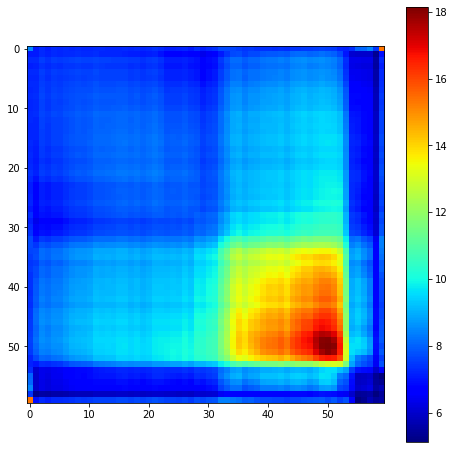

In [392]:
plt.imshow(feat.csim_pairs(arr) / qsum, cmap = 'jet')
plt.colorbar()
plt.rcParams["figure.figsize"]=(8,8)
# plt.imshow(feat.csim_pairs(act.T) , cmap = 'jet')
# plt.colorbar()

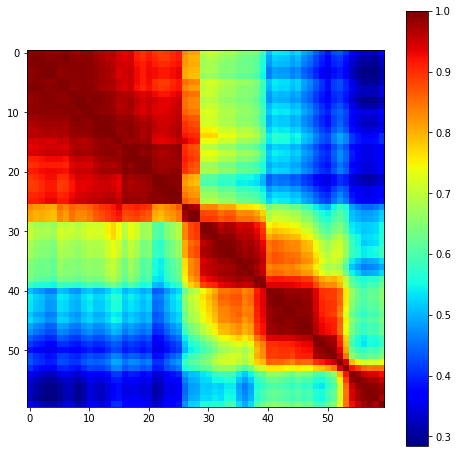

In [406]:
plt.imshow(feat.csim_pairs(arr) , cmap = 'jet')
plt.colorbar()
plt.rcParams["figure.figsize"]=(8,8)
# plt.imshow(feat.csim_pairs(act.T) , cmap = 'jet')
# plt.colorbar()

TODO compare peakfit with non-peakfit featurization

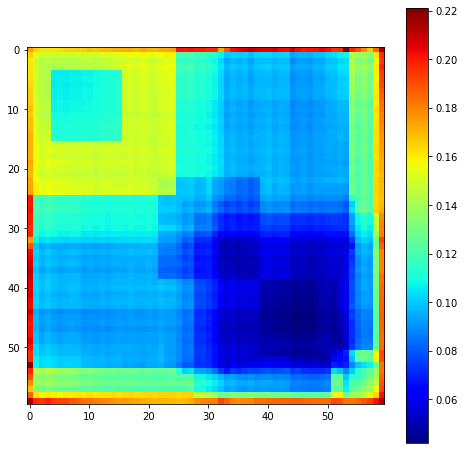

In [366]:
plt.imshow(qsum / feat.csim_pairs(arr), cmap = 'jet')
plt.colorbar()
plt.rcParams["figure.figsize"]=(8,8)
# plt.imshow(feat.csim_pairs(act.T) , cmap = 'jet')
# plt.colorbar()

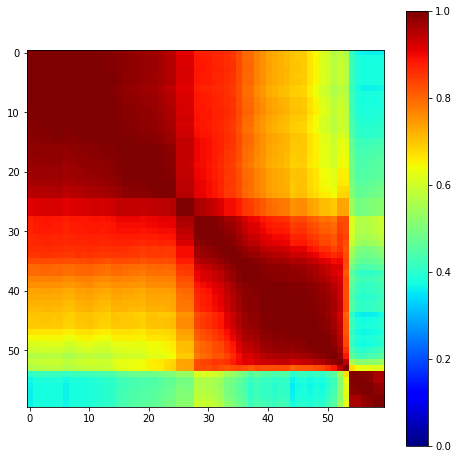

In [367]:
 plt.imshow(feat.csim_pairs((act.T)), cmap = 'jet', vmin = 0)
plt.colorbar()

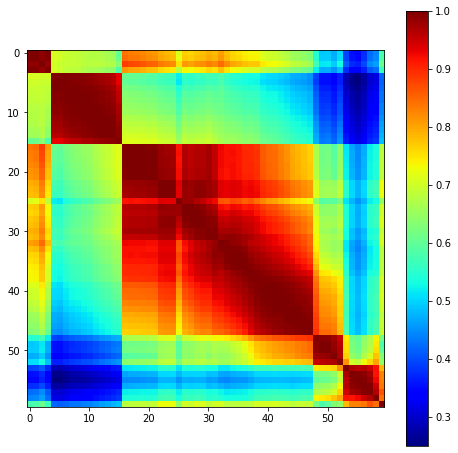

In [305]:
plt.imshow(feat.csim_pairs(activations_n1.T), cmap = 'jet')
plt.colorbar()

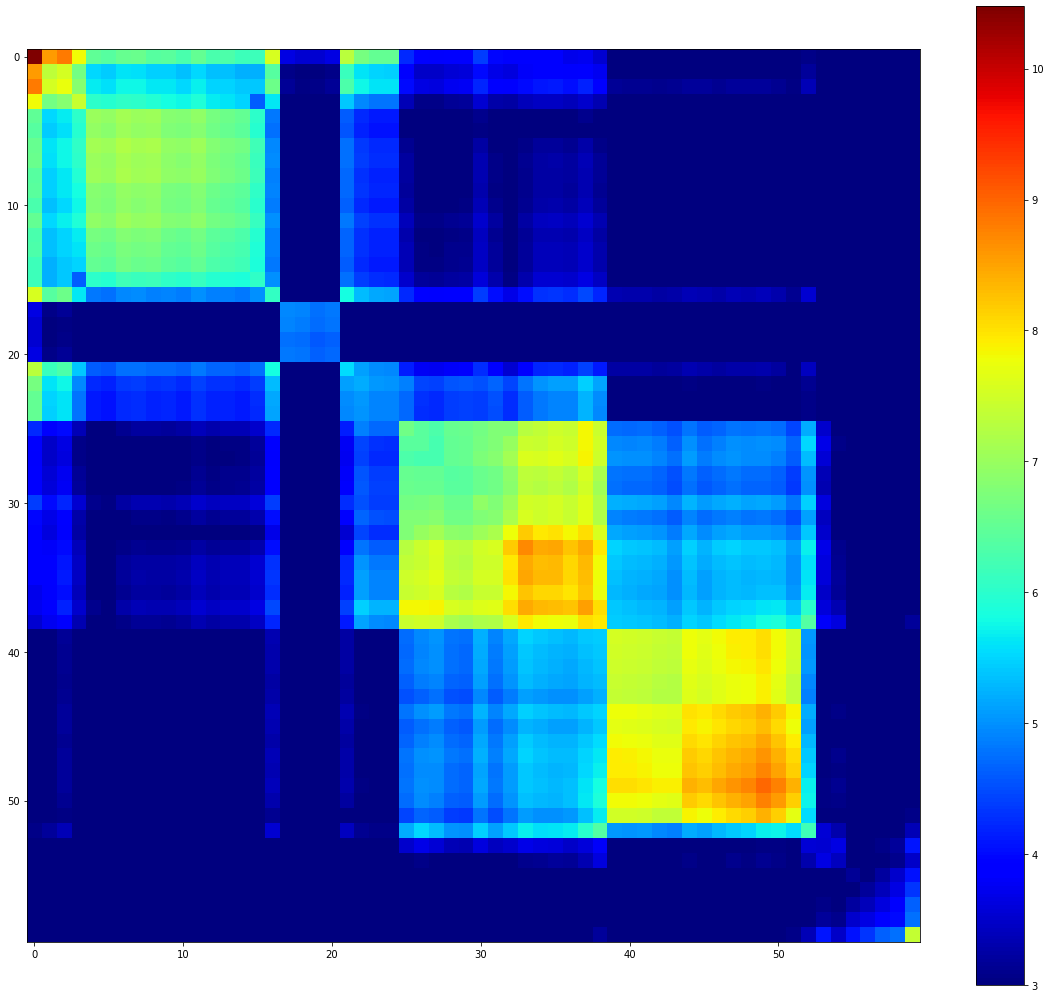

In [54]:
plt.imshow(feat.csim_pairs(activations_n1.T) / qsum, cmap = 'jet', vmin = 3)
plt.colorbar()

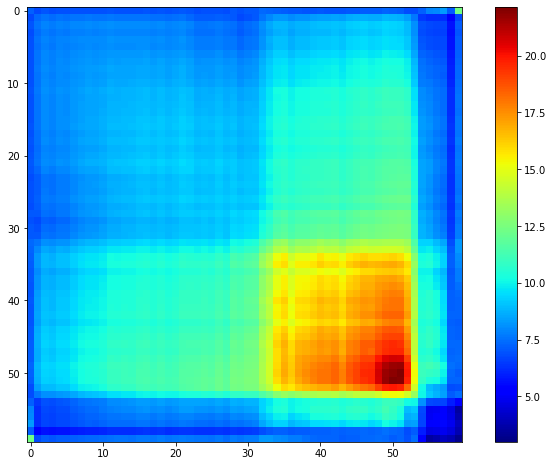

In [166]:
plt.imshow(feat.csim_pairs(activations_n1.T) / qsum, cmap = 'jet', vmin = 3)
plt.colorbar()

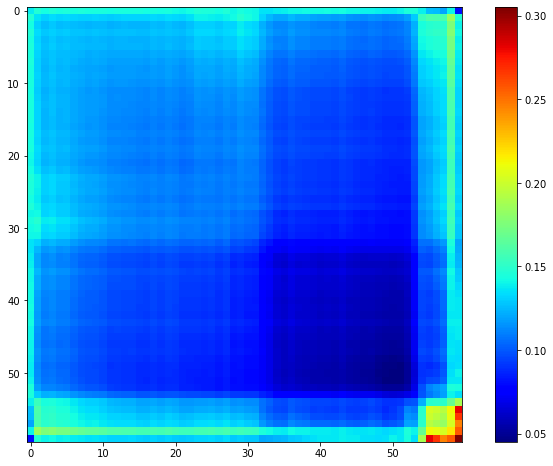

In [168]:
plt.imshow(qsum / feat.csim_pairs(activations_n1.T) , cmap = 'jet')
plt.colorbar()

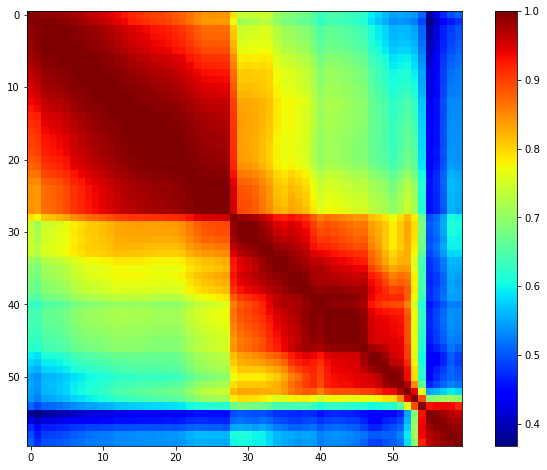

In [169]:
plt.imshow(feat.csim_pairs(activations_n1.T), cmap = 'jet')
plt.colorbar()

Text(0.5, 1.0, 'Noise amplitude (relative)')

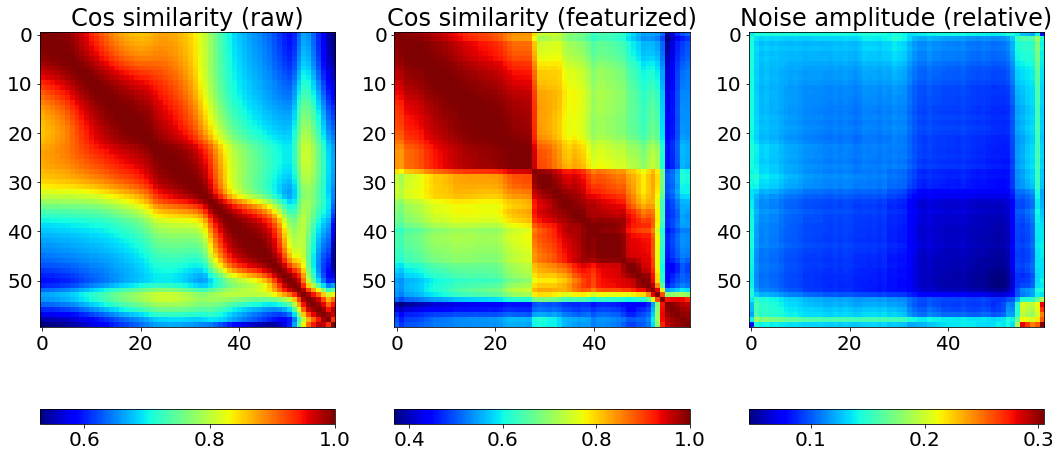

In [191]:
import matplotlib
matplotlib.rcParams.update({'font.size': 20})
plt.rcParams["figure.figsize"]=(18,10)

a, b = 1, 3

plt.subplot(a, b, 1)
plt.imshow(feat.csim_pairs(patterns), cmap = 'jet')
plt.title('Cos similarity (raw)')
plt.colorbar(shrink = 1, orientation = 'horizontal')


plt.subplot(a, b, 2)
plt.imshow(feat.csim_pairs(activations_n1.T), cmap = 'jet')
plt.title('Cos similarity (featurized)')
plt.colorbar(shrink = 1, orientation = 'horizontal')


plt.subplot(a, b, 3)
plt.imshow(qsum / feat.csim_pairs(activations_n1.T), cmap = 'jet')
plt.colorbar(shrink = 1, orientation = 'horizontal')
plt.title('Noise amplitude (relative)')


Text(0.5, 1.0, 'Signal / estimated noise')

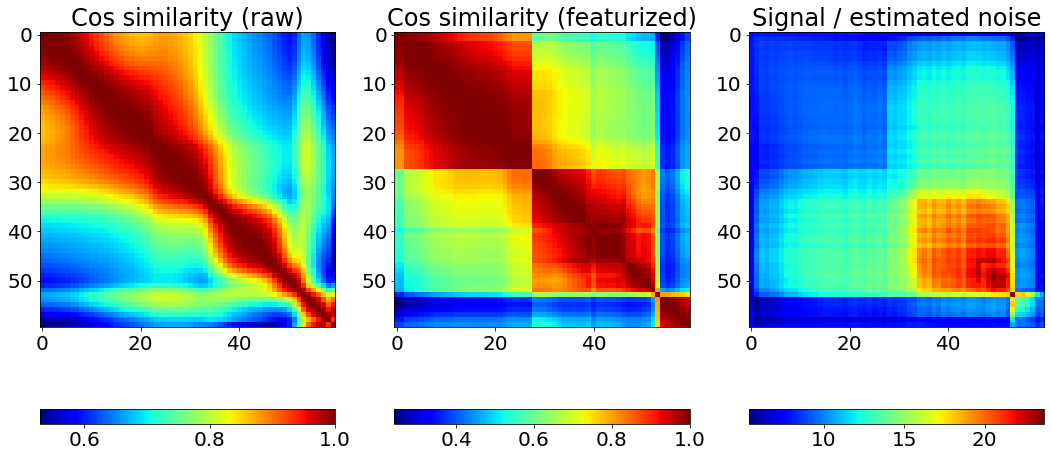

In [507]:
import matplotlib
matplotlib.rcParams.update({'font.size': 20})
plt.rcParams["figure.figsize"]=(18,10)

a, b = 1, 3

plt.subplot(a, b, 1)
plt.imshow(feat.csim_pairs(patterns), cmap = 'jet')
plt.title('Cos similarity (raw)')
plt.colorbar(shrink = 1, orientation = 'horizontal')


plt.subplot(a, b, 2)
plt.imshow(feat.csim_pairs(activations_n1.T), cmap = 'jet')
plt.title('Cos similarity (featurized)')
plt.colorbar(shrink = 1, orientation = 'horizontal')


plt.subplot(a, b, 3)
plt.imshow(feat.csim_pairs(activations_n1.T) / qsum, cmap = 'jet')
plt.colorbar(shrink = 1, orientation = 'horizontal')
plt.title('Signal / estimated noise')


Text(0.5, 1.0, 'Noise amplitude (relative)')

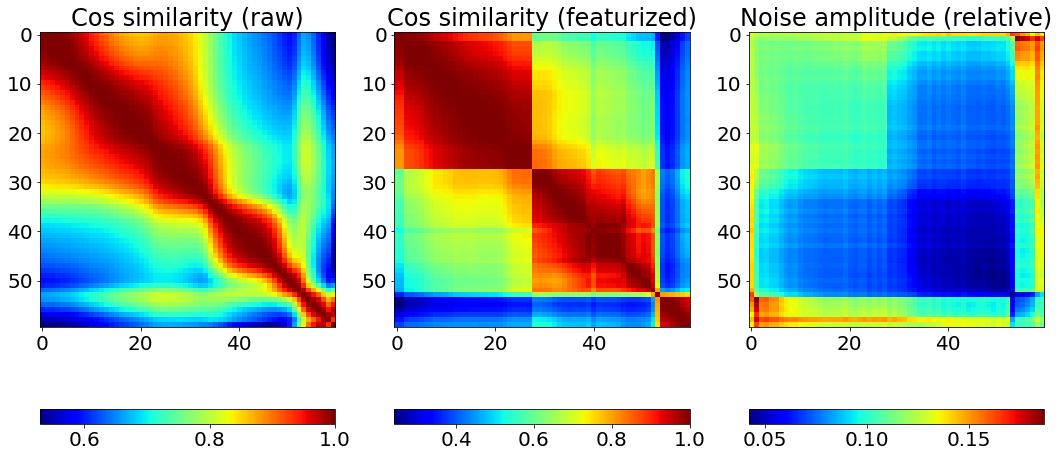

In [505]:
import matplotlib
matplotlib.rcParams.update({'font.size': 20})
plt.rcParams["figure.figsize"]=(18,10)

a, b = 1, 3

plt.subplot(a, b, 1)
plt.imshow(feat.csim_pairs(patterns), cmap = 'jet')
plt.title('Cos similarity (raw)')
plt.colorbar(shrink = 1, orientation = 'horizontal')


plt.subplot(a, b, 2)
plt.imshow(feat.csim_pairs(activations_n1.T), cmap = 'jet')
plt.title('Cos similarity (featurized)')
plt.colorbar(shrink = 1, orientation = 'horizontal')


plt.subplot(a, b, 3)
plt.imshow(qsum / feat.csim_pairs(activations_n1.T), cmap = 'jet')
plt.colorbar(shrink = 1, orientation = 'horizontal')
plt.title('Noise amplitude (relative)')


In [220]:
def heatmap(fig, arr, label = '', **kwargs):
    ax = fig

    stride = 100
    #qticks = d3d.q[::stride]
    qticks = qq[::stride]
    labels = ['{:0.1f}'.format(elt) for elt in qticks]
    
    print(len(labels), len(qticks))
    ax.set_xticklabels(labels);
    ax.set_xticks(np.arange(len(qticks)) * stride);
    if kwargs is not None:
        (kwargs.update(imargs))
    else:
        kwargs = imargs
    plt.imshow(arr, **kwargs)
    plt.title(label)
    annotate()

In [221]:
def annotate():
    plt.xlabel('$q~(1 / A)$')
    plt.ylabel('sample index')
    
heatmap(ax, patterns)

6 6


ValueError: The number of FixedLocator locations (8), usually from a call to set_ticks, does not match the number of ticklabels (6).

In [207]:
imargs = {'cmap': 'jet', 'aspect': 8}


#ax50 = fig.add_subplot(spec[5:7, 0])
img = ax.imshow(patterns, cmap = 'jet')
#plt.title('Cos similarity (raw)')
#plt.colorbar(img, ax = ax50)

Text(0.5, 1.0, 'Cos similarity (raw)')

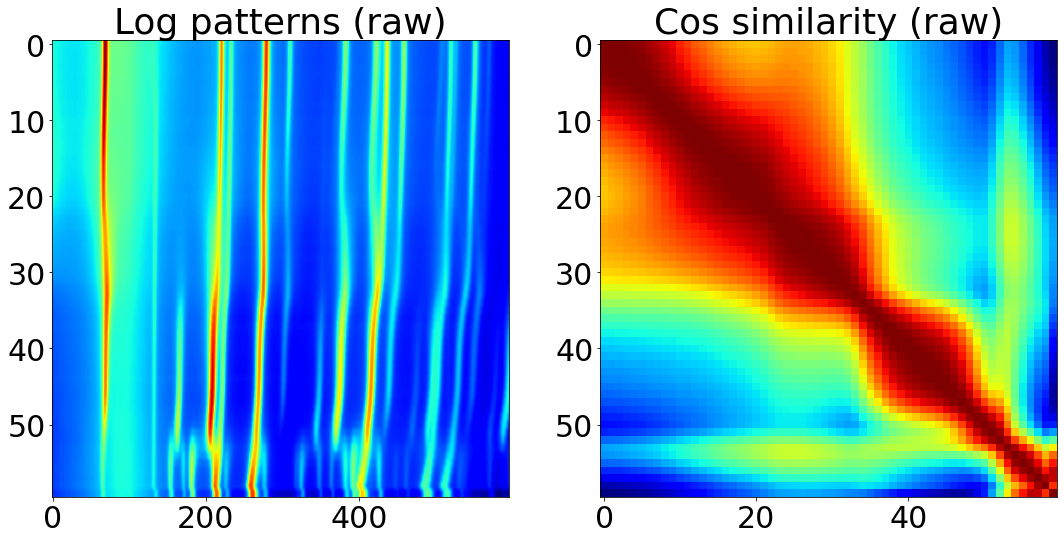

In [235]:
a, b = 1, 2
plt.rcParams["figure.figsize"]=(18,10)
matplotlib.rcParams.update({'font.size': 30})


ax = plt.subplot(a, b, 1)
plt.imshow(np.log(1 + patterns), cmap = 'jet', aspect = patterns.shape[1] / patterns.shape[0])
plt.title('Log patterns (raw)')


plt.subplot(a, b, 2)
#plt.imshow(feat.csim_pairs(activations_n1.T), cmap = 'jet')
plt.imshow(feat.csim_pairs(patterns), cmap = 'jet')
plt.title('Cos similarity (raw)')
#plt.colorbar(shrink = 1, orientation = 'horizontal')


# plt.subplot(a, b, 3)
# plt.imshow(qsum / feat.csim_pairs(activations_n1.T), cmap = 'jet')
# plt.colorbar(shrink = 1, orientation = 'horizontal')
# plt.title('Noise amplitude (relative)')


In [453]:
from xrdc import visualization as vis
reload(vis)

<module 'xrdc.visualization' from '/Users/ollie/anaconda3/lib/python3.7/site-packages/xrdc-1.0-py3.7.egg/xrdc/visualization.py'>

In [457]:
fig = plt.figure(figsize=(12, 23), constrained_layout=False)
spec = fig.add_gridspec(2, 1)

<Figure size 864x1656 with 0 Axes>

In [441]:
%pdb

Automatic pdb calling has been turned ON


In [483]:
def reference_bgsub():
#     bgsubbed_nosmooth = np.vstack([fourier.filter_bg(
#     patterns, i, 0, window_type = 'step', deconvolve = False, toreal = 'psd')
#                                for i in range(len(patterns))])
    bgsubbed_final = fast_q#gf(bgsubbed_nosmooth, (1, 1.7))
    bgsubbed_final *= patterns.max() / bgsubbed_final.max() #np.percentile(patterns, 99.9) / np.percentile(bgsubbed_final, 99.9)
    return bgsubbed_final

In [488]:
bgsubbed = sep.reference_bgsub(patterns)

Here the featurization uses hill-climbing, not peak-fitting. Should compare and use one of them consitently throughout.

In [543]:
%matplotlib inline

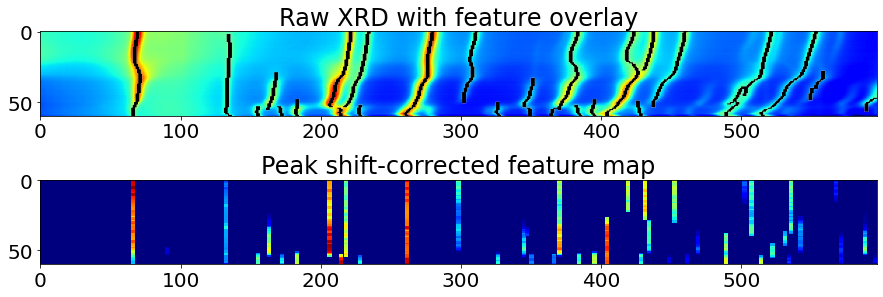

In [544]:
import matplotlib
matplotlib.rcParams.update({'font.size': 20})
plt.figure(figsize=(15, 5), constrained_layout=False)

a, b = 2, 1
plt.subplot(a, b, 1)
#vis.overlay_mask(np.log10(1 + bgsubbed), labeled.astype(bool).astype(float), aspect = 1)
vis.overlay_mask(np.log10(1 + patterns), labeled.astype(bool).astype(float), aspect = 1)
plt.title('Raw XRD with feature overlay')

plt.subplot(a, b, 2)
plt.title('Peak shift-corrected feature map')
plt.imshow(np.log(1 + straightened_heatmap), interpolation = 'none', cmap = 'jet')

In [557]:
reload(feat)

<module 'xrdc.featurization' from '/Users/ollie/anaconda3/lib/python3.7/site-packages/xrdc-1.0-py3.7.egg/xrdc/featurization.py'>

In [551]:
round(1.4)

1

Peak at 69, start iteration with error = 0.2043521057834577
Peak at 69, iteration 0: error = 0.6037791405562933
Peak at 68, start iteration with error = 0.20088187938292726
Peak at 68, iteration 0: error = 0.5378699620971986
Peak at 276, start iteration with error = 0.1965911121391499
Peak at 276, iteration 0: error = 0.4646209095239241
Peak at 276, start iteration with error = 0.22882369613833548
Peak at 276, iteration 0: error = 0.6257782032956734
Peak at 210, start iteration with error = 0.22720328732987094
Peak at 210, iteration 0: error = 0.6681159662768041
Peak at 207, start iteration with error = 0.2077216644430746
Peak at 207, iteration 0: error = 0.6129385251728726
using fitlists
using fitlists
38
0.005248889221439323


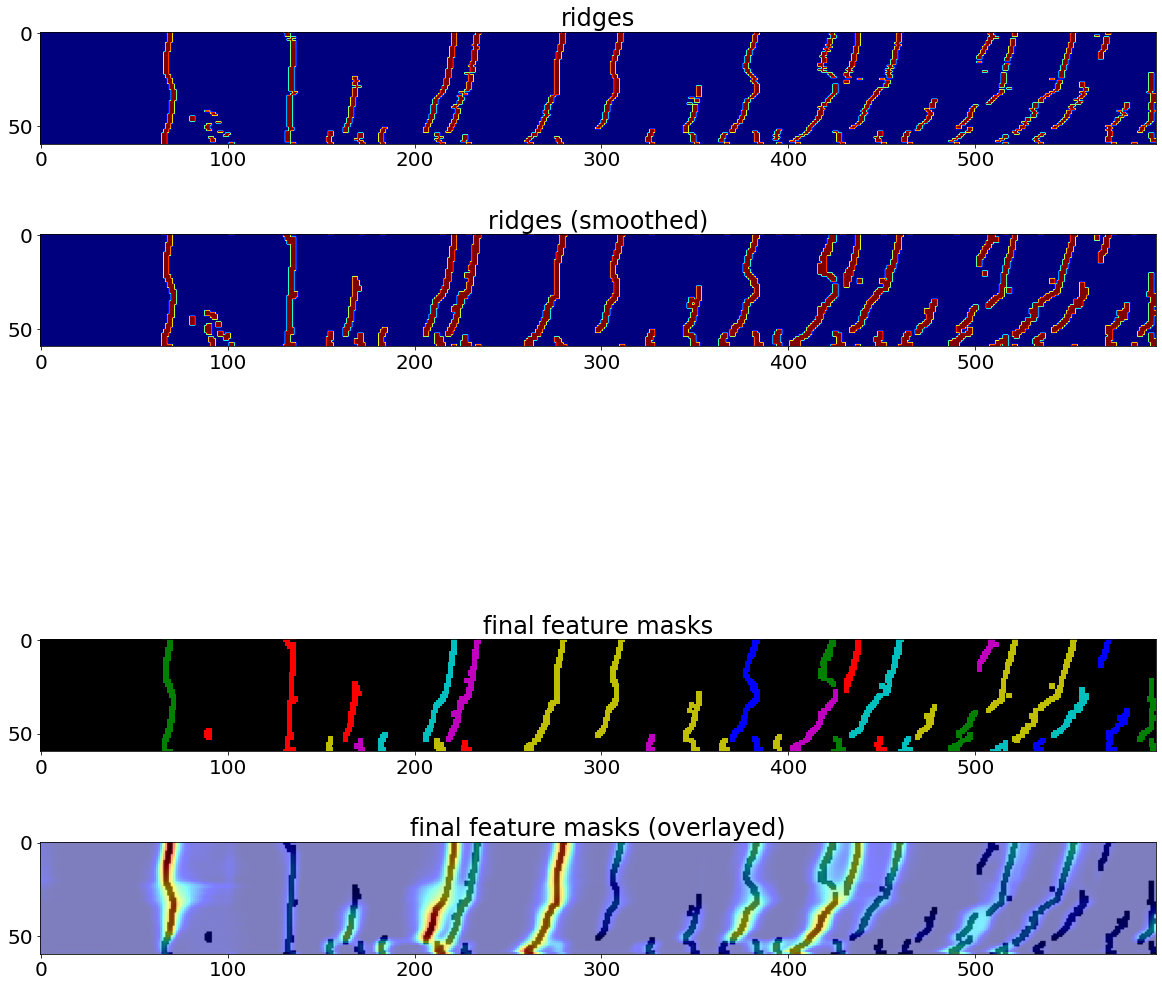

In [558]:
# patterns_pp = fast_q - fast_q.min()
patterns_pp = fast_q * (fast_q > 0)
patterns_pp /= patterns_pp.mean()
fitlists = fsub_stop_2d[1]
labeled, feature_masks, activations, norm_, activations_n1 = feat.peakfit_featurize(patterns_pp, fitlists,
                                                                    size_thresh = 5, peakwidth = 1.5)

straightened_heatmap = feat.get_peakshift_corrected_heatmap(patterns_pp, activations, labeled)

In [562]:
%matplotlib inline

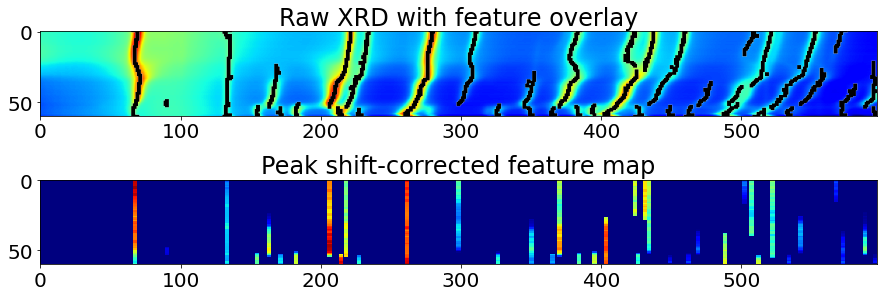

In [563]:
import matplotlib
matplotlib.rcParams.update({'font.size': 20})
plt.figure(figsize=(15, 5), constrained_layout=False)

a, b = 2, 1
plt.subplot(a, b, 1)
#vis.overlay_mask(np.log10(1 + bgsubbed), labeled.astype(bool).astype(float), aspect = 1)
vis.overlay_mask(np.log10(1 + patterns), labeled.astype(bool).astype(float), aspect = 1)
plt.title('Raw XRD with feature overlay')

plt.subplot(a, b, 2)
plt.title('Peak shift-corrected feature map')
plt.imshow(np.log(1 + straightened_heatmap), interpolation = 'none', cmap = 'jet')